# Add representations to DB
For every experiment, add representations to a separate table.
We use the following representations:
- SMILES of product A (expected product)
- SMILES of reactants I, M, T
- reactionsSMILES
- atom-mapped, unbalanced reactionSMILES

In [33]:
import os
import sys

sys.path.insert(0, os.path.abspath('../..'))

from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem import (
    Draw,
    rdChemReactions,
)

from src.util.db_utils import SynFermDatabaseConnection
from src.util.rdkit_util import map_reactions, desalt_building_block, draw_chemical_reaction

ImportError: cannot import name 'draw_chemical_reaction' from 'src.util.rdkit_util' (/home/julian/PycharmProjects/library-generation/src/util/rdkit_util.py)

In [5]:
# connect to DB
con = SynFermDatabaseConnection()

In [6]:
# import experiments
res = con.con.execute("SELECT e.id, e.initiator_long, e.monomer_long, e.terminator_long, e.product_A_smiles, bb1.SMILES, bb2.SMILES, bb3.SMILES FROM experiments as e LEFT JOIN building_blocks as bb1 on e.initiator_long = bb1.long LEFT JOIN building_blocks as bb2 on e.monomer_long = bb2.long LEFT JOIN building_blocks as bb3 on e.terminator_long = bb3.long;").fetchall()

columns = ['experiment_id', 'initiator_long', 'monomer_long', 'terminator_long', 'product_A_smiles', 'initiator_smiles', 'monomer_smiles', 'terminator_smiles']


In [7]:
def make_reaction_smiles(initiator, monomer, terminator, product):
    """Form unmapped, plain reactionSMILES"""
    return f"{initiator}.{monomer}.{terminator}>>{product}"

In [8]:
reaction_smiles = [make_reaction_smiles(*(exp[5:] + exp[4:5])) for exp in res]
len(reaction_smiles)

58664

In [9]:
rxn_TH = rdChemReactions.ReactionFromSmarts(
        '[#9]-[#5-](-[#9])(-[#9])-[#6:2](-[*:1])=[#8:3].[#8]=[#6]-1-[#8]-C-2(-[#6]-[#6]-[#6]-[#6]-[#6]2)-[#8]-[#6:7]11-[#6:6]-[#6:5]-[#7:4]-[#8]-1.[#6:11]-[#6:10](=[#16:12])-[#7:9]-[#7:8]>>[#6:11]-[#6:10]:1:[#7:9]:[#7:8]:[#6:7](-[#6:6]-[#6:5]-[#7:4]-[#6:2](-[*:1])=[#8:3]):[#16:12]-1'
    )

rxn_ABT = rdChemReactions.ReactionFromSmarts(
    "[#9]-[#5-](-[#9])(-[#9])-[#6:2](-[*:1])=[#8:3].[#8]=[#6]-1-[#8]-C-2(-[#6]-[#6]-[#6]-[#6]-[#6]2)-[#8]-[#6:7]11-[#6:6]-[#6:5]-[#7:4]-[#8]-1.[#7:8]-[#6:9]1:[#6:10]:[#6:11]:[#6:12]:[#6:13]:[#6:14]:1-[#16:15]>>[*:1]-[#6:2](=[#8:3])-[#7:4]-[#6:5]-[#6:6]-[#6:7]1:[#7:8]:[#6:9]2:[#6:10]:[#6:11]:[#6:12]:[#6:13]:[#6:14]:2:[#16:15]:1"
)
# prepare for visualization
rdChemReactions.Compute2DCoordsForReaction(rxn_TH)
rdChemReactions.Compute2DCoordsForReaction(rxn_ABT)
# prepare for enumeration
rxn_TH.Initialize()
rxn_ABT.Initialize()
# validate reactions
n_warn_TH, n_err_TH = rxn_TH.Validate(silent=True)
n_warn_ABT, n_err_ABT = rxn_ABT.Validate(silent=True)
if n_err_TH > 0:
    raise ValueError(f'Invalid reaction gave {n_err_TH} errors in validation')
if n_err_ABT > 0:
    raise ValueError(f'Invalid reaction gave {n_err_ABT} errors in validation')

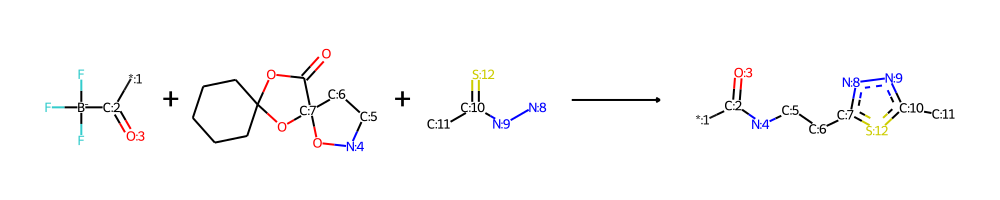

In [10]:
Draw.ReactionToImage(rxn_TH)

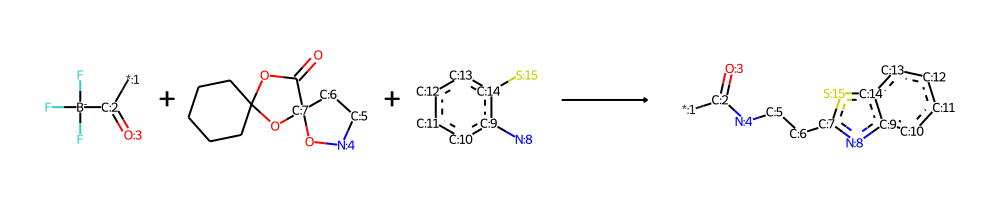

In [11]:
Draw.ReactionToImage(rxn_ABT)

In [13]:
# we apply the ABT reaction ot all combinations. It will return None where we have a TH terminator
rxns_abt = map_reactions(rxn_ABT, [[Chem.Mol(desalt_building_block(Chem.MolFromSmiles(smiles))) for smiles in reaction[5:]] for reaction in res])

ERROR: No product for reactant set with index 0
ERROR: No product for reactant set with index 2
ERROR: No product for reactant set with index 3
ERROR: No product for reactant set with index 4
ERROR: No product for reactant set with index 5
ERROR: No product for reactant set with index 6
ERROR: No product for reactant set with index 10
ERROR: No product for reactant set with index 12
ERROR: No product for reactant set with index 13
ERROR: No product for reactant set with index 14
ERROR: No product for reactant set with index 15
ERROR: No product for reactant set with index 16
ERROR: No product for reactant set with index 20
ERROR: No product for reactant set with index 22
ERROR: No product for reactant set with index 23
ERROR: No product for reactant set with index 24
ERROR: No product for reactant set with index 25
ERROR: No product for reactant set with index 26
ERROR: No product for reactant set with index 30
ERROR: No product for reactant set with index 32
ERROR: No product for reac

ERROR: No product for reactant set with index 280
ERROR: No product for reactant set with index 282
ERROR: No product for reactant set with index 283
ERROR: No product for reactant set with index 284
ERROR: No product for reactant set with index 285
ERROR: No product for reactant set with index 286
ERROR: No product for reactant set with index 290
ERROR: No product for reactant set with index 292
ERROR: No product for reactant set with index 293
ERROR: No product for reactant set with index 294
ERROR: No product for reactant set with index 295
ERROR: No product for reactant set with index 296
ERROR: No product for reactant set with index 300
ERROR: No product for reactant set with index 302
ERROR: No product for reactant set with index 303
ERROR: No product for reactant set with index 304
ERROR: No product for reactant set with index 305
ERROR: No product for reactant set with index 306
ERROR: No product for reactant set with index 310
ERROR: No product for reactant set with index 312


ERROR: No product for reactant set with index 560
ERROR: No product for reactant set with index 562
ERROR: No product for reactant set with index 563
ERROR: No product for reactant set with index 564
ERROR: No product for reactant set with index 565
ERROR: No product for reactant set with index 566
ERROR: No product for reactant set with index 570
ERROR: No product for reactant set with index 572
ERROR: No product for reactant set with index 573
ERROR: No product for reactant set with index 574
ERROR: No product for reactant set with index 575
ERROR: No product for reactant set with index 576
ERROR: No product for reactant set with index 580
ERROR: No product for reactant set with index 582
ERROR: No product for reactant set with index 583
ERROR: No product for reactant set with index 584
ERROR: No product for reactant set with index 585
ERROR: No product for reactant set with index 586
ERROR: No product for reactant set with index 590
ERROR: No product for reactant set with index 592


ERROR: No product for reactant set with index 850
ERROR: No product for reactant set with index 852
ERROR: No product for reactant set with index 853
ERROR: No product for reactant set with index 854
ERROR: No product for reactant set with index 855
ERROR: No product for reactant set with index 856
ERROR: No product for reactant set with index 860
ERROR: No product for reactant set with index 862
ERROR: No product for reactant set with index 863
ERROR: No product for reactant set with index 864
ERROR: No product for reactant set with index 865
ERROR: No product for reactant set with index 866
ERROR: No product for reactant set with index 870
ERROR: No product for reactant set with index 872
ERROR: No product for reactant set with index 873
ERROR: No product for reactant set with index 874
ERROR: No product for reactant set with index 875
ERROR: No product for reactant set with index 876
ERROR: No product for reactant set with index 880
ERROR: No product for reactant set with index 882


ERROR: No product for reactant set with index 1109
ERROR: No product for reactant set with index 1110
ERROR: No product for reactant set with index 1111
ERROR: No product for reactant set with index 1112
ERROR: No product for reactant set with index 1113
ERROR: No product for reactant set with index 1114
ERROR: No product for reactant set with index 1117
ERROR: No product for reactant set with index 1119
ERROR: No product for reactant set with index 1120
ERROR: No product for reactant set with index 1121
ERROR: No product for reactant set with index 1122
ERROR: No product for reactant set with index 1123
ERROR: No product for reactant set with index 1124
ERROR: No product for reactant set with index 1127
ERROR: No product for reactant set with index 1129
ERROR: No product for reactant set with index 1130
ERROR: No product for reactant set with index 1131
ERROR: No product for reactant set with index 1132
ERROR: No product for reactant set with index 1133
ERROR: No product for reactant 

ERROR: No product for reactant set with index 1347
ERROR: No product for reactant set with index 1349
ERROR: No product for reactant set with index 1350
ERROR: No product for reactant set with index 1351
ERROR: No product for reactant set with index 1352
ERROR: No product for reactant set with index 1353
ERROR: No product for reactant set with index 1354
ERROR: No product for reactant set with index 1357
ERROR: No product for reactant set with index 1359
ERROR: No product for reactant set with index 1360
ERROR: No product for reactant set with index 1361
ERROR: No product for reactant set with index 1362
ERROR: No product for reactant set with index 1363
ERROR: No product for reactant set with index 1364
ERROR: No product for reactant set with index 1367
ERROR: No product for reactant set with index 1369
ERROR: No product for reactant set with index 1370
ERROR: No product for reactant set with index 1371
ERROR: No product for reactant set with index 1372
ERROR: No product for reactant 

ERROR: No product for reactant set with index 1587
ERROR: No product for reactant set with index 1589
ERROR: No product for reactant set with index 1590
ERROR: No product for reactant set with index 1591
ERROR: No product for reactant set with index 1592
ERROR: No product for reactant set with index 1593
ERROR: No product for reactant set with index 1594
ERROR: No product for reactant set with index 1597
ERROR: No product for reactant set with index 1599
ERROR: No product for reactant set with index 1600
ERROR: No product for reactant set with index 1601
ERROR: No product for reactant set with index 1602
ERROR: No product for reactant set with index 1603
ERROR: No product for reactant set with index 1604
ERROR: No product for reactant set with index 1607
ERROR: No product for reactant set with index 1609
ERROR: No product for reactant set with index 1610
ERROR: No product for reactant set with index 1611
ERROR: No product for reactant set with index 1612
ERROR: No product for reactant 

ERROR: No product for reactant set with index 1827
ERROR: No product for reactant set with index 1829
ERROR: No product for reactant set with index 1830
ERROR: No product for reactant set with index 1831
ERROR: No product for reactant set with index 1832
ERROR: No product for reactant set with index 1833
ERROR: No product for reactant set with index 1834
ERROR: No product for reactant set with index 1837
ERROR: No product for reactant set with index 1839
ERROR: No product for reactant set with index 1840
ERROR: No product for reactant set with index 1841
ERROR: No product for reactant set with index 1842
ERROR: No product for reactant set with index 1843
ERROR: No product for reactant set with index 1844
ERROR: No product for reactant set with index 1847
ERROR: No product for reactant set with index 1849
ERROR: No product for reactant set with index 1850
ERROR: No product for reactant set with index 1851
ERROR: No product for reactant set with index 1852
ERROR: No product for reactant 

ERROR: No product for reactant set with index 2112
ERROR: No product for reactant set with index 2113
ERROR: No product for reactant set with index 2115
ERROR: No product for reactant set with index 2116
ERROR: No product for reactant set with index 2120
ERROR: No product for reactant set with index 2121
ERROR: No product for reactant set with index 2123
ERROR: No product for reactant set with index 2124
ERROR: No product for reactant set with index 2128
ERROR: No product for reactant set with index 2129
ERROR: No product for reactant set with index 2131
ERROR: No product for reactant set with index 2132
ERROR: No product for reactant set with index 2136
ERROR: No product for reactant set with index 2137
ERROR: No product for reactant set with index 2139
ERROR: No product for reactant set with index 2140
ERROR: No product for reactant set with index 2144
ERROR: No product for reactant set with index 2145
ERROR: No product for reactant set with index 2147
ERROR: No product for reactant 

ERROR: No product for reactant set with index 2413
ERROR: No product for reactant set with index 2414
ERROR: No product for reactant set with index 2416
ERROR: No product for reactant set with index 2417
ERROR: No product for reactant set with index 2419
ERROR: No product for reactant set with index 2420
ERROR: No product for reactant set with index 2422
ERROR: No product for reactant set with index 2423
ERROR: No product for reactant set with index 2425
ERROR: No product for reactant set with index 2426
ERROR: No product for reactant set with index 2428
ERROR: No product for reactant set with index 2429
ERROR: No product for reactant set with index 2431
ERROR: No product for reactant set with index 2432
ERROR: No product for reactant set with index 2434
ERROR: No product for reactant set with index 2435
ERROR: No product for reactant set with index 2437
ERROR: No product for reactant set with index 2438
ERROR: No product for reactant set with index 2440
ERROR: No product for reactant 

ERROR: No product for reactant set with index 2662
ERROR: No product for reactant set with index 2663
ERROR: No product for reactant set with index 2665
ERROR: No product for reactant set with index 2666
ERROR: No product for reactant set with index 2668
ERROR: No product for reactant set with index 2669
ERROR: No product for reactant set with index 2671
ERROR: No product for reactant set with index 2672
ERROR: No product for reactant set with index 2674
ERROR: No product for reactant set with index 2675
ERROR: No product for reactant set with index 2677
ERROR: No product for reactant set with index 2678
ERROR: No product for reactant set with index 2680
ERROR: No product for reactant set with index 2681
ERROR: No product for reactant set with index 2683
ERROR: No product for reactant set with index 2684
ERROR: No product for reactant set with index 2686
ERROR: No product for reactant set with index 2687
ERROR: No product for reactant set with index 2689
ERROR: No product for reactant 

ERROR: No product for reactant set with index 2920
ERROR: No product for reactant set with index 2921
ERROR: No product for reactant set with index 2923
ERROR: No product for reactant set with index 2924
ERROR: No product for reactant set with index 2926
ERROR: No product for reactant set with index 2927
ERROR: No product for reactant set with index 2929
ERROR: No product for reactant set with index 2930
ERROR: No product for reactant set with index 2932
ERROR: No product for reactant set with index 2933
ERROR: No product for reactant set with index 2935
ERROR: No product for reactant set with index 2936
ERROR: No product for reactant set with index 2938
ERROR: No product for reactant set with index 2939
ERROR: No product for reactant set with index 2941
ERROR: No product for reactant set with index 2942
ERROR: No product for reactant set with index 2944
ERROR: No product for reactant set with index 2945
ERROR: No product for reactant set with index 2947
ERROR: No product for reactant 

ERROR: No product for reactant set with index 3191
ERROR: No product for reactant set with index 3192
ERROR: No product for reactant set with index 3193
ERROR: No product for reactant set with index 3194
ERROR: No product for reactant set with index 3195
ERROR: No product for reactant set with index 3197
ERROR: No product for reactant set with index 3201
ERROR: No product for reactant set with index 3202
ERROR: No product for reactant set with index 3203
ERROR: No product for reactant set with index 3204
ERROR: No product for reactant set with index 3205
ERROR: No product for reactant set with index 3207
ERROR: No product for reactant set with index 3211
ERROR: No product for reactant set with index 3212
ERROR: No product for reactant set with index 3213
ERROR: No product for reactant set with index 3214
ERROR: No product for reactant set with index 3215
ERROR: No product for reactant set with index 3217
ERROR: No product for reactant set with index 3221
ERROR: No product for reactant 

ERROR: No product for reactant set with index 3461
ERROR: No product for reactant set with index 3462
ERROR: No product for reactant set with index 3463
ERROR: No product for reactant set with index 3464
ERROR: No product for reactant set with index 3465
ERROR: No product for reactant set with index 3467
ERROR: No product for reactant set with index 3471
ERROR: No product for reactant set with index 3472
ERROR: No product for reactant set with index 3473
ERROR: No product for reactant set with index 3474
ERROR: No product for reactant set with index 3475
ERROR: No product for reactant set with index 3477
ERROR: No product for reactant set with index 3481
ERROR: No product for reactant set with index 3482
ERROR: No product for reactant set with index 3483
ERROR: No product for reactant set with index 3484
ERROR: No product for reactant set with index 3485
ERROR: No product for reactant set with index 3487
ERROR: No product for reactant set with index 3491
ERROR: No product for reactant 

ERROR: No product for reactant set with index 3737
ERROR: No product for reactant set with index 3741
ERROR: No product for reactant set with index 3742
ERROR: No product for reactant set with index 3743
ERROR: No product for reactant set with index 3744
ERROR: No product for reactant set with index 3745
ERROR: No product for reactant set with index 3747
ERROR: No product for reactant set with index 3751
ERROR: No product for reactant set with index 3752
ERROR: No product for reactant set with index 3753
ERROR: No product for reactant set with index 3754
ERROR: No product for reactant set with index 3755
ERROR: No product for reactant set with index 3757
ERROR: No product for reactant set with index 3761
ERROR: No product for reactant set with index 3762
ERROR: No product for reactant set with index 3763
ERROR: No product for reactant set with index 3764
ERROR: No product for reactant set with index 3765
ERROR: No product for reactant set with index 3767
ERROR: No product for reactant 

ERROR: No product for reactant set with index 3997
ERROR: No product for reactant set with index 3998
ERROR: No product for reactant set with index 3999
ERROR: No product for reactant set with index 4000
ERROR: No product for reactant set with index 4001
ERROR: No product for reactant set with index 4003
ERROR: No product for reactant set with index 4007
ERROR: No product for reactant set with index 4008
ERROR: No product for reactant set with index 4009
ERROR: No product for reactant set with index 4010
ERROR: No product for reactant set with index 4011
ERROR: No product for reactant set with index 4013
ERROR: No product for reactant set with index 4017
ERROR: No product for reactant set with index 4018
ERROR: No product for reactant set with index 4019
ERROR: No product for reactant set with index 4020
ERROR: No product for reactant set with index 4021
ERROR: No product for reactant set with index 4023
ERROR: No product for reactant set with index 4027
ERROR: No product for reactant 

ERROR: No product for reactant set with index 4267
ERROR: No product for reactant set with index 4268
ERROR: No product for reactant set with index 4269
ERROR: No product for reactant set with index 4270
ERROR: No product for reactant set with index 4271
ERROR: No product for reactant set with index 4273
ERROR: No product for reactant set with index 4277
ERROR: No product for reactant set with index 4278
ERROR: No product for reactant set with index 4279
ERROR: No product for reactant set with index 4280
ERROR: No product for reactant set with index 4281
ERROR: No product for reactant set with index 4283
ERROR: No product for reactant set with index 4287
ERROR: No product for reactant set with index 4288
ERROR: No product for reactant set with index 4289
ERROR: No product for reactant set with index 4290
ERROR: No product for reactant set with index 4291
ERROR: No product for reactant set with index 4293
ERROR: No product for reactant set with index 4297
ERROR: No product for reactant 

ERROR: No product for reactant set with index 4537
ERROR: No product for reactant set with index 4538
ERROR: No product for reactant set with index 4539
ERROR: No product for reactant set with index 4540
ERROR: No product for reactant set with index 4541
ERROR: No product for reactant set with index 4543
ERROR: No product for reactant set with index 4547
ERROR: No product for reactant set with index 4548
ERROR: No product for reactant set with index 4549
ERROR: No product for reactant set with index 4550
ERROR: No product for reactant set with index 4551
ERROR: No product for reactant set with index 4553
ERROR: No product for reactant set with index 4557
ERROR: No product for reactant set with index 4558
ERROR: No product for reactant set with index 4559
ERROR: No product for reactant set with index 4560
ERROR: No product for reactant set with index 4561
ERROR: No product for reactant set with index 4563
ERROR: No product for reactant set with index 4567
ERROR: No product for reactant 

ERROR: No product for reactant set with index 4807
ERROR: No product for reactant set with index 4808
ERROR: No product for reactant set with index 4809
ERROR: No product for reactant set with index 4810
ERROR: No product for reactant set with index 4811
ERROR: No product for reactant set with index 4813
ERROR: No product for reactant set with index 4817
ERROR: No product for reactant set with index 4818
ERROR: No product for reactant set with index 4819
ERROR: No product for reactant set with index 4820
ERROR: No product for reactant set with index 4821
ERROR: No product for reactant set with index 4823
ERROR: No product for reactant set with index 4827
ERROR: No product for reactant set with index 4828
ERROR: No product for reactant set with index 4829
ERROR: No product for reactant set with index 4830
ERROR: No product for reactant set with index 4831
ERROR: No product for reactant set with index 4833
ERROR: No product for reactant set with index 4837
ERROR: No product for reactant 

ERROR: No product for reactant set with index 5065
ERROR: No product for reactant set with index 5067
ERROR: No product for reactant set with index 5068
ERROR: No product for reactant set with index 5069
ERROR: No product for reactant set with index 5070
ERROR: No product for reactant set with index 5071
ERROR: No product for reactant set with index 5072
ERROR: No product for reactant set with index 5075
ERROR: No product for reactant set with index 5077
ERROR: No product for reactant set with index 5078
ERROR: No product for reactant set with index 5079
ERROR: No product for reactant set with index 5080
ERROR: No product for reactant set with index 5081
ERROR: No product for reactant set with index 5082
ERROR: No product for reactant set with index 5085
ERROR: No product for reactant set with index 5087
ERROR: No product for reactant set with index 5088
ERROR: No product for reactant set with index 5089
ERROR: No product for reactant set with index 5090
ERROR: No product for reactant 

ERROR: No product for reactant set with index 5295
ERROR: No product for reactant set with index 5297
ERROR: No product for reactant set with index 5298
ERROR: No product for reactant set with index 5299
ERROR: No product for reactant set with index 5300
ERROR: No product for reactant set with index 5301
ERROR: No product for reactant set with index 5302
ERROR: No product for reactant set with index 5305
ERROR: No product for reactant set with index 5307
ERROR: No product for reactant set with index 5308
ERROR: No product for reactant set with index 5309
ERROR: No product for reactant set with index 5310
ERROR: No product for reactant set with index 5311
ERROR: No product for reactant set with index 5312
ERROR: No product for reactant set with index 5315
ERROR: No product for reactant set with index 5317
ERROR: No product for reactant set with index 5318
ERROR: No product for reactant set with index 5319
ERROR: No product for reactant set with index 5320
ERROR: No product for reactant 

ERROR: No product for reactant set with index 5535
ERROR: No product for reactant set with index 5537
ERROR: No product for reactant set with index 5538
ERROR: No product for reactant set with index 5539
ERROR: No product for reactant set with index 5540
ERROR: No product for reactant set with index 5541
ERROR: No product for reactant set with index 5542
ERROR: No product for reactant set with index 5545
ERROR: No product for reactant set with index 5547
ERROR: No product for reactant set with index 5548
ERROR: No product for reactant set with index 5549
ERROR: No product for reactant set with index 5550
ERROR: No product for reactant set with index 5551
ERROR: No product for reactant set with index 5552
ERROR: No product for reactant set with index 5555
ERROR: No product for reactant set with index 5557
ERROR: No product for reactant set with index 5558
ERROR: No product for reactant set with index 5559
ERROR: No product for reactant set with index 5560
ERROR: No product for reactant 

ERROR: No product for reactant set with index 5767
ERROR: No product for reactant set with index 5768
ERROR: No product for reactant set with index 5769
ERROR: No product for reactant set with index 5770
ERROR: No product for reactant set with index 5771
ERROR: No product for reactant set with index 5772
ERROR: No product for reactant set with index 5775
ERROR: No product for reactant set with index 5777
ERROR: No product for reactant set with index 5778
ERROR: No product for reactant set with index 5779
ERROR: No product for reactant set with index 5780
ERROR: No product for reactant set with index 5781
ERROR: No product for reactant set with index 5782
ERROR: No product for reactant set with index 5785
ERROR: No product for reactant set with index 5787
ERROR: No product for reactant set with index 5788
ERROR: No product for reactant set with index 5789
ERROR: No product for reactant set with index 5790
ERROR: No product for reactant set with index 5791
ERROR: No product for reactant 

ERROR: No product for reactant set with index 6007
ERROR: No product for reactant set with index 6008
ERROR: No product for reactant set with index 6009
ERROR: No product for reactant set with index 6010
ERROR: No product for reactant set with index 6011
ERROR: No product for reactant set with index 6012
ERROR: No product for reactant set with index 6015
ERROR: No product for reactant set with index 6017
ERROR: No product for reactant set with index 6018
ERROR: No product for reactant set with index 6019
ERROR: No product for reactant set with index 6020
ERROR: No product for reactant set with index 6021
ERROR: No product for reactant set with index 6022
ERROR: No product for reactant set with index 6025
ERROR: No product for reactant set with index 6027
ERROR: No product for reactant set with index 6028
ERROR: No product for reactant set with index 6029
ERROR: No product for reactant set with index 6030
ERROR: No product for reactant set with index 6031
ERROR: No product for reactant 

ERROR: No product for reactant set with index 6257
ERROR: No product for reactant set with index 6258
ERROR: No product for reactant set with index 6259
ERROR: No product for reactant set with index 6260
ERROR: No product for reactant set with index 6261
ERROR: No product for reactant set with index 6262
ERROR: No product for reactant set with index 6265
ERROR: No product for reactant set with index 6267
ERROR: No product for reactant set with index 6268
ERROR: No product for reactant set with index 6269
ERROR: No product for reactant set with index 6270
ERROR: No product for reactant set with index 6271
ERROR: No product for reactant set with index 6272
ERROR: No product for reactant set with index 6275
ERROR: No product for reactant set with index 6277
ERROR: No product for reactant set with index 6278
ERROR: No product for reactant set with index 6279
ERROR: No product for reactant set with index 6280
ERROR: No product for reactant set with index 6281
ERROR: No product for reactant 

ERROR: No product for reactant set with index 6497
ERROR: No product for reactant set with index 6498
ERROR: No product for reactant set with index 6499
ERROR: No product for reactant set with index 6500
ERROR: No product for reactant set with index 6501
ERROR: No product for reactant set with index 6503
ERROR: No product for reactant set with index 6507
ERROR: No product for reactant set with index 6508
ERROR: No product for reactant set with index 6509
ERROR: No product for reactant set with index 6510
ERROR: No product for reactant set with index 6511
ERROR: No product for reactant set with index 6513
ERROR: No product for reactant set with index 6517
ERROR: No product for reactant set with index 6518
ERROR: No product for reactant set with index 6519
ERROR: No product for reactant set with index 6520
ERROR: No product for reactant set with index 6521
ERROR: No product for reactant set with index 6523
ERROR: No product for reactant set with index 6527
ERROR: No product for reactant 

ERROR: No product for reactant set with index 6767
ERROR: No product for reactant set with index 6768
ERROR: No product for reactant set with index 6769
ERROR: No product for reactant set with index 6770
ERROR: No product for reactant set with index 6771
ERROR: No product for reactant set with index 6773
ERROR: No product for reactant set with index 6777
ERROR: No product for reactant set with index 6778
ERROR: No product for reactant set with index 6779
ERROR: No product for reactant set with index 6780
ERROR: No product for reactant set with index 6781
ERROR: No product for reactant set with index 6783
ERROR: No product for reactant set with index 6787
ERROR: No product for reactant set with index 6788
ERROR: No product for reactant set with index 6789
ERROR: No product for reactant set with index 6790
ERROR: No product for reactant set with index 6791
ERROR: No product for reactant set with index 6793
ERROR: No product for reactant set with index 6797
ERROR: No product for reactant 

ERROR: No product for reactant set with index 7047
ERROR: No product for reactant set with index 7048
ERROR: No product for reactant set with index 7049
ERROR: No product for reactant set with index 7050
ERROR: No product for reactant set with index 7051
ERROR: No product for reactant set with index 7053
ERROR: No product for reactant set with index 7057
ERROR: No product for reactant set with index 7058
ERROR: No product for reactant set with index 7059
ERROR: No product for reactant set with index 7060
ERROR: No product for reactant set with index 7061
ERROR: No product for reactant set with index 7063
ERROR: No product for reactant set with index 7067
ERROR: No product for reactant set with index 7068
ERROR: No product for reactant set with index 7069
ERROR: No product for reactant set with index 7070
ERROR: No product for reactant set with index 7071
ERROR: No product for reactant set with index 7073
ERROR: No product for reactant set with index 7077
ERROR: No product for reactant 

ERROR: No product for reactant set with index 7365
ERROR: No product for reactant set with index 7366
ERROR: No product for reactant set with index 7367
ERROR: No product for reactant set with index 7369
ERROR: No product for reactant set with index 7370
ERROR: No product for reactant set with index 7371
ERROR: No product for reactant set with index 7378
ERROR: No product for reactant set with index 7380
ERROR: No product for reactant set with index 7381
ERROR: No product for reactant set with index 7382
ERROR: No product for reactant set with index 7383
ERROR: No product for reactant set with index 7384
ERROR: No product for reactant set with index 7389
ERROR: No product for reactant set with index 7390
ERROR: No product for reactant set with index 7391
ERROR: No product for reactant set with index 7393
ERROR: No product for reactant set with index 7394
ERROR: No product for reactant set with index 7395
ERROR: No product for reactant set with index 7402
ERROR: No product for reactant 

ERROR: No product for reactant set with index 7650
ERROR: No product for reactant set with index 7654
ERROR: No product for reactant set with index 7655
ERROR: No product for reactant set with index 7656
ERROR: No product for reactant set with index 7657
ERROR: No product for reactant set with index 7658
ERROR: No product for reactant set with index 7660
ERROR: No product for reactant set with index 7664
ERROR: No product for reactant set with index 7665
ERROR: No product for reactant set with index 7666
ERROR: No product for reactant set with index 7667
ERROR: No product for reactant set with index 7668
ERROR: No product for reactant set with index 7670
ERROR: No product for reactant set with index 7674
ERROR: No product for reactant set with index 7675
ERROR: No product for reactant set with index 7676
ERROR: No product for reactant set with index 7677
ERROR: No product for reactant set with index 7678
ERROR: No product for reactant set with index 7680
ERROR: No product for reactant 

ERROR: No product for reactant set with index 7924
ERROR: No product for reactant set with index 7925
ERROR: No product for reactant set with index 7926
ERROR: No product for reactant set with index 7927
ERROR: No product for reactant set with index 7928
ERROR: No product for reactant set with index 7930
ERROR: No product for reactant set with index 7934
ERROR: No product for reactant set with index 7935
ERROR: No product for reactant set with index 7936
ERROR: No product for reactant set with index 7937
ERROR: No product for reactant set with index 7938
ERROR: No product for reactant set with index 7940
ERROR: No product for reactant set with index 7944
ERROR: No product for reactant set with index 7945
ERROR: No product for reactant set with index 7946
ERROR: No product for reactant set with index 7947
ERROR: No product for reactant set with index 7948
ERROR: No product for reactant set with index 7950
ERROR: No product for reactant set with index 7954
ERROR: No product for reactant 

ERROR: No product for reactant set with index 8194
ERROR: No product for reactant set with index 8195
ERROR: No product for reactant set with index 8196
ERROR: No product for reactant set with index 8197
ERROR: No product for reactant set with index 8198
ERROR: No product for reactant set with index 8200
ERROR: No product for reactant set with index 8204
ERROR: No product for reactant set with index 8205
ERROR: No product for reactant set with index 8206
ERROR: No product for reactant set with index 8207
ERROR: No product for reactant set with index 8208
ERROR: No product for reactant set with index 8210
ERROR: No product for reactant set with index 8214
ERROR: No product for reactant set with index 8215
ERROR: No product for reactant set with index 8216
ERROR: No product for reactant set with index 8217
ERROR: No product for reactant set with index 8218
ERROR: No product for reactant set with index 8220
ERROR: No product for reactant set with index 8224
ERROR: No product for reactant 

ERROR: No product for reactant set with index 8460
ERROR: No product for reactant set with index 8464
ERROR: No product for reactant set with index 8465
ERROR: No product for reactant set with index 8466
ERROR: No product for reactant set with index 8467
ERROR: No product for reactant set with index 8468
ERROR: No product for reactant set with index 8470
ERROR: No product for reactant set with index 8474
ERROR: No product for reactant set with index 8475
ERROR: No product for reactant set with index 8476
ERROR: No product for reactant set with index 8477
ERROR: No product for reactant set with index 8478
ERROR: No product for reactant set with index 8480
ERROR: No product for reactant set with index 8484
ERROR: No product for reactant set with index 8485
ERROR: No product for reactant set with index 8486
ERROR: No product for reactant set with index 8487
ERROR: No product for reactant set with index 8488
ERROR: No product for reactant set with index 8490
ERROR: No product for reactant 

ERROR: No product for reactant set with index 8734
ERROR: No product for reactant set with index 8735
ERROR: No product for reactant set with index 8736
ERROR: No product for reactant set with index 8737
ERROR: No product for reactant set with index 8738
ERROR: No product for reactant set with index 8740
ERROR: No product for reactant set with index 8744
ERROR: No product for reactant set with index 8745
ERROR: No product for reactant set with index 8746
ERROR: No product for reactant set with index 8747
ERROR: No product for reactant set with index 8748
ERROR: No product for reactant set with index 8750
ERROR: No product for reactant set with index 8754
ERROR: No product for reactant set with index 8755
ERROR: No product for reactant set with index 8756
ERROR: No product for reactant set with index 8757
ERROR: No product for reactant set with index 8758
ERROR: No product for reactant set with index 8760
ERROR: No product for reactant set with index 8764
ERROR: No product for reactant 

ERROR: No product for reactant set with index 9004
ERROR: No product for reactant set with index 9005
ERROR: No product for reactant set with index 9006
ERROR: No product for reactant set with index 9007
ERROR: No product for reactant set with index 9008
ERROR: No product for reactant set with index 9010
ERROR: No product for reactant set with index 9014
ERROR: No product for reactant set with index 9015
ERROR: No product for reactant set with index 9016
ERROR: No product for reactant set with index 9017
ERROR: No product for reactant set with index 9018
ERROR: No product for reactant set with index 9020
ERROR: No product for reactant set with index 9024
ERROR: No product for reactant set with index 9025
ERROR: No product for reactant set with index 9026
ERROR: No product for reactant set with index 9027
ERROR: No product for reactant set with index 9028
ERROR: No product for reactant set with index 9030
ERROR: No product for reactant set with index 9034
ERROR: No product for reactant 

ERROR: No product for reactant set with index 9284
ERROR: No product for reactant set with index 9285
ERROR: No product for reactant set with index 9286
ERROR: No product for reactant set with index 9287
ERROR: No product for reactant set with index 9288
ERROR: No product for reactant set with index 9290
ERROR: No product for reactant set with index 9294
ERROR: No product for reactant set with index 9295
ERROR: No product for reactant set with index 9296
ERROR: No product for reactant set with index 9297
ERROR: No product for reactant set with index 9298
ERROR: No product for reactant set with index 9300
ERROR: No product for reactant set with index 9304
ERROR: No product for reactant set with index 9305
ERROR: No product for reactant set with index 9306
ERROR: No product for reactant set with index 9307
ERROR: No product for reactant set with index 9308
ERROR: No product for reactant set with index 9310
ERROR: No product for reactant set with index 9314
ERROR: No product for reactant 

ERROR: No product for reactant set with index 9555
ERROR: No product for reactant set with index 9557
ERROR: No product for reactant set with index 9558
ERROR: No product for reactant set with index 9559
ERROR: No product for reactant set with index 9560
ERROR: No product for reactant set with index 9561
ERROR: No product for reactant set with index 9565
ERROR: No product for reactant set with index 9567
ERROR: No product for reactant set with index 9568
ERROR: No product for reactant set with index 9569
ERROR: No product for reactant set with index 9570
ERROR: No product for reactant set with index 9571
ERROR: No product for reactant set with index 9575
ERROR: No product for reactant set with index 9577
ERROR: No product for reactant set with index 9578
ERROR: No product for reactant set with index 9579
ERROR: No product for reactant set with index 9580
ERROR: No product for reactant set with index 9581
ERROR: No product for reactant set with index 9585
ERROR: No product for reactant 

ERROR: No product for reactant set with index 9827
ERROR: No product for reactant set with index 9828
ERROR: No product for reactant set with index 9829
ERROR: No product for reactant set with index 9830
ERROR: No product for reactant set with index 9831
ERROR: No product for reactant set with index 9835
ERROR: No product for reactant set with index 9837
ERROR: No product for reactant set with index 9838
ERROR: No product for reactant set with index 9839
ERROR: No product for reactant set with index 9840
ERROR: No product for reactant set with index 9841
ERROR: No product for reactant set with index 9845
ERROR: No product for reactant set with index 9847
ERROR: No product for reactant set with index 9848
ERROR: No product for reactant set with index 9849
ERROR: No product for reactant set with index 9850
ERROR: No product for reactant set with index 9851
ERROR: No product for reactant set with index 9855
ERROR: No product for reactant set with index 9857
ERROR: No product for reactant 

ERROR: No product for reactant set with index 10105
ERROR: No product for reactant set with index 10107
ERROR: No product for reactant set with index 10108
ERROR: No product for reactant set with index 10109
ERROR: No product for reactant set with index 10110
ERROR: No product for reactant set with index 10111
ERROR: No product for reactant set with index 10115
ERROR: No product for reactant set with index 10117
ERROR: No product for reactant set with index 10118
ERROR: No product for reactant set with index 10119
ERROR: No product for reactant set with index 10120
ERROR: No product for reactant set with index 10121
ERROR: No product for reactant set with index 10125
ERROR: No product for reactant set with index 10127
ERROR: No product for reactant set with index 10128
ERROR: No product for reactant set with index 10129
ERROR: No product for reactant set with index 10130
ERROR: No product for reactant set with index 10131
ERROR: No product for reactant set with index 10135
ERROR: No pr

ERROR: No product for reactant set with index 10385
ERROR: No product for reactant set with index 10387
ERROR: No product for reactant set with index 10388
ERROR: No product for reactant set with index 10389
ERROR: No product for reactant set with index 10390
ERROR: No product for reactant set with index 10391
ERROR: No product for reactant set with index 10395
ERROR: No product for reactant set with index 10397
ERROR: No product for reactant set with index 10398
ERROR: No product for reactant set with index 10399
ERROR: No product for reactant set with index 10400
ERROR: No product for reactant set with index 10401
ERROR: No product for reactant set with index 10405
ERROR: No product for reactant set with index 10407
ERROR: No product for reactant set with index 10408
ERROR: No product for reactant set with index 10409
ERROR: No product for reactant set with index 10410
ERROR: No product for reactant set with index 10411
ERROR: No product for reactant set with index 10415
ERROR: No pr

ERROR: No product for reactant set with index 10655
ERROR: No product for reactant set with index 10657
ERROR: No product for reactant set with index 10658
ERROR: No product for reactant set with index 10659
ERROR: No product for reactant set with index 10660
ERROR: No product for reactant set with index 10661
ERROR: No product for reactant set with index 10665
ERROR: No product for reactant set with index 10667
ERROR: No product for reactant set with index 10668
ERROR: No product for reactant set with index 10669
ERROR: No product for reactant set with index 10670
ERROR: No product for reactant set with index 10671
ERROR: No product for reactant set with index 10675
ERROR: No product for reactant set with index 10677
ERROR: No product for reactant set with index 10678
ERROR: No product for reactant set with index 10679
ERROR: No product for reactant set with index 10680
ERROR: No product for reactant set with index 10681
ERROR: No product for reactant set with index 10685
ERROR: No pr

ERROR: No product for reactant set with index 10930
ERROR: No product for reactant set with index 10934
ERROR: No product for reactant set with index 10935
ERROR: No product for reactant set with index 10936
ERROR: No product for reactant set with index 10937
ERROR: No product for reactant set with index 10938
ERROR: No product for reactant set with index 10940
ERROR: No product for reactant set with index 10944
ERROR: No product for reactant set with index 10945
ERROR: No product for reactant set with index 10946
ERROR: No product for reactant set with index 10947
ERROR: No product for reactant set with index 10948
ERROR: No product for reactant set with index 10950
ERROR: No product for reactant set with index 10954
ERROR: No product for reactant set with index 10955
ERROR: No product for reactant set with index 10956
ERROR: No product for reactant set with index 10957
ERROR: No product for reactant set with index 10958
ERROR: No product for reactant set with index 10960
ERROR: No pr

ERROR: No product for reactant set with index 11204
ERROR: No product for reactant set with index 11205
ERROR: No product for reactant set with index 11206
ERROR: No product for reactant set with index 11207
ERROR: No product for reactant set with index 11208
ERROR: No product for reactant set with index 11210
ERROR: No product for reactant set with index 11214
ERROR: No product for reactant set with index 11215
ERROR: No product for reactant set with index 11216
ERROR: No product for reactant set with index 11217
ERROR: No product for reactant set with index 11218
ERROR: No product for reactant set with index 11220
ERROR: No product for reactant set with index 11224
ERROR: No product for reactant set with index 11225
ERROR: No product for reactant set with index 11226
ERROR: No product for reactant set with index 11227
ERROR: No product for reactant set with index 11228
ERROR: No product for reactant set with index 11230
ERROR: No product for reactant set with index 11234
ERROR: No pr

ERROR: No product for reactant set with index 11480
ERROR: No product for reactant set with index 11484
ERROR: No product for reactant set with index 11485
ERROR: No product for reactant set with index 11486
ERROR: No product for reactant set with index 11487
ERROR: No product for reactant set with index 11488
ERROR: No product for reactant set with index 11490
ERROR: No product for reactant set with index 11494
ERROR: No product for reactant set with index 11495
ERROR: No product for reactant set with index 11496
ERROR: No product for reactant set with index 11497
ERROR: No product for reactant set with index 11498
ERROR: No product for reactant set with index 11500
ERROR: No product for reactant set with index 11504
ERROR: No product for reactant set with index 11505
ERROR: No product for reactant set with index 11506
ERROR: No product for reactant set with index 11507
ERROR: No product for reactant set with index 11508
ERROR: No product for reactant set with index 11510
ERROR: No pr

ERROR: No product for reactant set with index 11754
ERROR: No product for reactant set with index 11755
ERROR: No product for reactant set with index 11756
ERROR: No product for reactant set with index 11757
ERROR: No product for reactant set with index 11758
ERROR: No product for reactant set with index 11760
ERROR: No product for reactant set with index 11764
ERROR: No product for reactant set with index 11765
ERROR: No product for reactant set with index 11766
ERROR: No product for reactant set with index 11767
ERROR: No product for reactant set with index 11768
ERROR: No product for reactant set with index 11770
ERROR: No product for reactant set with index 11774
ERROR: No product for reactant set with index 11775
ERROR: No product for reactant set with index 11776
ERROR: No product for reactant set with index 11777
ERROR: No product for reactant set with index 11778
ERROR: No product for reactant set with index 11780
ERROR: No product for reactant set with index 11784
ERROR: No pr

ERROR: No product for reactant set with index 12024
ERROR: No product for reactant set with index 12025
ERROR: No product for reactant set with index 12026
ERROR: No product for reactant set with index 12027
ERROR: No product for reactant set with index 12028
ERROR: No product for reactant set with index 12030
ERROR: No product for reactant set with index 12034
ERROR: No product for reactant set with index 12035
ERROR: No product for reactant set with index 12036
ERROR: No product for reactant set with index 12037
ERROR: No product for reactant set with index 12038
ERROR: No product for reactant set with index 12040
ERROR: No product for reactant set with index 12044
ERROR: No product for reactant set with index 12045
ERROR: No product for reactant set with index 12046
ERROR: No product for reactant set with index 12047
ERROR: No product for reactant set with index 12048
ERROR: No product for reactant set with index 12050
ERROR: No product for reactant set with index 12054
ERROR: No pr

ERROR: No product for reactant set with index 12294
ERROR: No product for reactant set with index 12295
ERROR: No product for reactant set with index 12296
ERROR: No product for reactant set with index 12297
ERROR: No product for reactant set with index 12298
ERROR: No product for reactant set with index 12300
ERROR: No product for reactant set with index 12304
ERROR: No product for reactant set with index 12305
ERROR: No product for reactant set with index 12306
ERROR: No product for reactant set with index 12307
ERROR: No product for reactant set with index 12308
ERROR: No product for reactant set with index 12310
ERROR: No product for reactant set with index 12314
ERROR: No product for reactant set with index 12315
ERROR: No product for reactant set with index 12316
ERROR: No product for reactant set with index 12317
ERROR: No product for reactant set with index 12318
ERROR: No product for reactant set with index 12320
ERROR: No product for reactant set with index 12324
ERROR: No pr

ERROR: No product for reactant set with index 12564
ERROR: No product for reactant set with index 12565
ERROR: No product for reactant set with index 12566
ERROR: No product for reactant set with index 12567
ERROR: No product for reactant set with index 12568
ERROR: No product for reactant set with index 12570
ERROR: No product for reactant set with index 12574
ERROR: No product for reactant set with index 12575
ERROR: No product for reactant set with index 12576
ERROR: No product for reactant set with index 12577
ERROR: No product for reactant set with index 12578
ERROR: No product for reactant set with index 12580
ERROR: No product for reactant set with index 12584
ERROR: No product for reactant set with index 12585
ERROR: No product for reactant set with index 12586
ERROR: No product for reactant set with index 12587
ERROR: No product for reactant set with index 12588
ERROR: No product for reactant set with index 12590
ERROR: No product for reactant set with index 12594
ERROR: No pr

ERROR: No product for reactant set with index 12837
ERROR: No product for reactant set with index 12838
ERROR: No product for reactant set with index 12839
ERROR: No product for reactant set with index 12840
ERROR: No product for reactant set with index 12841
ERROR: No product for reactant set with index 12845
ERROR: No product for reactant set with index 12847
ERROR: No product for reactant set with index 12848
ERROR: No product for reactant set with index 12849
ERROR: No product for reactant set with index 12850
ERROR: No product for reactant set with index 12851
ERROR: No product for reactant set with index 12855
ERROR: No product for reactant set with index 12857
ERROR: No product for reactant set with index 12858
ERROR: No product for reactant set with index 12859
ERROR: No product for reactant set with index 12860
ERROR: No product for reactant set with index 12861
ERROR: No product for reactant set with index 12865
ERROR: No product for reactant set with index 12867
ERROR: No pr

ERROR: No product for reactant set with index 13104
ERROR: No product for reactant set with index 13105
ERROR: No product for reactant set with index 13106
ERROR: No product for reactant set with index 13107
ERROR: No product for reactant set with index 13108
ERROR: No product for reactant set with index 13110
ERROR: No product for reactant set with index 13114
ERROR: No product for reactant set with index 13115
ERROR: No product for reactant set with index 13116
ERROR: No product for reactant set with index 13117
ERROR: No product for reactant set with index 13118
ERROR: No product for reactant set with index 13120
ERROR: No product for reactant set with index 13124
ERROR: No product for reactant set with index 13125
ERROR: No product for reactant set with index 13126
ERROR: No product for reactant set with index 13127
ERROR: No product for reactant set with index 13128
ERROR: No product for reactant set with index 13130
ERROR: No product for reactant set with index 13134
ERROR: No pr

ERROR: No product for reactant set with index 13420
ERROR: No product for reactant set with index 13421
ERROR: No product for reactant set with index 13422
ERROR: No product for reactant set with index 13424
ERROR: No product for reactant set with index 13430
ERROR: No product for reactant set with index 13431
ERROR: No product for reactant set with index 13432
ERROR: No product for reactant set with index 13434
ERROR: No product for reactant set with index 13440
ERROR: No product for reactant set with index 13441
ERROR: No product for reactant set with index 13442
ERROR: No product for reactant set with index 13444
ERROR: No product for reactant set with index 13450
ERROR: No product for reactant set with index 13451
ERROR: No product for reactant set with index 13452
ERROR: No product for reactant set with index 13454
ERROR: No product for reactant set with index 13460
ERROR: No product for reactant set with index 13461
ERROR: No product for reactant set with index 13462
ERROR: No pr

ERROR: No product for reactant set with index 13820
ERROR: No product for reactant set with index 13821
ERROR: No product for reactant set with index 13822
ERROR: No product for reactant set with index 13824
ERROR: No product for reactant set with index 13830
ERROR: No product for reactant set with index 13831
ERROR: No product for reactant set with index 13832
ERROR: No product for reactant set with index 13834
ERROR: No product for reactant set with index 13840
ERROR: No product for reactant set with index 13841
ERROR: No product for reactant set with index 13842
ERROR: No product for reactant set with index 13844
ERROR: No product for reactant set with index 13850
ERROR: No product for reactant set with index 13851
ERROR: No product for reactant set with index 13852
ERROR: No product for reactant set with index 13854
ERROR: No product for reactant set with index 13860
ERROR: No product for reactant set with index 13861
ERROR: No product for reactant set with index 13862
ERROR: No pr

ERROR: No product for reactant set with index 14220
ERROR: No product for reactant set with index 14221
ERROR: No product for reactant set with index 14222
ERROR: No product for reactant set with index 14224
ERROR: No product for reactant set with index 14230
ERROR: No product for reactant set with index 14231
ERROR: No product for reactant set with index 14232
ERROR: No product for reactant set with index 14234
ERROR: No product for reactant set with index 14240
ERROR: No product for reactant set with index 14241
ERROR: No product for reactant set with index 14242
ERROR: No product for reactant set with index 14244
ERROR: No product for reactant set with index 14250
ERROR: No product for reactant set with index 14251
ERROR: No product for reactant set with index 14252
ERROR: No product for reactant set with index 14254
ERROR: No product for reactant set with index 14260
ERROR: No product for reactant set with index 14261
ERROR: No product for reactant set with index 14262
ERROR: No pr

ERROR: No product for reactant set with index 14620
ERROR: No product for reactant set with index 14621
ERROR: No product for reactant set with index 14622
ERROR: No product for reactant set with index 14624
ERROR: No product for reactant set with index 14630
ERROR: No product for reactant set with index 14631
ERROR: No product for reactant set with index 14632
ERROR: No product for reactant set with index 14634
ERROR: No product for reactant set with index 14640
ERROR: No product for reactant set with index 14641
ERROR: No product for reactant set with index 14642
ERROR: No product for reactant set with index 14644
ERROR: No product for reactant set with index 14650
ERROR: No product for reactant set with index 14651
ERROR: No product for reactant set with index 14652
ERROR: No product for reactant set with index 14654
ERROR: No product for reactant set with index 14660
ERROR: No product for reactant set with index 14661
ERROR: No product for reactant set with index 14662
ERROR: No pr

ERROR: No product for reactant set with index 14977
ERROR: No product for reactant set with index 14978
ERROR: No product for reactant set with index 14979
ERROR: No product for reactant set with index 14980
ERROR: No product for reactant set with index 14981
ERROR: No product for reactant set with index 14985
ERROR: No product for reactant set with index 14987
ERROR: No product for reactant set with index 14988
ERROR: No product for reactant set with index 14989
ERROR: No product for reactant set with index 14990
ERROR: No product for reactant set with index 14991
ERROR: No product for reactant set with index 14995
ERROR: No product for reactant set with index 14997
ERROR: No product for reactant set with index 14998
ERROR: No product for reactant set with index 14999
ERROR: No product for reactant set with index 15000
ERROR: No product for reactant set with index 15001
ERROR: No product for reactant set with index 15005
ERROR: No product for reactant set with index 15007
ERROR: No pr

ERROR: No product for reactant set with index 15247
ERROR: No product for reactant set with index 15248
ERROR: No product for reactant set with index 15249
ERROR: No product for reactant set with index 15250
ERROR: No product for reactant set with index 15251
ERROR: No product for reactant set with index 15255
ERROR: No product for reactant set with index 15257
ERROR: No product for reactant set with index 15258
ERROR: No product for reactant set with index 15259
ERROR: No product for reactant set with index 15260
ERROR: No product for reactant set with index 15261
ERROR: No product for reactant set with index 15265
ERROR: No product for reactant set with index 15267
ERROR: No product for reactant set with index 15268
ERROR: No product for reactant set with index 15269
ERROR: No product for reactant set with index 15270
ERROR: No product for reactant set with index 15271
ERROR: No product for reactant set with index 15275
ERROR: No product for reactant set with index 15277
ERROR: No pr

ERROR: No product for reactant set with index 15525
ERROR: No product for reactant set with index 15527
ERROR: No product for reactant set with index 15528
ERROR: No product for reactant set with index 15529
ERROR: No product for reactant set with index 15530
ERROR: No product for reactant set with index 15531
ERROR: No product for reactant set with index 15535
ERROR: No product for reactant set with index 15537
ERROR: No product for reactant set with index 15538
ERROR: No product for reactant set with index 15539
ERROR: No product for reactant set with index 15540
ERROR: No product for reactant set with index 15541
ERROR: No product for reactant set with index 15545
ERROR: No product for reactant set with index 15547
ERROR: No product for reactant set with index 15548
ERROR: No product for reactant set with index 15549
ERROR: No product for reactant set with index 15550
ERROR: No product for reactant set with index 15551
ERROR: No product for reactant set with index 15555
ERROR: No pr

ERROR: No product for reactant set with index 15805
ERROR: No product for reactant set with index 15807
ERROR: No product for reactant set with index 15808
ERROR: No product for reactant set with index 15809
ERROR: No product for reactant set with index 15810
ERROR: No product for reactant set with index 15811
ERROR: No product for reactant set with index 15815
ERROR: No product for reactant set with index 15817
ERROR: No product for reactant set with index 15818
ERROR: No product for reactant set with index 15819
ERROR: No product for reactant set with index 15820
ERROR: No product for reactant set with index 15821
ERROR: No product for reactant set with index 15825
ERROR: No product for reactant set with index 15827
ERROR: No product for reactant set with index 15828
ERROR: No product for reactant set with index 15829
ERROR: No product for reactant set with index 15830
ERROR: No product for reactant set with index 15831
ERROR: No product for reactant set with index 15832
ERROR: No pr

ERROR: No product for reactant set with index 16190
ERROR: No product for reactant set with index 16191
ERROR: No product for reactant set with index 16192
ERROR: No product for reactant set with index 16194
ERROR: No product for reactant set with index 16200
ERROR: No product for reactant set with index 16201
ERROR: No product for reactant set with index 16202
ERROR: No product for reactant set with index 16204
ERROR: No product for reactant set with index 16210
ERROR: No product for reactant set with index 16211
ERROR: No product for reactant set with index 16212
ERROR: No product for reactant set with index 16214
ERROR: No product for reactant set with index 16220
ERROR: No product for reactant set with index 16221
ERROR: No product for reactant set with index 16222
ERROR: No product for reactant set with index 16224
ERROR: No product for reactant set with index 16230
ERROR: No product for reactant set with index 16231
ERROR: No product for reactant set with index 16232
ERROR: No pr

ERROR: No product for reactant set with index 16590
ERROR: No product for reactant set with index 16591
ERROR: No product for reactant set with index 16592
ERROR: No product for reactant set with index 16594
ERROR: No product for reactant set with index 16600
ERROR: No product for reactant set with index 16601
ERROR: No product for reactant set with index 16602
ERROR: No product for reactant set with index 16604
ERROR: No product for reactant set with index 16610
ERROR: No product for reactant set with index 16611
ERROR: No product for reactant set with index 16612
ERROR: No product for reactant set with index 16614
ERROR: No product for reactant set with index 16620
ERROR: No product for reactant set with index 16621
ERROR: No product for reactant set with index 16622
ERROR: No product for reactant set with index 16624
ERROR: No product for reactant set with index 16630
ERROR: No product for reactant set with index 16631
ERROR: No product for reactant set with index 16632
ERROR: No pr

ERROR: No product for reactant set with index 16935
ERROR: No product for reactant set with index 16937
ERROR: No product for reactant set with index 16938
ERROR: No product for reactant set with index 16939
ERROR: No product for reactant set with index 16940
ERROR: No product for reactant set with index 16941
ERROR: No product for reactant set with index 16945
ERROR: No product for reactant set with index 16947
ERROR: No product for reactant set with index 16948
ERROR: No product for reactant set with index 16949
ERROR: No product for reactant set with index 16950
ERROR: No product for reactant set with index 16951
ERROR: No product for reactant set with index 16955
ERROR: No product for reactant set with index 16957
ERROR: No product for reactant set with index 16958
ERROR: No product for reactant set with index 16959
ERROR: No product for reactant set with index 16960
ERROR: No product for reactant set with index 16961
ERROR: No product for reactant set with index 16965
ERROR: No pr

ERROR: No product for reactant set with index 17205
ERROR: No product for reactant set with index 17207
ERROR: No product for reactant set with index 17208
ERROR: No product for reactant set with index 17209
ERROR: No product for reactant set with index 17210
ERROR: No product for reactant set with index 17211
ERROR: No product for reactant set with index 17215
ERROR: No product for reactant set with index 17217
ERROR: No product for reactant set with index 17218
ERROR: No product for reactant set with index 17219
ERROR: No product for reactant set with index 17220
ERROR: No product for reactant set with index 17221
ERROR: No product for reactant set with index 17225
ERROR: No product for reactant set with index 17227
ERROR: No product for reactant set with index 17228
ERROR: No product for reactant set with index 17229
ERROR: No product for reactant set with index 17230
ERROR: No product for reactant set with index 17231
ERROR: No product for reactant set with index 17235
ERROR: No pr

ERROR: No product for reactant set with index 17477
ERROR: No product for reactant set with index 17478
ERROR: No product for reactant set with index 17479
ERROR: No product for reactant set with index 17480
ERROR: No product for reactant set with index 17481
ERROR: No product for reactant set with index 17485
ERROR: No product for reactant set with index 17487
ERROR: No product for reactant set with index 17488
ERROR: No product for reactant set with index 17489
ERROR: No product for reactant set with index 17490
ERROR: No product for reactant set with index 17491
ERROR: No product for reactant set with index 17495
ERROR: No product for reactant set with index 17497
ERROR: No product for reactant set with index 17498
ERROR: No product for reactant set with index 17499
ERROR: No product for reactant set with index 17500
ERROR: No product for reactant set with index 17501
ERROR: No product for reactant set with index 17505
ERROR: No product for reactant set with index 17507
ERROR: No pr

ERROR: No product for reactant set with index 17747
ERROR: No product for reactant set with index 17748
ERROR: No product for reactant set with index 17749
ERROR: No product for reactant set with index 17750
ERROR: No product for reactant set with index 17751
ERROR: No product for reactant set with index 17752
ERROR: No product for reactant set with index 17754
ERROR: No product for reactant set with index 17755
ERROR: No product for reactant set with index 17756
ERROR: No product for reactant set with index 17757
ERROR: No product for reactant set with index 17758
ERROR: No product for reactant set with index 17759
ERROR: No product for reactant set with index 17762
ERROR: No product for reactant set with index 17764
ERROR: No product for reactant set with index 17765
ERROR: No product for reactant set with index 17766
ERROR: No product for reactant set with index 17767
ERROR: No product for reactant set with index 17768
ERROR: No product for reactant set with index 17769
ERROR: No pr

ERROR: No product for reactant set with index 17974
ERROR: No product for reactant set with index 17975
ERROR: No product for reactant set with index 17976
ERROR: No product for reactant set with index 17977
ERROR: No product for reactant set with index 17978
ERROR: No product for reactant set with index 17979
ERROR: No product for reactant set with index 17982
ERROR: No product for reactant set with index 17984
ERROR: No product for reactant set with index 17985
ERROR: No product for reactant set with index 17986
ERROR: No product for reactant set with index 17987
ERROR: No product for reactant set with index 17988
ERROR: No product for reactant set with index 17989
ERROR: No product for reactant set with index 17992
ERROR: No product for reactant set with index 17994
ERROR: No product for reactant set with index 17995
ERROR: No product for reactant set with index 17996
ERROR: No product for reactant set with index 17997
ERROR: No product for reactant set with index 17998
ERROR: No pr

ERROR: No product for reactant set with index 18212
ERROR: No product for reactant set with index 18214
ERROR: No product for reactant set with index 18215
ERROR: No product for reactant set with index 18216
ERROR: No product for reactant set with index 18217
ERROR: No product for reactant set with index 18218
ERROR: No product for reactant set with index 18219
ERROR: No product for reactant set with index 18222
ERROR: No product for reactant set with index 18224
ERROR: No product for reactant set with index 18225
ERROR: No product for reactant set with index 18226
ERROR: No product for reactant set with index 18227
ERROR: No product for reactant set with index 18228
ERROR: No product for reactant set with index 18229
ERROR: No product for reactant set with index 18232
ERROR: No product for reactant set with index 18234
ERROR: No product for reactant set with index 18235
ERROR: No product for reactant set with index 18236
ERROR: No product for reactant set with index 18237
ERROR: No pr

ERROR: No product for reactant set with index 18444
ERROR: No product for reactant set with index 18445
ERROR: No product for reactant set with index 18446
ERROR: No product for reactant set with index 18447
ERROR: No product for reactant set with index 18448
ERROR: No product for reactant set with index 18449
ERROR: No product for reactant set with index 18452
ERROR: No product for reactant set with index 18454
ERROR: No product for reactant set with index 18455
ERROR: No product for reactant set with index 18456
ERROR: No product for reactant set with index 18457
ERROR: No product for reactant set with index 18458
ERROR: No product for reactant set with index 18459
ERROR: No product for reactant set with index 18462
ERROR: No product for reactant set with index 18464
ERROR: No product for reactant set with index 18465
ERROR: No product for reactant set with index 18466
ERROR: No product for reactant set with index 18467
ERROR: No product for reactant set with index 18468
ERROR: No pr

ERROR: No product for reactant set with index 18682
ERROR: No product for reactant set with index 18684
ERROR: No product for reactant set with index 18685
ERROR: No product for reactant set with index 18686
ERROR: No product for reactant set with index 18687
ERROR: No product for reactant set with index 18688
ERROR: No product for reactant set with index 18689
ERROR: No product for reactant set with index 18692
ERROR: No product for reactant set with index 18694
ERROR: No product for reactant set with index 18695
ERROR: No product for reactant set with index 18696
ERROR: No product for reactant set with index 18697
ERROR: No product for reactant set with index 18698
ERROR: No product for reactant set with index 18699
ERROR: No product for reactant set with index 18702
ERROR: No product for reactant set with index 18704
ERROR: No product for reactant set with index 18705
ERROR: No product for reactant set with index 18706
ERROR: No product for reactant set with index 18707
ERROR: No pr

ERROR: No product for reactant set with index 18945
ERROR: No product for reactant set with index 18947
ERROR: No product for reactant set with index 18948
ERROR: No product for reactant set with index 18949
ERROR: No product for reactant set with index 18950
ERROR: No product for reactant set with index 18951
ERROR: No product for reactant set with index 18955
ERROR: No product for reactant set with index 18957
ERROR: No product for reactant set with index 18958
ERROR: No product for reactant set with index 18959
ERROR: No product for reactant set with index 18960
ERROR: No product for reactant set with index 18961
ERROR: No product for reactant set with index 18965
ERROR: No product for reactant set with index 18967
ERROR: No product for reactant set with index 18968
ERROR: No product for reactant set with index 18969
ERROR: No product for reactant set with index 18970
ERROR: No product for reactant set with index 18971
ERROR: No product for reactant set with index 18975
ERROR: No pr

ERROR: No product for reactant set with index 19215
ERROR: No product for reactant set with index 19217
ERROR: No product for reactant set with index 19218
ERROR: No product for reactant set with index 19219
ERROR: No product for reactant set with index 19220
ERROR: No product for reactant set with index 19221
ERROR: No product for reactant set with index 19225
ERROR: No product for reactant set with index 19227
ERROR: No product for reactant set with index 19228
ERROR: No product for reactant set with index 19229
ERROR: No product for reactant set with index 19230
ERROR: No product for reactant set with index 19231
ERROR: No product for reactant set with index 19235
ERROR: No product for reactant set with index 19237
ERROR: No product for reactant set with index 19238
ERROR: No product for reactant set with index 19239
ERROR: No product for reactant set with index 19240
ERROR: No product for reactant set with index 19241
ERROR: No product for reactant set with index 19245
ERROR: No pr

ERROR: No product for reactant set with index 19495
ERROR: No product for reactant set with index 19497
ERROR: No product for reactant set with index 19498
ERROR: No product for reactant set with index 19499
ERROR: No product for reactant set with index 19500
ERROR: No product for reactant set with index 19501
ERROR: No product for reactant set with index 19505
ERROR: No product for reactant set with index 19507
ERROR: No product for reactant set with index 19508
ERROR: No product for reactant set with index 19509
ERROR: No product for reactant set with index 19510
ERROR: No product for reactant set with index 19511
ERROR: No product for reactant set with index 19515
ERROR: No product for reactant set with index 19517
ERROR: No product for reactant set with index 19518
ERROR: No product for reactant set with index 19519
ERROR: No product for reactant set with index 19520
ERROR: No product for reactant set with index 19521
ERROR: No product for reactant set with index 19525
ERROR: No pr

ERROR: No product for reactant set with index 19800
ERROR: No product for reactant set with index 19801
ERROR: No product for reactant set with index 19802
ERROR: No product for reactant set with index 19804
ERROR: No product for reactant set with index 19810
ERROR: No product for reactant set with index 19811
ERROR: No product for reactant set with index 19812
ERROR: No product for reactant set with index 19814
ERROR: No product for reactant set with index 19820
ERROR: No product for reactant set with index 19821
ERROR: No product for reactant set with index 19822
ERROR: No product for reactant set with index 19824
ERROR: No product for reactant set with index 19830
ERROR: No product for reactant set with index 19831
ERROR: No product for reactant set with index 19832
ERROR: No product for reactant set with index 19834
ERROR: No product for reactant set with index 19840
ERROR: No product for reactant set with index 19841
ERROR: No product for reactant set with index 19842
ERROR: No pr

ERROR: No product for reactant set with index 20200
ERROR: No product for reactant set with index 20201
ERROR: No product for reactant set with index 20202
ERROR: No product for reactant set with index 20204
ERROR: No product for reactant set with index 20210
ERROR: No product for reactant set with index 20211
ERROR: No product for reactant set with index 20212
ERROR: No product for reactant set with index 20214
ERROR: No product for reactant set with index 20220
ERROR: No product for reactant set with index 20221
ERROR: No product for reactant set with index 20222
ERROR: No product for reactant set with index 20224
ERROR: No product for reactant set with index 20230
ERROR: No product for reactant set with index 20231
ERROR: No product for reactant set with index 20232
ERROR: No product for reactant set with index 20234
ERROR: No product for reactant set with index 20240
ERROR: No product for reactant set with index 20241
ERROR: No product for reactant set with index 20242
ERROR: No pr

ERROR: No product for reactant set with index 20600
ERROR: No product for reactant set with index 20601
ERROR: No product for reactant set with index 20602
ERROR: No product for reactant set with index 20604
ERROR: No product for reactant set with index 20610
ERROR: No product for reactant set with index 20611
ERROR: No product for reactant set with index 20612
ERROR: No product for reactant set with index 20614
ERROR: No product for reactant set with index 20620
ERROR: No product for reactant set with index 20621
ERROR: No product for reactant set with index 20622
ERROR: No product for reactant set with index 20624
ERROR: No product for reactant set with index 20630
ERROR: No product for reactant set with index 20631
ERROR: No product for reactant set with index 20632
ERROR: No product for reactant set with index 20634
ERROR: No product for reactant set with index 20635
ERROR: No product for reactant set with index 20636
ERROR: No product for reactant set with index 20637
ERROR: No pr

ERROR: No product for reactant set with index 20842
ERROR: No product for reactant set with index 20844
ERROR: No product for reactant set with index 20845
ERROR: No product for reactant set with index 20846
ERROR: No product for reactant set with index 20847
ERROR: No product for reactant set with index 20848
ERROR: No product for reactant set with index 20849
ERROR: No product for reactant set with index 20852
ERROR: No product for reactant set with index 20854
ERROR: No product for reactant set with index 20855
ERROR: No product for reactant set with index 20856
ERROR: No product for reactant set with index 20857
ERROR: No product for reactant set with index 20858
ERROR: No product for reactant set with index 20859
ERROR: No product for reactant set with index 20862
ERROR: No product for reactant set with index 20864
ERROR: No product for reactant set with index 20865
ERROR: No product for reactant set with index 20866
ERROR: No product for reactant set with index 20867
ERROR: No pr

ERROR: No product for reactant set with index 21074
ERROR: No product for reactant set with index 21075
ERROR: No product for reactant set with index 21076
ERROR: No product for reactant set with index 21077
ERROR: No product for reactant set with index 21078
ERROR: No product for reactant set with index 21079
ERROR: No product for reactant set with index 21082
ERROR: No product for reactant set with index 21084
ERROR: No product for reactant set with index 21085
ERROR: No product for reactant set with index 21086
ERROR: No product for reactant set with index 21087
ERROR: No product for reactant set with index 21088
ERROR: No product for reactant set with index 21089
ERROR: No product for reactant set with index 21092
ERROR: No product for reactant set with index 21094
ERROR: No product for reactant set with index 21095
ERROR: No product for reactant set with index 21096
ERROR: No product for reactant set with index 21097
ERROR: No product for reactant set with index 21098
ERROR: No pr

ERROR: No product for reactant set with index 21302
ERROR: No product for reactant set with index 21304
ERROR: No product for reactant set with index 21305
ERROR: No product for reactant set with index 21306
ERROR: No product for reactant set with index 21307
ERROR: No product for reactant set with index 21308
ERROR: No product for reactant set with index 21309
ERROR: No product for reactant set with index 21312
ERROR: No product for reactant set with index 21314
ERROR: No product for reactant set with index 21315
ERROR: No product for reactant set with index 21316
ERROR: No product for reactant set with index 21317
ERROR: No product for reactant set with index 21318
ERROR: No product for reactant set with index 21319
ERROR: No product for reactant set with index 21322
ERROR: No product for reactant set with index 21324
ERROR: No product for reactant set with index 21325
ERROR: No product for reactant set with index 21326
ERROR: No product for reactant set with index 21327
ERROR: No pr

ERROR: No product for reactant set with index 21548
ERROR: No product for reactant set with index 21549
ERROR: No product for reactant set with index 21552
ERROR: No product for reactant set with index 21554
ERROR: No product for reactant set with index 21555
ERROR: No product for reactant set with index 21556
ERROR: No product for reactant set with index 21557
ERROR: No product for reactant set with index 21558
ERROR: No product for reactant set with index 21559
ERROR: No product for reactant set with index 21562
ERROR: No product for reactant set with index 21564
ERROR: No product for reactant set with index 21565
ERROR: No product for reactant set with index 21566
ERROR: No product for reactant set with index 21567
ERROR: No product for reactant set with index 21568
ERROR: No product for reactant set with index 21569
ERROR: No product for reactant set with index 21572
ERROR: No product for reactant set with index 21574
ERROR: No product for reactant set with index 21575
ERROR: No pr

ERROR: No product for reactant set with index 21782
ERROR: No product for reactant set with index 21784
ERROR: No product for reactant set with index 21785
ERROR: No product for reactant set with index 21786
ERROR: No product for reactant set with index 21787
ERROR: No product for reactant set with index 21788
ERROR: No product for reactant set with index 21789
ERROR: No product for reactant set with index 21792
ERROR: No product for reactant set with index 21794
ERROR: No product for reactant set with index 21795
ERROR: No product for reactant set with index 21796
ERROR: No product for reactant set with index 21797
ERROR: No product for reactant set with index 21798
ERROR: No product for reactant set with index 21799
ERROR: No product for reactant set with index 21802
ERROR: No product for reactant set with index 21804
ERROR: No product for reactant set with index 21805
ERROR: No product for reactant set with index 21806
ERROR: No product for reactant set with index 21807
ERROR: No pr

ERROR: No product for reactant set with index 22022
ERROR: No product for reactant set with index 22024
ERROR: No product for reactant set with index 22025
ERROR: No product for reactant set with index 22026
ERROR: No product for reactant set with index 22027
ERROR: No product for reactant set with index 22028
ERROR: No product for reactant set with index 22029
ERROR: No product for reactant set with index 22032
ERROR: No product for reactant set with index 22034
ERROR: No product for reactant set with index 22035
ERROR: No product for reactant set with index 22036
ERROR: No product for reactant set with index 22037
ERROR: No product for reactant set with index 22038
ERROR: No product for reactant set with index 22039
ERROR: No product for reactant set with index 22042
ERROR: No product for reactant set with index 22044
ERROR: No product for reactant set with index 22045
ERROR: No product for reactant set with index 22046
ERROR: No product for reactant set with index 22047
ERROR: No pr

ERROR: No product for reactant set with index 22254
ERROR: No product for reactant set with index 22255
ERROR: No product for reactant set with index 22256
ERROR: No product for reactant set with index 22257
ERROR: No product for reactant set with index 22258
ERROR: No product for reactant set with index 22259
ERROR: No product for reactant set with index 22262
ERROR: No product for reactant set with index 22264
ERROR: No product for reactant set with index 22265
ERROR: No product for reactant set with index 22266
ERROR: No product for reactant set with index 22267
ERROR: No product for reactant set with index 22268
ERROR: No product for reactant set with index 22269
ERROR: No product for reactant set with index 22272
ERROR: No product for reactant set with index 22274
ERROR: No product for reactant set with index 22275
ERROR: No product for reactant set with index 22276
ERROR: No product for reactant set with index 22277
ERROR: No product for reactant set with index 22278
ERROR: No pr

ERROR: No product for reactant set with index 22494
ERROR: No product for reactant set with index 22495
ERROR: No product for reactant set with index 22496
ERROR: No product for reactant set with index 22497
ERROR: No product for reactant set with index 22498
ERROR: No product for reactant set with index 22499
ERROR: No product for reactant set with index 22502
ERROR: No product for reactant set with index 22504
ERROR: No product for reactant set with index 22505
ERROR: No product for reactant set with index 22506
ERROR: No product for reactant set with index 22507
ERROR: No product for reactant set with index 22508
ERROR: No product for reactant set with index 22509
ERROR: No product for reactant set with index 22512
ERROR: No product for reactant set with index 22514
ERROR: No product for reactant set with index 22515
ERROR: No product for reactant set with index 22516
ERROR: No product for reactant set with index 22517
ERROR: No product for reactant set with index 22518
ERROR: No pr

ERROR: No product for reactant set with index 22850
ERROR: No product for reactant set with index 22851
ERROR: No product for reactant set with index 22852
ERROR: No product for reactant set with index 22854
ERROR: No product for reactant set with index 22860
ERROR: No product for reactant set with index 22861
ERROR: No product for reactant set with index 22862
ERROR: No product for reactant set with index 22864
ERROR: No product for reactant set with index 22870
ERROR: No product for reactant set with index 22871
ERROR: No product for reactant set with index 22872
ERROR: No product for reactant set with index 22874
ERROR: No product for reactant set with index 22880
ERROR: No product for reactant set with index 22881
ERROR: No product for reactant set with index 22882
ERROR: No product for reactant set with index 22884
ERROR: No product for reactant set with index 22890
ERROR: No product for reactant set with index 22891
ERROR: No product for reactant set with index 22892
ERROR: No pr

ERROR: No product for reactant set with index 23250
ERROR: No product for reactant set with index 23251
ERROR: No product for reactant set with index 23252
ERROR: No product for reactant set with index 23254
ERROR: No product for reactant set with index 23260
ERROR: No product for reactant set with index 23261
ERROR: No product for reactant set with index 23262
ERROR: No product for reactant set with index 23264
ERROR: No product for reactant set with index 23270
ERROR: No product for reactant set with index 23271
ERROR: No product for reactant set with index 23272
ERROR: No product for reactant set with index 23274
ERROR: No product for reactant set with index 23280
ERROR: No product for reactant set with index 23281
ERROR: No product for reactant set with index 23282
ERROR: No product for reactant set with index 23284
ERROR: No product for reactant set with index 23290
ERROR: No product for reactant set with index 23291
ERROR: No product for reactant set with index 23292
ERROR: No pr

ERROR: No product for reactant set with index 23650
ERROR: No product for reactant set with index 23651
ERROR: No product for reactant set with index 23652
ERROR: No product for reactant set with index 23654
ERROR: No product for reactant set with index 23660
ERROR: No product for reactant set with index 23661
ERROR: No product for reactant set with index 23662
ERROR: No product for reactant set with index 23664
ERROR: No product for reactant set with index 23670
ERROR: No product for reactant set with index 23671
ERROR: No product for reactant set with index 23672
ERROR: No product for reactant set with index 23674
ERROR: No product for reactant set with index 23680
ERROR: No product for reactant set with index 23681
ERROR: No product for reactant set with index 23682
ERROR: No product for reactant set with index 23684
ERROR: No product for reactant set with index 23690
ERROR: No product for reactant set with index 23691
ERROR: No product for reactant set with index 23692
ERROR: No pr

ERROR: No product for reactant set with index 24050
ERROR: No product for reactant set with index 24051
ERROR: No product for reactant set with index 24052
ERROR: No product for reactant set with index 24054
ERROR: No product for reactant set with index 24060
ERROR: No product for reactant set with index 24061
ERROR: No product for reactant set with index 24062
ERROR: No product for reactant set with index 24064
ERROR: No product for reactant set with index 24070
ERROR: No product for reactant set with index 24071
ERROR: No product for reactant set with index 24072
ERROR: No product for reactant set with index 24074
ERROR: No product for reactant set with index 24080
ERROR: No product for reactant set with index 24081
ERROR: No product for reactant set with index 24082
ERROR: No product for reactant set with index 24084
ERROR: No product for reactant set with index 24090
ERROR: No product for reactant set with index 24091
ERROR: No product for reactant set with index 24092
ERROR: No pr

ERROR: No product for reactant set with index 24450
ERROR: No product for reactant set with index 24451
ERROR: No product for reactant set with index 24452
ERROR: No product for reactant set with index 24454
ERROR: No product for reactant set with index 24460
ERROR: No product for reactant set with index 24461
ERROR: No product for reactant set with index 24462
ERROR: No product for reactant set with index 24464
ERROR: No product for reactant set with index 24470
ERROR: No product for reactant set with index 24471
ERROR: No product for reactant set with index 24472
ERROR: No product for reactant set with index 24474
ERROR: No product for reactant set with index 24475
ERROR: No product for reactant set with index 24476
ERROR: No product for reactant set with index 24477
ERROR: No product for reactant set with index 24478
ERROR: No product for reactant set with index 24479
ERROR: No product for reactant set with index 24482
ERROR: No product for reactant set with index 24484
ERROR: No pr

ERROR: No product for reactant set with index 24694
ERROR: No product for reactant set with index 24695
ERROR: No product for reactant set with index 24696
ERROR: No product for reactant set with index 24697
ERROR: No product for reactant set with index 24698
ERROR: No product for reactant set with index 24699
ERROR: No product for reactant set with index 24702
ERROR: No product for reactant set with index 24704
ERROR: No product for reactant set with index 24705
ERROR: No product for reactant set with index 24706
ERROR: No product for reactant set with index 24707
ERROR: No product for reactant set with index 24708
ERROR: No product for reactant set with index 24709
ERROR: No product for reactant set with index 24712
ERROR: No product for reactant set with index 24714
ERROR: No product for reactant set with index 24715
ERROR: No product for reactant set with index 24716
ERROR: No product for reactant set with index 24717
ERROR: No product for reactant set with index 24718
ERROR: No pr

ERROR: No product for reactant set with index 24932
ERROR: No product for reactant set with index 24934
ERROR: No product for reactant set with index 24935
ERROR: No product for reactant set with index 24936
ERROR: No product for reactant set with index 24937
ERROR: No product for reactant set with index 24938
ERROR: No product for reactant set with index 24939
ERROR: No product for reactant set with index 24942
ERROR: No product for reactant set with index 24944
ERROR: No product for reactant set with index 24945
ERROR: No product for reactant set with index 24946
ERROR: No product for reactant set with index 24947
ERROR: No product for reactant set with index 24948
ERROR: No product for reactant set with index 24949
ERROR: No product for reactant set with index 24952
ERROR: No product for reactant set with index 24954
ERROR: No product for reactant set with index 24955
ERROR: No product for reactant set with index 24956
ERROR: No product for reactant set with index 24957
ERROR: No pr

ERROR: No product for reactant set with index 25164
ERROR: No product for reactant set with index 25165
ERROR: No product for reactant set with index 25166
ERROR: No product for reactant set with index 25167
ERROR: No product for reactant set with index 25168
ERROR: No product for reactant set with index 25169
ERROR: No product for reactant set with index 25172
ERROR: No product for reactant set with index 25174
ERROR: No product for reactant set with index 25175
ERROR: No product for reactant set with index 25176
ERROR: No product for reactant set with index 25177
ERROR: No product for reactant set with index 25178
ERROR: No product for reactant set with index 25179
ERROR: No product for reactant set with index 25182
ERROR: No product for reactant set with index 25184
ERROR: No product for reactant set with index 25185
ERROR: No product for reactant set with index 25186
ERROR: No product for reactant set with index 25187
ERROR: No product for reactant set with index 25188
ERROR: No pr

ERROR: No product for reactant set with index 25402
ERROR: No product for reactant set with index 25404
ERROR: No product for reactant set with index 25405
ERROR: No product for reactant set with index 25406
ERROR: No product for reactant set with index 25407
ERROR: No product for reactant set with index 25408
ERROR: No product for reactant set with index 25409
ERROR: No product for reactant set with index 25412
ERROR: No product for reactant set with index 25414
ERROR: No product for reactant set with index 25415
ERROR: No product for reactant set with index 25416
ERROR: No product for reactant set with index 25417
ERROR: No product for reactant set with index 25418
ERROR: No product for reactant set with index 25419
ERROR: No product for reactant set with index 25422
ERROR: No product for reactant set with index 25424
ERROR: No product for reactant set with index 25425
ERROR: No product for reactant set with index 25426
ERROR: No product for reactant set with index 25427
ERROR: No pr

ERROR: No product for reactant set with index 25634
ERROR: No product for reactant set with index 25635
ERROR: No product for reactant set with index 25636
ERROR: No product for reactant set with index 25637
ERROR: No product for reactant set with index 25638
ERROR: No product for reactant set with index 25639
ERROR: No product for reactant set with index 25642
ERROR: No product for reactant set with index 25644
ERROR: No product for reactant set with index 25645
ERROR: No product for reactant set with index 25646
ERROR: No product for reactant set with index 25647
ERROR: No product for reactant set with index 25648
ERROR: No product for reactant set with index 25649
ERROR: No product for reactant set with index 25652
ERROR: No product for reactant set with index 25654
ERROR: No product for reactant set with index 25655
ERROR: No product for reactant set with index 25656
ERROR: No product for reactant set with index 25657
ERROR: No product for reactant set with index 25658
ERROR: No pr

ERROR: No product for reactant set with index 25862
ERROR: No product for reactant set with index 25864
ERROR: No product for reactant set with index 25865
ERROR: No product for reactant set with index 25866
ERROR: No product for reactant set with index 25867
ERROR: No product for reactant set with index 25868
ERROR: No product for reactant set with index 25869
ERROR: No product for reactant set with index 25872
ERROR: No product for reactant set with index 25874
ERROR: No product for reactant set with index 25875
ERROR: No product for reactant set with index 25876
ERROR: No product for reactant set with index 25877
ERROR: No product for reactant set with index 25878
ERROR: No product for reactant set with index 25879
ERROR: No product for reactant set with index 25882
ERROR: No product for reactant set with index 25884
ERROR: No product for reactant set with index 25885
ERROR: No product for reactant set with index 25886
ERROR: No product for reactant set with index 25887
ERROR: No pr

ERROR: No product for reactant set with index 26094
ERROR: No product for reactant set with index 26095
ERROR: No product for reactant set with index 26096
ERROR: No product for reactant set with index 26097
ERROR: No product for reactant set with index 26098
ERROR: No product for reactant set with index 26099
ERROR: No product for reactant set with index 26102
ERROR: No product for reactant set with index 26104
ERROR: No product for reactant set with index 26105
ERROR: No product for reactant set with index 26106
ERROR: No product for reactant set with index 26107
ERROR: No product for reactant set with index 26108
ERROR: No product for reactant set with index 26109
ERROR: No product for reactant set with index 26112
ERROR: No product for reactant set with index 26114
ERROR: No product for reactant set with index 26115
ERROR: No product for reactant set with index 26116
ERROR: No product for reactant set with index 26117
ERROR: No product for reactant set with index 26118
ERROR: No pr

ERROR: No product for reactant set with index 26324
ERROR: No product for reactant set with index 26325
ERROR: No product for reactant set with index 26326
ERROR: No product for reactant set with index 26327
ERROR: No product for reactant set with index 26328
ERROR: No product for reactant set with index 26329
ERROR: No product for reactant set with index 26332
ERROR: No product for reactant set with index 26334
ERROR: No product for reactant set with index 26335
ERROR: No product for reactant set with index 26336
ERROR: No product for reactant set with index 26337
ERROR: No product for reactant set with index 26338
ERROR: No product for reactant set with index 26339
ERROR: No product for reactant set with index 26342
ERROR: No product for reactant set with index 26344
ERROR: No product for reactant set with index 26345
ERROR: No product for reactant set with index 26346
ERROR: No product for reactant set with index 26347
ERROR: No product for reactant set with index 26348
ERROR: No pr

ERROR: No product for reactant set with index 26562
ERROR: No product for reactant set with index 26564
ERROR: No product for reactant set with index 26565
ERROR: No product for reactant set with index 26566
ERROR: No product for reactant set with index 26567
ERROR: No product for reactant set with index 26568
ERROR: No product for reactant set with index 26569
ERROR: No product for reactant set with index 26572
ERROR: No product for reactant set with index 26574
ERROR: No product for reactant set with index 26575
ERROR: No product for reactant set with index 26576
ERROR: No product for reactant set with index 26577
ERROR: No product for reactant set with index 26578
ERROR: No product for reactant set with index 26579
ERROR: No product for reactant set with index 26582
ERROR: No product for reactant set with index 26584
ERROR: No product for reactant set with index 26585
ERROR: No product for reactant set with index 26586
ERROR: No product for reactant set with index 26587
ERROR: No pr

ERROR: No product for reactant set with index 26792
ERROR: No product for reactant set with index 26794
ERROR: No product for reactant set with index 26795
ERROR: No product for reactant set with index 26796
ERROR: No product for reactant set with index 26797
ERROR: No product for reactant set with index 26798
ERROR: No product for reactant set with index 26799
ERROR: No product for reactant set with index 26802
ERROR: No product for reactant set with index 26804
ERROR: No product for reactant set with index 26805
ERROR: No product for reactant set with index 26806
ERROR: No product for reactant set with index 26807
ERROR: No product for reactant set with index 26808
ERROR: No product for reactant set with index 26809
ERROR: No product for reactant set with index 26812
ERROR: No product for reactant set with index 26814
ERROR: No product for reactant set with index 26815
ERROR: No product for reactant set with index 26816
ERROR: No product for reactant set with index 26817
ERROR: No pr

ERROR: No product for reactant set with index 27032
ERROR: No product for reactant set with index 27034
ERROR: No product for reactant set with index 27035
ERROR: No product for reactant set with index 27036
ERROR: No product for reactant set with index 27037
ERROR: No product for reactant set with index 27038
ERROR: No product for reactant set with index 27039
ERROR: No product for reactant set with index 27042
ERROR: No product for reactant set with index 27044
ERROR: No product for reactant set with index 27045
ERROR: No product for reactant set with index 27046
ERROR: No product for reactant set with index 27047
ERROR: No product for reactant set with index 27048
ERROR: No product for reactant set with index 27049
ERROR: No product for reactant set with index 27052
ERROR: No product for reactant set with index 27054
ERROR: No product for reactant set with index 27055
ERROR: No product for reactant set with index 27056
ERROR: No product for reactant set with index 27057
ERROR: No pr

ERROR: No product for reactant set with index 27262
ERROR: No product for reactant set with index 27264
ERROR: No product for reactant set with index 27265
ERROR: No product for reactant set with index 27266
ERROR: No product for reactant set with index 27267
ERROR: No product for reactant set with index 27268
ERROR: No product for reactant set with index 27269
ERROR: No product for reactant set with index 27272
ERROR: No product for reactant set with index 27274
ERROR: No product for reactant set with index 27275
ERROR: No product for reactant set with index 27276
ERROR: No product for reactant set with index 27277
ERROR: No product for reactant set with index 27278
ERROR: No product for reactant set with index 27279
ERROR: No product for reactant set with index 27282
ERROR: No product for reactant set with index 27284
ERROR: No product for reactant set with index 27285
ERROR: No product for reactant set with index 27286
ERROR: No product for reactant set with index 27287
ERROR: No pr

ERROR: No product for reactant set with index 27502
ERROR: No product for reactant set with index 27504
ERROR: No product for reactant set with index 27505
ERROR: No product for reactant set with index 27506
ERROR: No product for reactant set with index 27507
ERROR: No product for reactant set with index 27508
ERROR: No product for reactant set with index 27509
ERROR: No product for reactant set with index 27512
ERROR: No product for reactant set with index 27514
ERROR: No product for reactant set with index 27515
ERROR: No product for reactant set with index 27516
ERROR: No product for reactant set with index 27517
ERROR: No product for reactant set with index 27518
ERROR: No product for reactant set with index 27519
ERROR: No product for reactant set with index 27522
ERROR: No product for reactant set with index 27524
ERROR: No product for reactant set with index 27525
ERROR: No product for reactant set with index 27526
ERROR: No product for reactant set with index 27527
ERROR: No pr

ERROR: No product for reactant set with index 27734
ERROR: No product for reactant set with index 27735
ERROR: No product for reactant set with index 27736
ERROR: No product for reactant set with index 27737
ERROR: No product for reactant set with index 27738
ERROR: No product for reactant set with index 27739
ERROR: No product for reactant set with index 27742
ERROR: No product for reactant set with index 27744
ERROR: No product for reactant set with index 27745
ERROR: No product for reactant set with index 27746
ERROR: No product for reactant set with index 27747
ERROR: No product for reactant set with index 27748
ERROR: No product for reactant set with index 27749
ERROR: No product for reactant set with index 27752
ERROR: No product for reactant set with index 27754
ERROR: No product for reactant set with index 27755
ERROR: No product for reactant set with index 27756
ERROR: No product for reactant set with index 27757
ERROR: No product for reactant set with index 27758
ERROR: No pr

ERROR: No product for reactant set with index 27964
ERROR: No product for reactant set with index 27965
ERROR: No product for reactant set with index 27966
ERROR: No product for reactant set with index 27967
ERROR: No product for reactant set with index 27968
ERROR: No product for reactant set with index 27969
ERROR: No product for reactant set with index 27972
ERROR: No product for reactant set with index 27974
ERROR: No product for reactant set with index 27975
ERROR: No product for reactant set with index 27976
ERROR: No product for reactant set with index 27977
ERROR: No product for reactant set with index 27978
ERROR: No product for reactant set with index 27979
ERROR: No product for reactant set with index 27982
ERROR: No product for reactant set with index 27984
ERROR: No product for reactant set with index 27985
ERROR: No product for reactant set with index 27986
ERROR: No product for reactant set with index 27987
ERROR: No product for reactant set with index 27988
ERROR: No pr

ERROR: No product for reactant set with index 28194
ERROR: No product for reactant set with index 28195
ERROR: No product for reactant set with index 28196
ERROR: No product for reactant set with index 28197
ERROR: No product for reactant set with index 28198
ERROR: No product for reactant set with index 28199
ERROR: No product for reactant set with index 28202
ERROR: No product for reactant set with index 28204
ERROR: No product for reactant set with index 28205
ERROR: No product for reactant set with index 28206
ERROR: No product for reactant set with index 28207
ERROR: No product for reactant set with index 28208
ERROR: No product for reactant set with index 28209
ERROR: No product for reactant set with index 28212
ERROR: No product for reactant set with index 28214
ERROR: No product for reactant set with index 28215
ERROR: No product for reactant set with index 28216
ERROR: No product for reactant set with index 28217
ERROR: No product for reactant set with index 28218
ERROR: No pr

ERROR: No product for reactant set with index 28445
ERROR: No product for reactant set with index 28447
ERROR: No product for reactant set with index 28448
ERROR: No product for reactant set with index 28449
ERROR: No product for reactant set with index 28450
ERROR: No product for reactant set with index 28451
ERROR: No product for reactant set with index 28455
ERROR: No product for reactant set with index 28457
ERROR: No product for reactant set with index 28458
ERROR: No product for reactant set with index 28459
ERROR: No product for reactant set with index 28460
ERROR: No product for reactant set with index 28461
ERROR: No product for reactant set with index 28465
ERROR: No product for reactant set with index 28467
ERROR: No product for reactant set with index 28468
ERROR: No product for reactant set with index 28469
ERROR: No product for reactant set with index 28470
ERROR: No product for reactant set with index 28471
ERROR: No product for reactant set with index 28475
ERROR: No pr

ERROR: No product for reactant set with index 28715
ERROR: No product for reactant set with index 28717
ERROR: No product for reactant set with index 28718
ERROR: No product for reactant set with index 28719
ERROR: No product for reactant set with index 28720
ERROR: No product for reactant set with index 28721
ERROR: No product for reactant set with index 28725
ERROR: No product for reactant set with index 28727
ERROR: No product for reactant set with index 28728
ERROR: No product for reactant set with index 28729
ERROR: No product for reactant set with index 28730
ERROR: No product for reactant set with index 28731
ERROR: No product for reactant set with index 28735
ERROR: No product for reactant set with index 28737
ERROR: No product for reactant set with index 28738
ERROR: No product for reactant set with index 28739
ERROR: No product for reactant set with index 28740
ERROR: No product for reactant set with index 28741
ERROR: No product for reactant set with index 28745
ERROR: No pr

ERROR: No product for reactant set with index 28995
ERROR: No product for reactant set with index 28997
ERROR: No product for reactant set with index 28998
ERROR: No product for reactant set with index 28999
ERROR: No product for reactant set with index 29000
ERROR: No product for reactant set with index 29001
ERROR: No product for reactant set with index 29005
ERROR: No product for reactant set with index 29007
ERROR: No product for reactant set with index 29008
ERROR: No product for reactant set with index 29009
ERROR: No product for reactant set with index 29010
ERROR: No product for reactant set with index 29011
ERROR: No product for reactant set with index 29015
ERROR: No product for reactant set with index 29017
ERROR: No product for reactant set with index 29018
ERROR: No product for reactant set with index 29019
ERROR: No product for reactant set with index 29020
ERROR: No product for reactant set with index 29021
ERROR: No product for reactant set with index 29025
ERROR: No pr

ERROR: No product for reactant set with index 29267
ERROR: No product for reactant set with index 29268
ERROR: No product for reactant set with index 29269
ERROR: No product for reactant set with index 29270
ERROR: No product for reactant set with index 29271
ERROR: No product for reactant set with index 29275
ERROR: No product for reactant set with index 29277
ERROR: No product for reactant set with index 29278
ERROR: No product for reactant set with index 29279
ERROR: No product for reactant set with index 29280
ERROR: No product for reactant set with index 29281
ERROR: No product for reactant set with index 29285
ERROR: No product for reactant set with index 29287
ERROR: No product for reactant set with index 29288
ERROR: No product for reactant set with index 29289
ERROR: No product for reactant set with index 29290
ERROR: No product for reactant set with index 29291
ERROR: No product for reactant set with index 29295
ERROR: No product for reactant set with index 29297
ERROR: No pr

ERROR: No product for reactant set with index 29537
ERROR: No product for reactant set with index 29538
ERROR: No product for reactant set with index 29539
ERROR: No product for reactant set with index 29540
ERROR: No product for reactant set with index 29541
ERROR: No product for reactant set with index 29545
ERROR: No product for reactant set with index 29547
ERROR: No product for reactant set with index 29548
ERROR: No product for reactant set with index 29549
ERROR: No product for reactant set with index 29550
ERROR: No product for reactant set with index 29551
ERROR: No product for reactant set with index 29555
ERROR: No product for reactant set with index 29557
ERROR: No product for reactant set with index 29558
ERROR: No product for reactant set with index 29559
ERROR: No product for reactant set with index 29560
ERROR: No product for reactant set with index 29561
ERROR: No product for reactant set with index 29565
ERROR: No product for reactant set with index 29567
ERROR: No pr

ERROR: No product for reactant set with index 29805
ERROR: No product for reactant set with index 29807
ERROR: No product for reactant set with index 29808
ERROR: No product for reactant set with index 29809
ERROR: No product for reactant set with index 29810
ERROR: No product for reactant set with index 29811
ERROR: No product for reactant set with index 29815
ERROR: No product for reactant set with index 29817
ERROR: No product for reactant set with index 29818
ERROR: No product for reactant set with index 29819
ERROR: No product for reactant set with index 29820
ERROR: No product for reactant set with index 29821
ERROR: No product for reactant set with index 29825
ERROR: No product for reactant set with index 29827
ERROR: No product for reactant set with index 29828
ERROR: No product for reactant set with index 29829
ERROR: No product for reactant set with index 29830
ERROR: No product for reactant set with index 29831
ERROR: No product for reactant set with index 29835
ERROR: No pr

ERROR: No product for reactant set with index 30085
ERROR: No product for reactant set with index 30087
ERROR: No product for reactant set with index 30088
ERROR: No product for reactant set with index 30089
ERROR: No product for reactant set with index 30090
ERROR: No product for reactant set with index 30091
ERROR: No product for reactant set with index 30095
ERROR: No product for reactant set with index 30097
ERROR: No product for reactant set with index 30098
ERROR: No product for reactant set with index 30099
ERROR: No product for reactant set with index 30100
ERROR: No product for reactant set with index 30101
ERROR: No product for reactant set with index 30105
ERROR: No product for reactant set with index 30107
ERROR: No product for reactant set with index 30108
ERROR: No product for reactant set with index 30109
ERROR: No product for reactant set with index 30110
ERROR: No product for reactant set with index 30111
ERROR: No product for reactant set with index 30115
ERROR: No pr

ERROR: No product for reactant set with index 30355
ERROR: No product for reactant set with index 30357
ERROR: No product for reactant set with index 30358
ERROR: No product for reactant set with index 30359
ERROR: No product for reactant set with index 30360
ERROR: No product for reactant set with index 30361
ERROR: No product for reactant set with index 30365
ERROR: No product for reactant set with index 30367
ERROR: No product for reactant set with index 30368
ERROR: No product for reactant set with index 30369
ERROR: No product for reactant set with index 30370
ERROR: No product for reactant set with index 30371
ERROR: No product for reactant set with index 30375
ERROR: No product for reactant set with index 30377
ERROR: No product for reactant set with index 30378
ERROR: No product for reactant set with index 30379
ERROR: No product for reactant set with index 30380
ERROR: No product for reactant set with index 30381
ERROR: No product for reactant set with index 30385
ERROR: No pr

ERROR: No product for reactant set with index 30635
ERROR: No product for reactant set with index 30637
ERROR: No product for reactant set with index 30638
ERROR: No product for reactant set with index 30639
ERROR: No product for reactant set with index 30640
ERROR: No product for reactant set with index 30641
ERROR: No product for reactant set with index 30645
ERROR: No product for reactant set with index 30647
ERROR: No product for reactant set with index 30648
ERROR: No product for reactant set with index 30649
ERROR: No product for reactant set with index 30650
ERROR: No product for reactant set with index 30651
ERROR: No product for reactant set with index 30655
ERROR: No product for reactant set with index 30657
ERROR: No product for reactant set with index 30658
ERROR: No product for reactant set with index 30659
ERROR: No product for reactant set with index 30660
ERROR: No product for reactant set with index 30661
ERROR: No product for reactant set with index 30665
ERROR: No pr

ERROR: No product for reactant set with index 30905
ERROR: No product for reactant set with index 30907
ERROR: No product for reactant set with index 30908
ERROR: No product for reactant set with index 30909
ERROR: No product for reactant set with index 30910
ERROR: No product for reactant set with index 30911
ERROR: No product for reactant set with index 30915
ERROR: No product for reactant set with index 30917
ERROR: No product for reactant set with index 30918
ERROR: No product for reactant set with index 30919
ERROR: No product for reactant set with index 30920
ERROR: No product for reactant set with index 30921
ERROR: No product for reactant set with index 30925
ERROR: No product for reactant set with index 30927
ERROR: No product for reactant set with index 30928
ERROR: No product for reactant set with index 30929
ERROR: No product for reactant set with index 30930
ERROR: No product for reactant set with index 30931
ERROR: No product for reactant set with index 30935
ERROR: No pr

ERROR: No product for reactant set with index 31175
ERROR: No product for reactant set with index 31177
ERROR: No product for reactant set with index 31178
ERROR: No product for reactant set with index 31179
ERROR: No product for reactant set with index 31180
ERROR: No product for reactant set with index 31181
ERROR: No product for reactant set with index 31185
ERROR: No product for reactant set with index 31187
ERROR: No product for reactant set with index 31188
ERROR: No product for reactant set with index 31189
ERROR: No product for reactant set with index 31190
ERROR: No product for reactant set with index 31191
ERROR: No product for reactant set with index 31195
ERROR: No product for reactant set with index 31197
ERROR: No product for reactant set with index 31198
ERROR: No product for reactant set with index 31199
ERROR: No product for reactant set with index 31200
ERROR: No product for reactant set with index 31201
ERROR: No product for reactant set with index 31205
ERROR: No pr

ERROR: No product for reactant set with index 31445
ERROR: No product for reactant set with index 31447
ERROR: No product for reactant set with index 31448
ERROR: No product for reactant set with index 31449
ERROR: No product for reactant set with index 31450
ERROR: No product for reactant set with index 31451
ERROR: No product for reactant set with index 31455
ERROR: No product for reactant set with index 31457
ERROR: No product for reactant set with index 31458
ERROR: No product for reactant set with index 31459
ERROR: No product for reactant set with index 31460
ERROR: No product for reactant set with index 31461
ERROR: No product for reactant set with index 31465
ERROR: No product for reactant set with index 31467
ERROR: No product for reactant set with index 31468
ERROR: No product for reactant set with index 31469
ERROR: No product for reactant set with index 31470
ERROR: No product for reactant set with index 31471
ERROR: No product for reactant set with index 31475
ERROR: No pr

ERROR: No product for reactant set with index 31715
ERROR: No product for reactant set with index 31717
ERROR: No product for reactant set with index 31718
ERROR: No product for reactant set with index 31719
ERROR: No product for reactant set with index 31720
ERROR: No product for reactant set with index 31721
ERROR: No product for reactant set with index 31725
ERROR: No product for reactant set with index 31727
ERROR: No product for reactant set with index 31728
ERROR: No product for reactant set with index 31729
ERROR: No product for reactant set with index 31730
ERROR: No product for reactant set with index 31731
ERROR: No product for reactant set with index 31735
ERROR: No product for reactant set with index 31737
ERROR: No product for reactant set with index 31738
ERROR: No product for reactant set with index 31739
ERROR: No product for reactant set with index 31740
ERROR: No product for reactant set with index 31741
ERROR: No product for reactant set with index 31745
ERROR: No pr

ERROR: No product for reactant set with index 31995
ERROR: No product for reactant set with index 31997
ERROR: No product for reactant set with index 31998
ERROR: No product for reactant set with index 31999
ERROR: No product for reactant set with index 32000
ERROR: No product for reactant set with index 32001
ERROR: No product for reactant set with index 32005
ERROR: No product for reactant set with index 32007
ERROR: No product for reactant set with index 32008
ERROR: No product for reactant set with index 32009
ERROR: No product for reactant set with index 32010
ERROR: No product for reactant set with index 32011
ERROR: No product for reactant set with index 32015
ERROR: No product for reactant set with index 32017
ERROR: No product for reactant set with index 32018
ERROR: No product for reactant set with index 32019
ERROR: No product for reactant set with index 32020
ERROR: No product for reactant set with index 32021
ERROR: No product for reactant set with index 32025
ERROR: No pr

ERROR: No product for reactant set with index 32310
ERROR: No product for reactant set with index 32311
ERROR: No product for reactant set with index 32312
ERROR: No product for reactant set with index 32314
ERROR: No product for reactant set with index 32320
ERROR: No product for reactant set with index 32321
ERROR: No product for reactant set with index 32322
ERROR: No product for reactant set with index 32324
ERROR: No product for reactant set with index 32330
ERROR: No product for reactant set with index 32331
ERROR: No product for reactant set with index 32332
ERROR: No product for reactant set with index 32334
ERROR: No product for reactant set with index 32340
ERROR: No product for reactant set with index 32341
ERROR: No product for reactant set with index 32342
ERROR: No product for reactant set with index 32344
ERROR: No product for reactant set with index 32350
ERROR: No product for reactant set with index 32351
ERROR: No product for reactant set with index 32352
ERROR: No pr

ERROR: No product for reactant set with index 32710
ERROR: No product for reactant set with index 32711
ERROR: No product for reactant set with index 32712
ERROR: No product for reactant set with index 32714
ERROR: No product for reactant set with index 32720
ERROR: No product for reactant set with index 32721
ERROR: No product for reactant set with index 32722
ERROR: No product for reactant set with index 32724
ERROR: No product for reactant set with index 32730
ERROR: No product for reactant set with index 32731
ERROR: No product for reactant set with index 32732
ERROR: No product for reactant set with index 32734
ERROR: No product for reactant set with index 32740
ERROR: No product for reactant set with index 32741
ERROR: No product for reactant set with index 32742
ERROR: No product for reactant set with index 32744
ERROR: No product for reactant set with index 32750
ERROR: No product for reactant set with index 32751
ERROR: No product for reactant set with index 32752
ERROR: No pr

ERROR: No product for reactant set with index 33110
ERROR: No product for reactant set with index 33111
ERROR: No product for reactant set with index 33115
ERROR: No product for reactant set with index 33117
ERROR: No product for reactant set with index 33118
ERROR: No product for reactant set with index 33119
ERROR: No product for reactant set with index 33120
ERROR: No product for reactant set with index 33121
ERROR: No product for reactant set with index 33125
ERROR: No product for reactant set with index 33127
ERROR: No product for reactant set with index 33128
ERROR: No product for reactant set with index 33129
ERROR: No product for reactant set with index 33130
ERROR: No product for reactant set with index 33131
ERROR: No product for reactant set with index 33135
ERROR: No product for reactant set with index 33137
ERROR: No product for reactant set with index 33138
ERROR: No product for reactant set with index 33139
ERROR: No product for reactant set with index 33140
ERROR: No pr

ERROR: No product for reactant set with index 33377
ERROR: No product for reactant set with index 33378
ERROR: No product for reactant set with index 33379
ERROR: No product for reactant set with index 33380
ERROR: No product for reactant set with index 33381
ERROR: No product for reactant set with index 33385
ERROR: No product for reactant set with index 33387
ERROR: No product for reactant set with index 33388
ERROR: No product for reactant set with index 33389
ERROR: No product for reactant set with index 33390
ERROR: No product for reactant set with index 33391
ERROR: No product for reactant set with index 33395
ERROR: No product for reactant set with index 33397
ERROR: No product for reactant set with index 33398
ERROR: No product for reactant set with index 33399
ERROR: No product for reactant set with index 33400
ERROR: No product for reactant set with index 33401
ERROR: No product for reactant set with index 33405
ERROR: No product for reactant set with index 33407
ERROR: No pr

ERROR: No product for reactant set with index 33612
ERROR: No product for reactant set with index 33614
ERROR: No product for reactant set with index 33615
ERROR: No product for reactant set with index 33616
ERROR: No product for reactant set with index 33617
ERROR: No product for reactant set with index 33618
ERROR: No product for reactant set with index 33619
ERROR: No product for reactant set with index 33622
ERROR: No product for reactant set with index 33624
ERROR: No product for reactant set with index 33625
ERROR: No product for reactant set with index 33626
ERROR: No product for reactant set with index 33627
ERROR: No product for reactant set with index 33628
ERROR: No product for reactant set with index 33629
ERROR: No product for reactant set with index 33632
ERROR: No product for reactant set with index 33634
ERROR: No product for reactant set with index 33635
ERROR: No product for reactant set with index 33636
ERROR: No product for reactant set with index 33637
ERROR: No pr

ERROR: No product for reactant set with index 33844
ERROR: No product for reactant set with index 33845
ERROR: No product for reactant set with index 33846
ERROR: No product for reactant set with index 33847
ERROR: No product for reactant set with index 33848
ERROR: No product for reactant set with index 33849
ERROR: No product for reactant set with index 33852
ERROR: No product for reactant set with index 33854
ERROR: No product for reactant set with index 33855
ERROR: No product for reactant set with index 33856
ERROR: No product for reactant set with index 33857
ERROR: No product for reactant set with index 33858
ERROR: No product for reactant set with index 33859
ERROR: No product for reactant set with index 33862
ERROR: No product for reactant set with index 33864
ERROR: No product for reactant set with index 33865
ERROR: No product for reactant set with index 33866
ERROR: No product for reactant set with index 33867
ERROR: No product for reactant set with index 33868
ERROR: No pr

ERROR: No product for reactant set with index 34075
ERROR: No product for reactant set with index 34077
ERROR: No product for reactant set with index 34078
ERROR: No product for reactant set with index 34079
ERROR: No product for reactant set with index 34080
ERROR: No product for reactant set with index 34081
ERROR: No product for reactant set with index 34085
ERROR: No product for reactant set with index 34087
ERROR: No product for reactant set with index 34088
ERROR: No product for reactant set with index 34089
ERROR: No product for reactant set with index 34090
ERROR: No product for reactant set with index 34091
ERROR: No product for reactant set with index 34095
ERROR: No product for reactant set with index 34097
ERROR: No product for reactant set with index 34098
ERROR: No product for reactant set with index 34099
ERROR: No product for reactant set with index 34100
ERROR: No product for reactant set with index 34101
ERROR: No product for reactant set with index 34105
ERROR: No pr

ERROR: No product for reactant set with index 34345
ERROR: No product for reactant set with index 34347
ERROR: No product for reactant set with index 34348
ERROR: No product for reactant set with index 34349
ERROR: No product for reactant set with index 34350
ERROR: No product for reactant set with index 34351
ERROR: No product for reactant set with index 34355
ERROR: No product for reactant set with index 34357
ERROR: No product for reactant set with index 34358
ERROR: No product for reactant set with index 34359
ERROR: No product for reactant set with index 34360
ERROR: No product for reactant set with index 34361
ERROR: No product for reactant set with index 34365
ERROR: No product for reactant set with index 34367
ERROR: No product for reactant set with index 34368
ERROR: No product for reactant set with index 34369
ERROR: No product for reactant set with index 34370
ERROR: No product for reactant set with index 34371
ERROR: No product for reactant set with index 34375
ERROR: No pr

ERROR: No product for reactant set with index 34615
ERROR: No product for reactant set with index 34617
ERROR: No product for reactant set with index 34618
ERROR: No product for reactant set with index 34619
ERROR: No product for reactant set with index 34620
ERROR: No product for reactant set with index 34621
ERROR: No product for reactant set with index 34625
ERROR: No product for reactant set with index 34627
ERROR: No product for reactant set with index 34628
ERROR: No product for reactant set with index 34629
ERROR: No product for reactant set with index 34630
ERROR: No product for reactant set with index 34631
ERROR: No product for reactant set with index 34635
ERROR: No product for reactant set with index 34637
ERROR: No product for reactant set with index 34638
ERROR: No product for reactant set with index 34639
ERROR: No product for reactant set with index 34640
ERROR: No product for reactant set with index 34641
ERROR: No product for reactant set with index 34645
ERROR: No pr

ERROR: No product for reactant set with index 34862
ERROR: No product for reactant set with index 34864
ERROR: No product for reactant set with index 34865
ERROR: No product for reactant set with index 34866
ERROR: No product for reactant set with index 34867
ERROR: No product for reactant set with index 34868
ERROR: No product for reactant set with index 34869
ERROR: No product for reactant set with index 34872
ERROR: No product for reactant set with index 34874
ERROR: No product for reactant set with index 34875
ERROR: No product for reactant set with index 34876
ERROR: No product for reactant set with index 34877
ERROR: No product for reactant set with index 34878
ERROR: No product for reactant set with index 34879
ERROR: No product for reactant set with index 34882
ERROR: No product for reactant set with index 34884
ERROR: No product for reactant set with index 34885
ERROR: No product for reactant set with index 34886
ERROR: No product for reactant set with index 34887
ERROR: No pr

ERROR: No product for reactant set with index 35100
ERROR: No product for reactant set with index 35104
ERROR: No product for reactant set with index 35105
ERROR: No product for reactant set with index 35106
ERROR: No product for reactant set with index 35107
ERROR: No product for reactant set with index 35108
ERROR: No product for reactant set with index 35110
ERROR: No product for reactant set with index 35114
ERROR: No product for reactant set with index 35115
ERROR: No product for reactant set with index 35116
ERROR: No product for reactant set with index 35117
ERROR: No product for reactant set with index 35118
ERROR: No product for reactant set with index 35120
ERROR: No product for reactant set with index 35124
ERROR: No product for reactant set with index 35125
ERROR: No product for reactant set with index 35126
ERROR: No product for reactant set with index 35127
ERROR: No product for reactant set with index 35128
ERROR: No product for reactant set with index 35130
ERROR: No pr

ERROR: No product for reactant set with index 35380
ERROR: No product for reactant set with index 35381
ERROR: No product for reactant set with index 35382
ERROR: No product for reactant set with index 35384
ERROR: No product for reactant set with index 35390
ERROR: No product for reactant set with index 35391
ERROR: No product for reactant set with index 35392
ERROR: No product for reactant set with index 35394
ERROR: No product for reactant set with index 35400
ERROR: No product for reactant set with index 35401
ERROR: No product for reactant set with index 35402
ERROR: No product for reactant set with index 35404
ERROR: No product for reactant set with index 35410
ERROR: No product for reactant set with index 35411
ERROR: No product for reactant set with index 35412
ERROR: No product for reactant set with index 35414
ERROR: No product for reactant set with index 35420
ERROR: No product for reactant set with index 35421
ERROR: No product for reactant set with index 35422
ERROR: No pr

ERROR: No product for reactant set with index 35732
ERROR: No product for reactant set with index 35734
ERROR: No product for reactant set with index 35735
ERROR: No product for reactant set with index 35736
ERROR: No product for reactant set with index 35737
ERROR: No product for reactant set with index 35738
ERROR: No product for reactant set with index 35739
ERROR: No product for reactant set with index 35742
ERROR: No product for reactant set with index 35744
ERROR: No product for reactant set with index 35745
ERROR: No product for reactant set with index 35746
ERROR: No product for reactant set with index 35747
ERROR: No product for reactant set with index 35748
ERROR: No product for reactant set with index 35749
ERROR: No product for reactant set with index 35752
ERROR: No product for reactant set with index 35754
ERROR: No product for reactant set with index 35755
ERROR: No product for reactant set with index 35756
ERROR: No product for reactant set with index 35757
ERROR: No pr

ERROR: No product for reactant set with index 35962
ERROR: No product for reactant set with index 35964
ERROR: No product for reactant set with index 35965
ERROR: No product for reactant set with index 35966
ERROR: No product for reactant set with index 35967
ERROR: No product for reactant set with index 35968
ERROR: No product for reactant set with index 35969
ERROR: No product for reactant set with index 35972
ERROR: No product for reactant set with index 35974
ERROR: No product for reactant set with index 35975
ERROR: No product for reactant set with index 35976
ERROR: No product for reactant set with index 35977
ERROR: No product for reactant set with index 35978
ERROR: No product for reactant set with index 35979
ERROR: No product for reactant set with index 35982
ERROR: No product for reactant set with index 35984
ERROR: No product for reactant set with index 35985
ERROR: No product for reactant set with index 35986
ERROR: No product for reactant set with index 35987
ERROR: No pr

ERROR: No product for reactant set with index 36220
ERROR: No product for reactant set with index 36224
ERROR: No product for reactant set with index 36225
ERROR: No product for reactant set with index 36226
ERROR: No product for reactant set with index 36227
ERROR: No product for reactant set with index 36228
ERROR: No product for reactant set with index 36230
ERROR: No product for reactant set with index 36234
ERROR: No product for reactant set with index 36235
ERROR: No product for reactant set with index 36236
ERROR: No product for reactant set with index 36237
ERROR: No product for reactant set with index 36238
ERROR: No product for reactant set with index 36240
ERROR: No product for reactant set with index 36244
ERROR: No product for reactant set with index 36245
ERROR: No product for reactant set with index 36246
ERROR: No product for reactant set with index 36247
ERROR: No product for reactant set with index 36248
ERROR: No product for reactant set with index 36250
ERROR: No pr

ERROR: No product for reactant set with index 36490
ERROR: No product for reactant set with index 36494
ERROR: No product for reactant set with index 36495
ERROR: No product for reactant set with index 36496
ERROR: No product for reactant set with index 36497
ERROR: No product for reactant set with index 36498
ERROR: No product for reactant set with index 36500
ERROR: No product for reactant set with index 36504
ERROR: No product for reactant set with index 36505
ERROR: No product for reactant set with index 36506
ERROR: No product for reactant set with index 36507
ERROR: No product for reactant set with index 36508
ERROR: No product for reactant set with index 36510
ERROR: No product for reactant set with index 36514
ERROR: No product for reactant set with index 36515
ERROR: No product for reactant set with index 36516
ERROR: No product for reactant set with index 36517
ERROR: No product for reactant set with index 36518
ERROR: No product for reactant set with index 36520
ERROR: No pr

ERROR: No product for reactant set with index 36764
ERROR: No product for reactant set with index 36765
ERROR: No product for reactant set with index 36766
ERROR: No product for reactant set with index 36767
ERROR: No product for reactant set with index 36768
ERROR: No product for reactant set with index 36770
ERROR: No product for reactant set with index 36774
ERROR: No product for reactant set with index 36775
ERROR: No product for reactant set with index 36776
ERROR: No product for reactant set with index 36777
ERROR: No product for reactant set with index 36778
ERROR: No product for reactant set with index 36780
ERROR: No product for reactant set with index 36784
ERROR: No product for reactant set with index 36785
ERROR: No product for reactant set with index 36786
ERROR: No product for reactant set with index 36787
ERROR: No product for reactant set with index 36788
ERROR: No product for reactant set with index 36790
ERROR: No product for reactant set with index 36794
ERROR: No pr

ERROR: No product for reactant set with index 37040
ERROR: No product for reactant set with index 37044
ERROR: No product for reactant set with index 37045
ERROR: No product for reactant set with index 37046
ERROR: No product for reactant set with index 37047
ERROR: No product for reactant set with index 37048
ERROR: No product for reactant set with index 37050
ERROR: No product for reactant set with index 37054
ERROR: No product for reactant set with index 37055
ERROR: No product for reactant set with index 37056
ERROR: No product for reactant set with index 37057
ERROR: No product for reactant set with index 37058
ERROR: No product for reactant set with index 37060
ERROR: No product for reactant set with index 37064
ERROR: No product for reactant set with index 37065
ERROR: No product for reactant set with index 37066
ERROR: No product for reactant set with index 37067
ERROR: No product for reactant set with index 37068
ERROR: No product for reactant set with index 37070
ERROR: No pr

ERROR: No product for reactant set with index 37310
ERROR: No product for reactant set with index 37314
ERROR: No product for reactant set with index 37315
ERROR: No product for reactant set with index 37316
ERROR: No product for reactant set with index 37317
ERROR: No product for reactant set with index 37318
ERROR: No product for reactant set with index 37320
ERROR: No product for reactant set with index 37324
ERROR: No product for reactant set with index 37325
ERROR: No product for reactant set with index 37326
ERROR: No product for reactant set with index 37327
ERROR: No product for reactant set with index 37328
ERROR: No product for reactant set with index 37330
ERROR: No product for reactant set with index 37334
ERROR: No product for reactant set with index 37335
ERROR: No product for reactant set with index 37336
ERROR: No product for reactant set with index 37337
ERROR: No product for reactant set with index 37338
ERROR: No product for reactant set with index 37340
ERROR: No pr

ERROR: No product for reactant set with index 37580
ERROR: No product for reactant set with index 37584
ERROR: No product for reactant set with index 37585
ERROR: No product for reactant set with index 37586
ERROR: No product for reactant set with index 37587
ERROR: No product for reactant set with index 37588
ERROR: No product for reactant set with index 37590
ERROR: No product for reactant set with index 37594
ERROR: No product for reactant set with index 37595
ERROR: No product for reactant set with index 37596
ERROR: No product for reactant set with index 37597
ERROR: No product for reactant set with index 37598
ERROR: No product for reactant set with index 37600
ERROR: No product for reactant set with index 37604
ERROR: No product for reactant set with index 37605
ERROR: No product for reactant set with index 37606
ERROR: No product for reactant set with index 37607
ERROR: No product for reactant set with index 37608
ERROR: No product for reactant set with index 37610
ERROR: No pr

ERROR: No product for reactant set with index 37860
ERROR: No product for reactant set with index 37864
ERROR: No product for reactant set with index 37865
ERROR: No product for reactant set with index 37866
ERROR: No product for reactant set with index 37867
ERROR: No product for reactant set with index 37868
ERROR: No product for reactant set with index 37870
ERROR: No product for reactant set with index 37874
ERROR: No product for reactant set with index 37875
ERROR: No product for reactant set with index 37876
ERROR: No product for reactant set with index 37877
ERROR: No product for reactant set with index 37878
ERROR: No product for reactant set with index 37880
ERROR: No product for reactant set with index 37884
ERROR: No product for reactant set with index 37885
ERROR: No product for reactant set with index 37886
ERROR: No product for reactant set with index 37887
ERROR: No product for reactant set with index 37888
ERROR: No product for reactant set with index 37890
ERROR: No pr

ERROR: No product for reactant set with index 38127
ERROR: No product for reactant set with index 38128
ERROR: No product for reactant set with index 38129
ERROR: No product for reactant set with index 38130
ERROR: No product for reactant set with index 38131
ERROR: No product for reactant set with index 38135
ERROR: No product for reactant set with index 38137
ERROR: No product for reactant set with index 38138
ERROR: No product for reactant set with index 38139
ERROR: No product for reactant set with index 38140
ERROR: No product for reactant set with index 38141
ERROR: No product for reactant set with index 38145
ERROR: No product for reactant set with index 38147
ERROR: No product for reactant set with index 38148
ERROR: No product for reactant set with index 38149
ERROR: No product for reactant set with index 38150
ERROR: No product for reactant set with index 38151
ERROR: No product for reactant set with index 38155
ERROR: No product for reactant set with index 38157
ERROR: No pr

ERROR: No product for reactant set with index 38395
ERROR: No product for reactant set with index 38397
ERROR: No product for reactant set with index 38398
ERROR: No product for reactant set with index 38399
ERROR: No product for reactant set with index 38400
ERROR: No product for reactant set with index 38401
ERROR: No product for reactant set with index 38405
ERROR: No product for reactant set with index 38407
ERROR: No product for reactant set with index 38408
ERROR: No product for reactant set with index 38409
ERROR: No product for reactant set with index 38410
ERROR: No product for reactant set with index 38411
ERROR: No product for reactant set with index 38415
ERROR: No product for reactant set with index 38417
ERROR: No product for reactant set with index 38418
ERROR: No product for reactant set with index 38419
ERROR: No product for reactant set with index 38420
ERROR: No product for reactant set with index 38421
ERROR: No product for reactant set with index 38425
ERROR: No pr

ERROR: No product for reactant set with index 38665
ERROR: No product for reactant set with index 38667
ERROR: No product for reactant set with index 38668
ERROR: No product for reactant set with index 38669
ERROR: No product for reactant set with index 38670
ERROR: No product for reactant set with index 38671
ERROR: No product for reactant set with index 38675
ERROR: No product for reactant set with index 38677
ERROR: No product for reactant set with index 38678
ERROR: No product for reactant set with index 38679
ERROR: No product for reactant set with index 38680
ERROR: No product for reactant set with index 38681
ERROR: No product for reactant set with index 38685
ERROR: No product for reactant set with index 38687
ERROR: No product for reactant set with index 38688
ERROR: No product for reactant set with index 38689
ERROR: No product for reactant set with index 38690
ERROR: No product for reactant set with index 38691
ERROR: No product for reactant set with index 38695
ERROR: No pr

ERROR: No product for reactant set with index 38935
ERROR: No product for reactant set with index 38937
ERROR: No product for reactant set with index 38938
ERROR: No product for reactant set with index 38939
ERROR: No product for reactant set with index 38940
ERROR: No product for reactant set with index 38941
ERROR: No product for reactant set with index 38945
ERROR: No product for reactant set with index 38947
ERROR: No product for reactant set with index 38948
ERROR: No product for reactant set with index 38949
ERROR: No product for reactant set with index 38950
ERROR: No product for reactant set with index 38951
ERROR: No product for reactant set with index 38955
ERROR: No product for reactant set with index 38957
ERROR: No product for reactant set with index 38958
ERROR: No product for reactant set with index 38959
ERROR: No product for reactant set with index 38960
ERROR: No product for reactant set with index 38961
ERROR: No product for reactant set with index 38965
ERROR: No pr

ERROR: No product for reactant set with index 39205
ERROR: No product for reactant set with index 39207
ERROR: No product for reactant set with index 39208
ERROR: No product for reactant set with index 39209
ERROR: No product for reactant set with index 39210
ERROR: No product for reactant set with index 39211
ERROR: No product for reactant set with index 39215
ERROR: No product for reactant set with index 39217
ERROR: No product for reactant set with index 39218
ERROR: No product for reactant set with index 39219
ERROR: No product for reactant set with index 39220
ERROR: No product for reactant set with index 39221
ERROR: No product for reactant set with index 39225
ERROR: No product for reactant set with index 39227
ERROR: No product for reactant set with index 39228
ERROR: No product for reactant set with index 39229
ERROR: No product for reactant set with index 39230
ERROR: No product for reactant set with index 39231
ERROR: No product for reactant set with index 39235
ERROR: No pr

ERROR: No product for reactant set with index 39475
ERROR: No product for reactant set with index 39477
ERROR: No product for reactant set with index 39478
ERROR: No product for reactant set with index 39479
ERROR: No product for reactant set with index 39480
ERROR: No product for reactant set with index 39481
ERROR: No product for reactant set with index 39485
ERROR: No product for reactant set with index 39487
ERROR: No product for reactant set with index 39488
ERROR: No product for reactant set with index 39489
ERROR: No product for reactant set with index 39490
ERROR: No product for reactant set with index 39491
ERROR: No product for reactant set with index 39495
ERROR: No product for reactant set with index 39497
ERROR: No product for reactant set with index 39498
ERROR: No product for reactant set with index 39499
ERROR: No product for reactant set with index 39500
ERROR: No product for reactant set with index 39501
ERROR: No product for reactant set with index 39505
ERROR: No pr

ERROR: No product for reactant set with index 39745
ERROR: No product for reactant set with index 39747
ERROR: No product for reactant set with index 39748
ERROR: No product for reactant set with index 39749
ERROR: No product for reactant set with index 39750
ERROR: No product for reactant set with index 39751
ERROR: No product for reactant set with index 39755
ERROR: No product for reactant set with index 39757
ERROR: No product for reactant set with index 39758
ERROR: No product for reactant set with index 39759
ERROR: No product for reactant set with index 39760
ERROR: No product for reactant set with index 39761
ERROR: No product for reactant set with index 39765
ERROR: No product for reactant set with index 39767
ERROR: No product for reactant set with index 39768
ERROR: No product for reactant set with index 39769
ERROR: No product for reactant set with index 39770
ERROR: No product for reactant set with index 39771
ERROR: No product for reactant set with index 39775
ERROR: No pr

ERROR: No product for reactant set with index 40016
ERROR: No product for reactant set with index 40017
ERROR: No product for reactant set with index 40018
ERROR: No product for reactant set with index 40020
ERROR: No product for reactant set with index 40024
ERROR: No product for reactant set with index 40025
ERROR: No product for reactant set with index 40026
ERROR: No product for reactant set with index 40027
ERROR: No product for reactant set with index 40028
ERROR: No product for reactant set with index 40030
ERROR: No product for reactant set with index 40034
ERROR: No product for reactant set with index 40035
ERROR: No product for reactant set with index 40036
ERROR: No product for reactant set with index 40037
ERROR: No product for reactant set with index 40038
ERROR: No product for reactant set with index 40040
ERROR: No product for reactant set with index 40044
ERROR: No product for reactant set with index 40045
ERROR: No product for reactant set with index 40046
ERROR: No pr

ERROR: No product for reactant set with index 40284
ERROR: No product for reactant set with index 40285
ERROR: No product for reactant set with index 40286
ERROR: No product for reactant set with index 40287
ERROR: No product for reactant set with index 40288
ERROR: No product for reactant set with index 40290
ERROR: No product for reactant set with index 40294
ERROR: No product for reactant set with index 40295
ERROR: No product for reactant set with index 40296
ERROR: No product for reactant set with index 40297
ERROR: No product for reactant set with index 40298
ERROR: No product for reactant set with index 40300
ERROR: No product for reactant set with index 40304
ERROR: No product for reactant set with index 40305
ERROR: No product for reactant set with index 40306
ERROR: No product for reactant set with index 40307
ERROR: No product for reactant set with index 40308
ERROR: No product for reactant set with index 40310
ERROR: No product for reactant set with index 40314
ERROR: No pr

ERROR: No product for reactant set with index 40554
ERROR: No product for reactant set with index 40555
ERROR: No product for reactant set with index 40556
ERROR: No product for reactant set with index 40557
ERROR: No product for reactant set with index 40558
ERROR: No product for reactant set with index 40560
ERROR: No product for reactant set with index 40564
ERROR: No product for reactant set with index 40565
ERROR: No product for reactant set with index 40566
ERROR: No product for reactant set with index 40567
ERROR: No product for reactant set with index 40568
ERROR: No product for reactant set with index 40570
ERROR: No product for reactant set with index 40574
ERROR: No product for reactant set with index 40575
ERROR: No product for reactant set with index 40576
ERROR: No product for reactant set with index 40577
ERROR: No product for reactant set with index 40578
ERROR: No product for reactant set with index 40580
ERROR: No product for reactant set with index 40584
ERROR: No pr

ERROR: No product for reactant set with index 40824
ERROR: No product for reactant set with index 40825
ERROR: No product for reactant set with index 40826
ERROR: No product for reactant set with index 40827
ERROR: No product for reactant set with index 40828
ERROR: No product for reactant set with index 40830
ERROR: No product for reactant set with index 40834
ERROR: No product for reactant set with index 40835
ERROR: No product for reactant set with index 40836
ERROR: No product for reactant set with index 40837
ERROR: No product for reactant set with index 40838
ERROR: No product for reactant set with index 40840
ERROR: No product for reactant set with index 40844
ERROR: No product for reactant set with index 40845
ERROR: No product for reactant set with index 40846
ERROR: No product for reactant set with index 40847
ERROR: No product for reactant set with index 40848
ERROR: No product for reactant set with index 40850
ERROR: No product for reactant set with index 40854
ERROR: No pr

ERROR: No product for reactant set with index 41090
ERROR: No product for reactant set with index 41094
ERROR: No product for reactant set with index 41095
ERROR: No product for reactant set with index 41096
ERROR: No product for reactant set with index 41097
ERROR: No product for reactant set with index 41098
ERROR: No product for reactant set with index 41100
ERROR: No product for reactant set with index 41104
ERROR: No product for reactant set with index 41105
ERROR: No product for reactant set with index 41106
ERROR: No product for reactant set with index 41107
ERROR: No product for reactant set with index 41108
ERROR: No product for reactant set with index 41110
ERROR: No product for reactant set with index 41114
ERROR: No product for reactant set with index 41115
ERROR: No product for reactant set with index 41116
ERROR: No product for reactant set with index 41117
ERROR: No product for reactant set with index 41118
ERROR: No product for reactant set with index 41120
ERROR: No pr

ERROR: No product for reactant set with index 41364
ERROR: No product for reactant set with index 41365
ERROR: No product for reactant set with index 41366
ERROR: No product for reactant set with index 41367
ERROR: No product for reactant set with index 41368
ERROR: No product for reactant set with index 41370
ERROR: No product for reactant set with index 41374
ERROR: No product for reactant set with index 41375
ERROR: No product for reactant set with index 41376
ERROR: No product for reactant set with index 41377
ERROR: No product for reactant set with index 41378
ERROR: No product for reactant set with index 41380
ERROR: No product for reactant set with index 41384
ERROR: No product for reactant set with index 41385
ERROR: No product for reactant set with index 41386
ERROR: No product for reactant set with index 41387
ERROR: No product for reactant set with index 41388
ERROR: No product for reactant set with index 41390
ERROR: No product for reactant set with index 41394
ERROR: No pr

ERROR: No product for reactant set with index 41630
ERROR: No product for reactant set with index 41634
ERROR: No product for reactant set with index 41635
ERROR: No product for reactant set with index 41636
ERROR: No product for reactant set with index 41637
ERROR: No product for reactant set with index 41638
ERROR: No product for reactant set with index 41640
ERROR: No product for reactant set with index 41644
ERROR: No product for reactant set with index 41645
ERROR: No product for reactant set with index 41646
ERROR: No product for reactant set with index 41647
ERROR: No product for reactant set with index 41648
ERROR: No product for reactant set with index 41650
ERROR: No product for reactant set with index 41654
ERROR: No product for reactant set with index 41655
ERROR: No product for reactant set with index 41656
ERROR: No product for reactant set with index 41657
ERROR: No product for reactant set with index 41658
ERROR: No product for reactant set with index 41660
ERROR: No pr

ERROR: No product for reactant set with index 41899
ERROR: No product for reactant set with index 41900
ERROR: No product for reactant set with index 41901
ERROR: No product for reactant set with index 41905
ERROR: No product for reactant set with index 41907
ERROR: No product for reactant set with index 41908
ERROR: No product for reactant set with index 41909
ERROR: No product for reactant set with index 41910
ERROR: No product for reactant set with index 41911
ERROR: No product for reactant set with index 41915
ERROR: No product for reactant set with index 41917
ERROR: No product for reactant set with index 41918
ERROR: No product for reactant set with index 41919
ERROR: No product for reactant set with index 41920
ERROR: No product for reactant set with index 41921
ERROR: No product for reactant set with index 41925
ERROR: No product for reactant set with index 41927
ERROR: No product for reactant set with index 41928
ERROR: No product for reactant set with index 41929
ERROR: No pr

ERROR: No product for reactant set with index 42167
ERROR: No product for reactant set with index 42168
ERROR: No product for reactant set with index 42169
ERROR: No product for reactant set with index 42170
ERROR: No product for reactant set with index 42171
ERROR: No product for reactant set with index 42175
ERROR: No product for reactant set with index 42177
ERROR: No product for reactant set with index 42178
ERROR: No product for reactant set with index 42179
ERROR: No product for reactant set with index 42180
ERROR: No product for reactant set with index 42181
ERROR: No product for reactant set with index 42185
ERROR: No product for reactant set with index 42187
ERROR: No product for reactant set with index 42188
ERROR: No product for reactant set with index 42189
ERROR: No product for reactant set with index 42190
ERROR: No product for reactant set with index 42191
ERROR: No product for reactant set with index 42195
ERROR: No product for reactant set with index 42197
ERROR: No pr

ERROR: No product for reactant set with index 42437
ERROR: No product for reactant set with index 42438
ERROR: No product for reactant set with index 42439
ERROR: No product for reactant set with index 42440
ERROR: No product for reactant set with index 42441
ERROR: No product for reactant set with index 42445
ERROR: No product for reactant set with index 42447
ERROR: No product for reactant set with index 42448
ERROR: No product for reactant set with index 42449
ERROR: No product for reactant set with index 42450
ERROR: No product for reactant set with index 42451
ERROR: No product for reactant set with index 42455
ERROR: No product for reactant set with index 42457
ERROR: No product for reactant set with index 42458
ERROR: No product for reactant set with index 42459
ERROR: No product for reactant set with index 42460
ERROR: No product for reactant set with index 42461
ERROR: No product for reactant set with index 42465
ERROR: No product for reactant set with index 42467
ERROR: No pr

ERROR: No product for reactant set with index 42705
ERROR: No product for reactant set with index 42707
ERROR: No product for reactant set with index 42708
ERROR: No product for reactant set with index 42709
ERROR: No product for reactant set with index 42710
ERROR: No product for reactant set with index 42711
ERROR: No product for reactant set with index 42712
ERROR: No product for reactant set with index 42714
ERROR: No product for reactant set with index 42720
ERROR: No product for reactant set with index 42721
ERROR: No product for reactant set with index 42722
ERROR: No product for reactant set with index 42724
ERROR: No product for reactant set with index 42730
ERROR: No product for reactant set with index 42731
ERROR: No product for reactant set with index 42732
ERROR: No product for reactant set with index 42734
ERROR: No product for reactant set with index 42740
ERROR: No product for reactant set with index 42741
ERROR: No product for reactant set with index 42742
ERROR: No pr

ERROR: No product for reactant set with index 43100
ERROR: No product for reactant set with index 43101
ERROR: No product for reactant set with index 43102
ERROR: No product for reactant set with index 43104
ERROR: No product for reactant set with index 43110
ERROR: No product for reactant set with index 43111
ERROR: No product for reactant set with index 43112
ERROR: No product for reactant set with index 43114
ERROR: No product for reactant set with index 43120
ERROR: No product for reactant set with index 43121
ERROR: No product for reactant set with index 43122
ERROR: No product for reactant set with index 43124
ERROR: No product for reactant set with index 43130
ERROR: No product for reactant set with index 43131
ERROR: No product for reactant set with index 43132
ERROR: No product for reactant set with index 43134
ERROR: No product for reactant set with index 43140
ERROR: No product for reactant set with index 43141
ERROR: No product for reactant set with index 43142
ERROR: No pr

ERROR: No product for reactant set with index 43500
ERROR: No product for reactant set with index 43501
ERROR: No product for reactant set with index 43502
ERROR: No product for reactant set with index 43504
ERROR: No product for reactant set with index 43510
ERROR: No product for reactant set with index 43511
ERROR: No product for reactant set with index 43512
ERROR: No product for reactant set with index 43514
ERROR: No product for reactant set with index 43520
ERROR: No product for reactant set with index 43521
ERROR: No product for reactant set with index 43522
ERROR: No product for reactant set with index 43524
ERROR: No product for reactant set with index 43530
ERROR: No product for reactant set with index 43531
ERROR: No product for reactant set with index 43532
ERROR: No product for reactant set with index 43534
ERROR: No product for reactant set with index 43540
ERROR: No product for reactant set with index 43541
ERROR: No product for reactant set with index 43542
ERROR: No pr

ERROR: No product for reactant set with index 43825
ERROR: No product for reactant set with index 43827
ERROR: No product for reactant set with index 43828
ERROR: No product for reactant set with index 43829
ERROR: No product for reactant set with index 43830
ERROR: No product for reactant set with index 43831
ERROR: No product for reactant set with index 43835
ERROR: No product for reactant set with index 43837
ERROR: No product for reactant set with index 43838
ERROR: No product for reactant set with index 43839
ERROR: No product for reactant set with index 43840
ERROR: No product for reactant set with index 43841
ERROR: No product for reactant set with index 43845
ERROR: No product for reactant set with index 43847
ERROR: No product for reactant set with index 43848
ERROR: No product for reactant set with index 43849
ERROR: No product for reactant set with index 43850
ERROR: No product for reactant set with index 43851
ERROR: No product for reactant set with index 43855
ERROR: No pr

ERROR: No product for reactant set with index 44095
ERROR: No product for reactant set with index 44097
ERROR: No product for reactant set with index 44098
ERROR: No product for reactant set with index 44099
ERROR: No product for reactant set with index 44100
ERROR: No product for reactant set with index 44101
ERROR: No product for reactant set with index 44105
ERROR: No product for reactant set with index 44107
ERROR: No product for reactant set with index 44108
ERROR: No product for reactant set with index 44109
ERROR: No product for reactant set with index 44110
ERROR: No product for reactant set with index 44111
ERROR: No product for reactant set with index 44115
ERROR: No product for reactant set with index 44117
ERROR: No product for reactant set with index 44118
ERROR: No product for reactant set with index 44119
ERROR: No product for reactant set with index 44120
ERROR: No product for reactant set with index 44121
ERROR: No product for reactant set with index 44125
ERROR: No pr

ERROR: No product for reactant set with index 44367
ERROR: No product for reactant set with index 44368
ERROR: No product for reactant set with index 44369
ERROR: No product for reactant set with index 44370
ERROR: No product for reactant set with index 44371
ERROR: No product for reactant set with index 44375
ERROR: No product for reactant set with index 44377
ERROR: No product for reactant set with index 44378
ERROR: No product for reactant set with index 44379
ERROR: No product for reactant set with index 44380
ERROR: No product for reactant set with index 44381
ERROR: No product for reactant set with index 44385
ERROR: No product for reactant set with index 44387
ERROR: No product for reactant set with index 44388
ERROR: No product for reactant set with index 44389
ERROR: No product for reactant set with index 44390
ERROR: No product for reactant set with index 44391
ERROR: No product for reactant set with index 44395
ERROR: No product for reactant set with index 44397
ERROR: No pr

ERROR: No product for reactant set with index 44634
ERROR: No product for reactant set with index 44640
ERROR: No product for reactant set with index 44641
ERROR: No product for reactant set with index 44642
ERROR: No product for reactant set with index 44644
ERROR: No product for reactant set with index 44650
ERROR: No product for reactant set with index 44651
ERROR: No product for reactant set with index 44652
ERROR: No product for reactant set with index 44654
ERROR: No product for reactant set with index 44660
ERROR: No product for reactant set with index 44661
ERROR: No product for reactant set with index 44662
ERROR: No product for reactant set with index 44664
ERROR: No product for reactant set with index 44670
ERROR: No product for reactant set with index 44671
ERROR: No product for reactant set with index 44672
ERROR: No product for reactant set with index 44674
ERROR: No product for reactant set with index 44680
ERROR: No product for reactant set with index 44681
ERROR: No pr

ERROR: No product for reactant set with index 45040
ERROR: No product for reactant set with index 45041
ERROR: No product for reactant set with index 45042
ERROR: No product for reactant set with index 45044
ERROR: No product for reactant set with index 45050
ERROR: No product for reactant set with index 45051
ERROR: No product for reactant set with index 45052
ERROR: No product for reactant set with index 45054
ERROR: No product for reactant set with index 45060
ERROR: No product for reactant set with index 45061
ERROR: No product for reactant set with index 45062
ERROR: No product for reactant set with index 45064
ERROR: No product for reactant set with index 45070
ERROR: No product for reactant set with index 45071
ERROR: No product for reactant set with index 45072
ERROR: No product for reactant set with index 45074
ERROR: No product for reactant set with index 45080
ERROR: No product for reactant set with index 45081
ERROR: No product for reactant set with index 45082
ERROR: No pr

ERROR: No product for reactant set with index 45440
ERROR: No product for reactant set with index 45441
ERROR: No product for reactant set with index 45442
ERROR: No product for reactant set with index 45444
ERROR: No product for reactant set with index 45450
ERROR: No product for reactant set with index 45451
ERROR: No product for reactant set with index 45452
ERROR: No product for reactant set with index 45454
ERROR: No product for reactant set with index 45460
ERROR: No product for reactant set with index 45461
ERROR: No product for reactant set with index 45462
ERROR: No product for reactant set with index 45464
ERROR: No product for reactant set with index 45470
ERROR: No product for reactant set with index 45471
ERROR: No product for reactant set with index 45472
ERROR: No product for reactant set with index 45474
ERROR: No product for reactant set with index 45480
ERROR: No product for reactant set with index 45481
ERROR: No product for reactant set with index 45482
ERROR: No pr

ERROR: No product for reactant set with index 45840
ERROR: No product for reactant set with index 45841
ERROR: No product for reactant set with index 45842
ERROR: No product for reactant set with index 45844
ERROR: No product for reactant set with index 45850
ERROR: No product for reactant set with index 45851
ERROR: No product for reactant set with index 45852
ERROR: No product for reactant set with index 45854
ERROR: No product for reactant set with index 45860
ERROR: No product for reactant set with index 45861
ERROR: No product for reactant set with index 45862
ERROR: No product for reactant set with index 45864
ERROR: No product for reactant set with index 45870
ERROR: No product for reactant set with index 45871
ERROR: No product for reactant set with index 45872
ERROR: No product for reactant set with index 45874
ERROR: No product for reactant set with index 45880
ERROR: No product for reactant set with index 45881
ERROR: No product for reactant set with index 45882
ERROR: No pr

ERROR: No product for reactant set with index 46240
ERROR: No product for reactant set with index 46241
ERROR: No product for reactant set with index 46242
ERROR: No product for reactant set with index 46244
ERROR: No product for reactant set with index 46250
ERROR: No product for reactant set with index 46251
ERROR: No product for reactant set with index 46252
ERROR: No product for reactant set with index 46254
ERROR: No product for reactant set with index 46260
ERROR: No product for reactant set with index 46261
ERROR: No product for reactant set with index 46262
ERROR: No product for reactant set with index 46264
ERROR: No product for reactant set with index 46270
ERROR: No product for reactant set with index 46271
ERROR: No product for reactant set with index 46272
ERROR: No product for reactant set with index 46274
ERROR: No product for reactant set with index 46280
ERROR: No product for reactant set with index 46281
ERROR: No product for reactant set with index 46282
ERROR: No pr

ERROR: No product for reactant set with index 46610
ERROR: No product for reactant set with index 46614
ERROR: No product for reactant set with index 46615
ERROR: No product for reactant set with index 46616
ERROR: No product for reactant set with index 46617
ERROR: No product for reactant set with index 46618
ERROR: No product for reactant set with index 46620
ERROR: No product for reactant set with index 46624
ERROR: No product for reactant set with index 46625
ERROR: No product for reactant set with index 46626
ERROR: No product for reactant set with index 46627
ERROR: No product for reactant set with index 46628
ERROR: No product for reactant set with index 46630
ERROR: No product for reactant set with index 46634
ERROR: No product for reactant set with index 46635
ERROR: No product for reactant set with index 46636
ERROR: No product for reactant set with index 46637
ERROR: No product for reactant set with index 46638
ERROR: No product for reactant set with index 46640
ERROR: No pr

ERROR: No product for reactant set with index 46894
ERROR: No product for reactant set with index 46895
ERROR: No product for reactant set with index 46896
ERROR: No product for reactant set with index 46897
ERROR: No product for reactant set with index 46898
ERROR: No product for reactant set with index 46900
ERROR: No product for reactant set with index 46904
ERROR: No product for reactant set with index 46905
ERROR: No product for reactant set with index 46906
ERROR: No product for reactant set with index 46907
ERROR: No product for reactant set with index 46908
ERROR: No product for reactant set with index 46910
ERROR: No product for reactant set with index 46914
ERROR: No product for reactant set with index 46915
ERROR: No product for reactant set with index 46916
ERROR: No product for reactant set with index 46917
ERROR: No product for reactant set with index 46918
ERROR: No product for reactant set with index 46920
ERROR: No product for reactant set with index 46924
ERROR: No pr

ERROR: No product for reactant set with index 47170
ERROR: No product for reactant set with index 47174
ERROR: No product for reactant set with index 47175
ERROR: No product for reactant set with index 47176
ERROR: No product for reactant set with index 47177
ERROR: No product for reactant set with index 47178
ERROR: No product for reactant set with index 47180
ERROR: No product for reactant set with index 47184
ERROR: No product for reactant set with index 47185
ERROR: No product for reactant set with index 47186
ERROR: No product for reactant set with index 47187
ERROR: No product for reactant set with index 47188
ERROR: No product for reactant set with index 47190
ERROR: No product for reactant set with index 47194
ERROR: No product for reactant set with index 47195
ERROR: No product for reactant set with index 47196
ERROR: No product for reactant set with index 47197
ERROR: No product for reactant set with index 47198
ERROR: No product for reactant set with index 47200
ERROR: No pr

ERROR: No product for reactant set with index 47444
ERROR: No product for reactant set with index 47445
ERROR: No product for reactant set with index 47446
ERROR: No product for reactant set with index 47447
ERROR: No product for reactant set with index 47448
ERROR: No product for reactant set with index 47450
ERROR: No product for reactant set with index 47454
ERROR: No product for reactant set with index 47455
ERROR: No product for reactant set with index 47456
ERROR: No product for reactant set with index 47457
ERROR: No product for reactant set with index 47458
ERROR: No product for reactant set with index 47460
ERROR: No product for reactant set with index 47464
ERROR: No product for reactant set with index 47465
ERROR: No product for reactant set with index 47466
ERROR: No product for reactant set with index 47467
ERROR: No product for reactant set with index 47468
ERROR: No product for reactant set with index 47470
ERROR: No product for reactant set with index 47474
ERROR: No pr

ERROR: No product for reactant set with index 47714
ERROR: No product for reactant set with index 47715
ERROR: No product for reactant set with index 47716
ERROR: No product for reactant set with index 47717
ERROR: No product for reactant set with index 47718
ERROR: No product for reactant set with index 47720
ERROR: No product for reactant set with index 47724
ERROR: No product for reactant set with index 47725
ERROR: No product for reactant set with index 47726
ERROR: No product for reactant set with index 47727
ERROR: No product for reactant set with index 47728
ERROR: No product for reactant set with index 47730
ERROR: No product for reactant set with index 47734
ERROR: No product for reactant set with index 47735
ERROR: No product for reactant set with index 47736
ERROR: No product for reactant set with index 47737
ERROR: No product for reactant set with index 47738
ERROR: No product for reactant set with index 47740
ERROR: No product for reactant set with index 47744
ERROR: No pr

ERROR: No product for reactant set with index 47984
ERROR: No product for reactant set with index 47985
ERROR: No product for reactant set with index 47986
ERROR: No product for reactant set with index 47987
ERROR: No product for reactant set with index 47988
ERROR: No product for reactant set with index 47990
ERROR: No product for reactant set with index 47994
ERROR: No product for reactant set with index 47995
ERROR: No product for reactant set with index 47996
ERROR: No product for reactant set with index 47997
ERROR: No product for reactant set with index 47998
ERROR: No product for reactant set with index 48000
ERROR: No product for reactant set with index 48004
ERROR: No product for reactant set with index 48005
ERROR: No product for reactant set with index 48006
ERROR: No product for reactant set with index 48007
ERROR: No product for reactant set with index 48008
ERROR: No product for reactant set with index 48010
ERROR: No product for reactant set with index 48014
ERROR: No pr

ERROR: No product for reactant set with index 48250
ERROR: No product for reactant set with index 48254
ERROR: No product for reactant set with index 48255
ERROR: No product for reactant set with index 48256
ERROR: No product for reactant set with index 48257
ERROR: No product for reactant set with index 48258
ERROR: No product for reactant set with index 48260
ERROR: No product for reactant set with index 48264
ERROR: No product for reactant set with index 48265
ERROR: No product for reactant set with index 48266
ERROR: No product for reactant set with index 48267
ERROR: No product for reactant set with index 48268
ERROR: No product for reactant set with index 48270
ERROR: No product for reactant set with index 48274
ERROR: No product for reactant set with index 48275
ERROR: No product for reactant set with index 48276
ERROR: No product for reactant set with index 48277
ERROR: No product for reactant set with index 48278
ERROR: No product for reactant set with index 48280
ERROR: No pr

ERROR: No product for reactant set with index 48517
ERROR: No product for reactant set with index 48518
ERROR: No product for reactant set with index 48519
ERROR: No product for reactant set with index 48520
ERROR: No product for reactant set with index 48521
ERROR: No product for reactant set with index 48525
ERROR: No product for reactant set with index 48527
ERROR: No product for reactant set with index 48528
ERROR: No product for reactant set with index 48529
ERROR: No product for reactant set with index 48530
ERROR: No product for reactant set with index 48531
ERROR: No product for reactant set with index 48535
ERROR: No product for reactant set with index 48537
ERROR: No product for reactant set with index 48538
ERROR: No product for reactant set with index 48539
ERROR: No product for reactant set with index 48540
ERROR: No product for reactant set with index 48541
ERROR: No product for reactant set with index 48545
ERROR: No product for reactant set with index 48547
ERROR: No pr

ERROR: No product for reactant set with index 48787
ERROR: No product for reactant set with index 48788
ERROR: No product for reactant set with index 48789
ERROR: No product for reactant set with index 48790
ERROR: No product for reactant set with index 48791
ERROR: No product for reactant set with index 48795
ERROR: No product for reactant set with index 48797
ERROR: No product for reactant set with index 48798
ERROR: No product for reactant set with index 48799
ERROR: No product for reactant set with index 48800
ERROR: No product for reactant set with index 48801
ERROR: No product for reactant set with index 48805
ERROR: No product for reactant set with index 48807
ERROR: No product for reactant set with index 48808
ERROR: No product for reactant set with index 48809
ERROR: No product for reactant set with index 48810
ERROR: No product for reactant set with index 48811
ERROR: No product for reactant set with index 48815
ERROR: No product for reactant set with index 48817
ERROR: No pr

ERROR: No product for reactant set with index 49055
ERROR: No product for reactant set with index 49057
ERROR: No product for reactant set with index 49058
ERROR: No product for reactant set with index 49059
ERROR: No product for reactant set with index 49060
ERROR: No product for reactant set with index 49061
ERROR: No product for reactant set with index 49065
ERROR: No product for reactant set with index 49067
ERROR: No product for reactant set with index 49068
ERROR: No product for reactant set with index 49069
ERROR: No product for reactant set with index 49070
ERROR: No product for reactant set with index 49071
ERROR: No product for reactant set with index 49075
ERROR: No product for reactant set with index 49077
ERROR: No product for reactant set with index 49078
ERROR: No product for reactant set with index 49079
ERROR: No product for reactant set with index 49080
ERROR: No product for reactant set with index 49081
ERROR: No product for reactant set with index 49085
ERROR: No pr

ERROR: No product for reactant set with index 49327
ERROR: No product for reactant set with index 49328
ERROR: No product for reactant set with index 49329
ERROR: No product for reactant set with index 49330
ERROR: No product for reactant set with index 49331
ERROR: No product for reactant set with index 49335
ERROR: No product for reactant set with index 49337
ERROR: No product for reactant set with index 49338
ERROR: No product for reactant set with index 49339
ERROR: No product for reactant set with index 49340
ERROR: No product for reactant set with index 49341
ERROR: No product for reactant set with index 49345
ERROR: No product for reactant set with index 49347
ERROR: No product for reactant set with index 49348
ERROR: No product for reactant set with index 49349
ERROR: No product for reactant set with index 49350
ERROR: No product for reactant set with index 49351
ERROR: No product for reactant set with index 49355
ERROR: No product for reactant set with index 49357
ERROR: No pr

ERROR: No product for reactant set with index 49590
ERROR: No product for reactant set with index 49594
ERROR: No product for reactant set with index 49595
ERROR: No product for reactant set with index 49596
ERROR: No product for reactant set with index 49597
ERROR: No product for reactant set with index 49598
ERROR: No product for reactant set with index 49600
ERROR: No product for reactant set with index 49604
ERROR: No product for reactant set with index 49605
ERROR: No product for reactant set with index 49606
ERROR: No product for reactant set with index 49607
ERROR: No product for reactant set with index 49608
ERROR: No product for reactant set with index 49610
ERROR: No product for reactant set with index 49614
ERROR: No product for reactant set with index 49615
ERROR: No product for reactant set with index 49616
ERROR: No product for reactant set with index 49617
ERROR: No product for reactant set with index 49618
ERROR: No product for reactant set with index 49620
ERROR: No pr

ERROR: No product for reactant set with index 49870
ERROR: No product for reactant set with index 49874
ERROR: No product for reactant set with index 49875
ERROR: No product for reactant set with index 49876
ERROR: No product for reactant set with index 49877
ERROR: No product for reactant set with index 49878
ERROR: No product for reactant set with index 49880
ERROR: No product for reactant set with index 49884
ERROR: No product for reactant set with index 49885
ERROR: No product for reactant set with index 49886
ERROR: No product for reactant set with index 49887
ERROR: No product for reactant set with index 49888
ERROR: No product for reactant set with index 49890
ERROR: No product for reactant set with index 49894
ERROR: No product for reactant set with index 49895
ERROR: No product for reactant set with index 49896
ERROR: No product for reactant set with index 49897
ERROR: No product for reactant set with index 49898
ERROR: No product for reactant set with index 49900
ERROR: No pr

ERROR: No product for reactant set with index 50140
ERROR: No product for reactant set with index 50144
ERROR: No product for reactant set with index 50145
ERROR: No product for reactant set with index 50146
ERROR: No product for reactant set with index 50147
ERROR: No product for reactant set with index 50148
ERROR: No product for reactant set with index 50150
ERROR: No product for reactant set with index 50154
ERROR: No product for reactant set with index 50155
ERROR: No product for reactant set with index 50156
ERROR: No product for reactant set with index 50157
ERROR: No product for reactant set with index 50158
ERROR: No product for reactant set with index 50160
ERROR: No product for reactant set with index 50164
ERROR: No product for reactant set with index 50165
ERROR: No product for reactant set with index 50166
ERROR: No product for reactant set with index 50167
ERROR: No product for reactant set with index 50168
ERROR: No product for reactant set with index 50170
ERROR: No pr

ERROR: No product for reactant set with index 50414
ERROR: No product for reactant set with index 50415
ERROR: No product for reactant set with index 50416
ERROR: No product for reactant set with index 50417
ERROR: No product for reactant set with index 50418
ERROR: No product for reactant set with index 50420
ERROR: No product for reactant set with index 50424
ERROR: No product for reactant set with index 50425
ERROR: No product for reactant set with index 50426
ERROR: No product for reactant set with index 50427
ERROR: No product for reactant set with index 50428
ERROR: No product for reactant set with index 50430
ERROR: No product for reactant set with index 50434
ERROR: No product for reactant set with index 50435
ERROR: No product for reactant set with index 50436
ERROR: No product for reactant set with index 50437
ERROR: No product for reactant set with index 50438
ERROR: No product for reactant set with index 50440
ERROR: No product for reactant set with index 50444
ERROR: No pr

ERROR: No product for reactant set with index 50684
ERROR: No product for reactant set with index 50685
ERROR: No product for reactant set with index 50686
ERROR: No product for reactant set with index 50687
ERROR: No product for reactant set with index 50688
ERROR: No product for reactant set with index 50690
ERROR: No product for reactant set with index 50694
ERROR: No product for reactant set with index 50695
ERROR: No product for reactant set with index 50696
ERROR: No product for reactant set with index 50697
ERROR: No product for reactant set with index 50698
ERROR: No product for reactant set with index 50700
ERROR: No product for reactant set with index 50704
ERROR: No product for reactant set with index 50705
ERROR: No product for reactant set with index 50706
ERROR: No product for reactant set with index 50707
ERROR: No product for reactant set with index 50708
ERROR: No product for reactant set with index 50710
ERROR: No product for reactant set with index 50714
ERROR: No pr

ERROR: No product for reactant set with index 50954
ERROR: No product for reactant set with index 50955
ERROR: No product for reactant set with index 50956
ERROR: No product for reactant set with index 50957
ERROR: No product for reactant set with index 50958
ERROR: No product for reactant set with index 50960
ERROR: No product for reactant set with index 50964
ERROR: No product for reactant set with index 50965
ERROR: No product for reactant set with index 50966
ERROR: No product for reactant set with index 50967
ERROR: No product for reactant set with index 50968
ERROR: No product for reactant set with index 50970
ERROR: No product for reactant set with index 50974
ERROR: No product for reactant set with index 50975
ERROR: No product for reactant set with index 50976
ERROR: No product for reactant set with index 50977
ERROR: No product for reactant set with index 50978
ERROR: No product for reactant set with index 50980
ERROR: No product for reactant set with index 50984
ERROR: No pr

ERROR: No product for reactant set with index 51220
ERROR: No product for reactant set with index 51224
ERROR: No product for reactant set with index 51225
ERROR: No product for reactant set with index 51226
ERROR: No product for reactant set with index 51227
ERROR: No product for reactant set with index 51228
ERROR: No product for reactant set with index 51230
ERROR: No product for reactant set with index 51234
ERROR: No product for reactant set with index 51235
ERROR: No product for reactant set with index 51236
ERROR: No product for reactant set with index 51237
ERROR: No product for reactant set with index 51238
ERROR: No product for reactant set with index 51240
ERROR: No product for reactant set with index 51244
ERROR: No product for reactant set with index 51245
ERROR: No product for reactant set with index 51246
ERROR: No product for reactant set with index 51247
ERROR: No product for reactant set with index 51248
ERROR: No product for reactant set with index 51250
ERROR: No pr

ERROR: No product for reactant set with index 51500
ERROR: No product for reactant set with index 51504
ERROR: No product for reactant set with index 51505
ERROR: No product for reactant set with index 51506
ERROR: No product for reactant set with index 51507
ERROR: No product for reactant set with index 51508
ERROR: No product for reactant set with index 51510
ERROR: No product for reactant set with index 51514
ERROR: No product for reactant set with index 51515
ERROR: No product for reactant set with index 51516
ERROR: No product for reactant set with index 51517
ERROR: No product for reactant set with index 51518
ERROR: No product for reactant set with index 51520
ERROR: No product for reactant set with index 51524
ERROR: No product for reactant set with index 51525
ERROR: No product for reactant set with index 51526
ERROR: No product for reactant set with index 51527
ERROR: No product for reactant set with index 51528
ERROR: No product for reactant set with index 51530
ERROR: No pr

ERROR: No product for reactant set with index 51774
ERROR: No product for reactant set with index 51775
ERROR: No product for reactant set with index 51776
ERROR: No product for reactant set with index 51777
ERROR: No product for reactant set with index 51778
ERROR: No product for reactant set with index 51780
ERROR: No product for reactant set with index 51784
ERROR: No product for reactant set with index 51785
ERROR: No product for reactant set with index 51786
ERROR: No product for reactant set with index 51787
ERROR: No product for reactant set with index 51788
ERROR: No product for reactant set with index 51790
ERROR: No product for reactant set with index 51794
ERROR: No product for reactant set with index 51795
ERROR: No product for reactant set with index 51796
ERROR: No product for reactant set with index 51797
ERROR: No product for reactant set with index 51798
ERROR: No product for reactant set with index 51800
ERROR: No product for reactant set with index 51804
ERROR: No pr

ERROR: No product for reactant set with index 52040
ERROR: No product for reactant set with index 52044
ERROR: No product for reactant set with index 52045
ERROR: No product for reactant set with index 52046
ERROR: No product for reactant set with index 52047
ERROR: No product for reactant set with index 52048
ERROR: No product for reactant set with index 52050
ERROR: No product for reactant set with index 52054
ERROR: No product for reactant set with index 52055
ERROR: No product for reactant set with index 52056
ERROR: No product for reactant set with index 52057
ERROR: No product for reactant set with index 52058
ERROR: No product for reactant set with index 52060
ERROR: No product for reactant set with index 52064
ERROR: No product for reactant set with index 52065
ERROR: No product for reactant set with index 52066
ERROR: No product for reactant set with index 52067
ERROR: No product for reactant set with index 52068
ERROR: No product for reactant set with index 52070
ERROR: No pr

ERROR: No product for reactant set with index 52310
ERROR: No product for reactant set with index 52312
ERROR: No product for reactant set with index 52314
ERROR: No product for reactant set with index 52315
ERROR: No product for reactant set with index 52316
ERROR: No product for reactant set with index 52317
ERROR: No product for reactant set with index 52318
ERROR: No product for reactant set with index 52319
ERROR: No product for reactant set with index 52322
ERROR: No product for reactant set with index 52324
ERROR: No product for reactant set with index 52325
ERROR: No product for reactant set with index 52326
ERROR: No product for reactant set with index 52327
ERROR: No product for reactant set with index 52328
ERROR: No product for reactant set with index 52329
ERROR: No product for reactant set with index 52332
ERROR: No product for reactant set with index 52334
ERROR: No product for reactant set with index 52335
ERROR: No product for reactant set with index 52336
ERROR: No pr

ERROR: No product for reactant set with index 52544
ERROR: No product for reactant set with index 52545
ERROR: No product for reactant set with index 52546
ERROR: No product for reactant set with index 52547
ERROR: No product for reactant set with index 52548
ERROR: No product for reactant set with index 52549
ERROR: No product for reactant set with index 52552
ERROR: No product for reactant set with index 52554
ERROR: No product for reactant set with index 52555
ERROR: No product for reactant set with index 52556
ERROR: No product for reactant set with index 52557
ERROR: No product for reactant set with index 52558
ERROR: No product for reactant set with index 52559
ERROR: No product for reactant set with index 52562
ERROR: No product for reactant set with index 52564
ERROR: No product for reactant set with index 52565
ERROR: No product for reactant set with index 52566
ERROR: No product for reactant set with index 52567
ERROR: No product for reactant set with index 52568
ERROR: No pr

ERROR: No product for reactant set with index 52782
ERROR: No product for reactant set with index 52784
ERROR: No product for reactant set with index 52785
ERROR: No product for reactant set with index 52786
ERROR: No product for reactant set with index 52787
ERROR: No product for reactant set with index 52788
ERROR: No product for reactant set with index 52789
ERROR: No product for reactant set with index 52792
ERROR: No product for reactant set with index 52794
ERROR: No product for reactant set with index 52795
ERROR: No product for reactant set with index 52796
ERROR: No product for reactant set with index 52797
ERROR: No product for reactant set with index 52798
ERROR: No product for reactant set with index 52799
ERROR: No product for reactant set with index 52802
ERROR: No product for reactant set with index 52804
ERROR: No product for reactant set with index 52805
ERROR: No product for reactant set with index 52806
ERROR: No product for reactant set with index 52807
ERROR: No pr

ERROR: No product for reactant set with index 53012
ERROR: No product for reactant set with index 53014
ERROR: No product for reactant set with index 53015
ERROR: No product for reactant set with index 53016
ERROR: No product for reactant set with index 53017
ERROR: No product for reactant set with index 53018
ERROR: No product for reactant set with index 53019
ERROR: No product for reactant set with index 53022
ERROR: No product for reactant set with index 53024
ERROR: No product for reactant set with index 53025
ERROR: No product for reactant set with index 53026
ERROR: No product for reactant set with index 53027
ERROR: No product for reactant set with index 53028
ERROR: No product for reactant set with index 53029
ERROR: No product for reactant set with index 53032
ERROR: No product for reactant set with index 53034
ERROR: No product for reactant set with index 53035
ERROR: No product for reactant set with index 53036
ERROR: No product for reactant set with index 53037
ERROR: No pr

ERROR: No product for reactant set with index 53252
ERROR: No product for reactant set with index 53254
ERROR: No product for reactant set with index 53255
ERROR: No product for reactant set with index 53256
ERROR: No product for reactant set with index 53257
ERROR: No product for reactant set with index 53258
ERROR: No product for reactant set with index 53259
ERROR: No product for reactant set with index 53262
ERROR: No product for reactant set with index 53264
ERROR: No product for reactant set with index 53265
ERROR: No product for reactant set with index 53266
ERROR: No product for reactant set with index 53267
ERROR: No product for reactant set with index 53268
ERROR: No product for reactant set with index 53269
ERROR: No product for reactant set with index 53274
ERROR: No product for reactant set with index 53275
ERROR: No product for reactant set with index 53276
ERROR: No product for reactant set with index 53277
ERROR: No product for reactant set with index 53278
ERROR: No pr

ERROR: No product for reactant set with index 53514
ERROR: No product for reactant set with index 53515
ERROR: No product for reactant set with index 53516
ERROR: No product for reactant set with index 53517
ERROR: No product for reactant set with index 53518
ERROR: No product for reactant set with index 53520
ERROR: No product for reactant set with index 53524
ERROR: No product for reactant set with index 53525
ERROR: No product for reactant set with index 53526
ERROR: No product for reactant set with index 53527
ERROR: No product for reactant set with index 53528
ERROR: No product for reactant set with index 53530
ERROR: No product for reactant set with index 53534
ERROR: No product for reactant set with index 53535
ERROR: No product for reactant set with index 53536
ERROR: No product for reactant set with index 53537
ERROR: No product for reactant set with index 53538
ERROR: No product for reactant set with index 53540
ERROR: No product for reactant set with index 53544
ERROR: No pr

ERROR: No product for reactant set with index 53780
ERROR: No product for reactant set with index 53784
ERROR: No product for reactant set with index 53785
ERROR: No product for reactant set with index 53786
ERROR: No product for reactant set with index 53787
ERROR: No product for reactant set with index 53788
ERROR: No product for reactant set with index 53790
ERROR: No product for reactant set with index 53794
ERROR: No product for reactant set with index 53795
ERROR: No product for reactant set with index 53796
ERROR: No product for reactant set with index 53797
ERROR: No product for reactant set with index 53798
ERROR: No product for reactant set with index 53800
ERROR: No product for reactant set with index 53804
ERROR: No product for reactant set with index 53805
ERROR: No product for reactant set with index 53806
ERROR: No product for reactant set with index 53807
ERROR: No product for reactant set with index 53808
ERROR: No product for reactant set with index 53810
ERROR: No pr

ERROR: No product for reactant set with index 54060
ERROR: No product for reactant set with index 54064
ERROR: No product for reactant set with index 54065
ERROR: No product for reactant set with index 54066
ERROR: No product for reactant set with index 54067
ERROR: No product for reactant set with index 54068
ERROR: No product for reactant set with index 54070
ERROR: No product for reactant set with index 54074
ERROR: No product for reactant set with index 54075
ERROR: No product for reactant set with index 54076
ERROR: No product for reactant set with index 54077
ERROR: No product for reactant set with index 54078
ERROR: No product for reactant set with index 54080
ERROR: No product for reactant set with index 54084
ERROR: No product for reactant set with index 54085
ERROR: No product for reactant set with index 54086
ERROR: No product for reactant set with index 54087
ERROR: No product for reactant set with index 54088
ERROR: No product for reactant set with index 54090
ERROR: No pr

ERROR: No product for reactant set with index 54312
ERROR: No product for reactant set with index 54314
ERROR: No product for reactant set with index 54315
ERROR: No product for reactant set with index 54316
ERROR: No product for reactant set with index 54317
ERROR: No product for reactant set with index 54318
ERROR: No product for reactant set with index 54319
ERROR: No product for reactant set with index 54322
ERROR: No product for reactant set with index 54324
ERROR: No product for reactant set with index 54325
ERROR: No product for reactant set with index 54326
ERROR: No product for reactant set with index 54327
ERROR: No product for reactant set with index 54328
ERROR: No product for reactant set with index 54329
ERROR: No product for reactant set with index 54332
ERROR: No product for reactant set with index 54334
ERROR: No product for reactant set with index 54335
ERROR: No product for reactant set with index 54336
ERROR: No product for reactant set with index 54337
ERROR: No pr

ERROR: No product for reactant set with index 54544
ERROR: No product for reactant set with index 54545
ERROR: No product for reactant set with index 54546
ERROR: No product for reactant set with index 54547
ERROR: No product for reactant set with index 54548
ERROR: No product for reactant set with index 54549
ERROR: No product for reactant set with index 54552
ERROR: No product for reactant set with index 54554
ERROR: No product for reactant set with index 54555
ERROR: No product for reactant set with index 54556
ERROR: No product for reactant set with index 54557
ERROR: No product for reactant set with index 54558
ERROR: No product for reactant set with index 54559
ERROR: No product for reactant set with index 54562
ERROR: No product for reactant set with index 54564
ERROR: No product for reactant set with index 54565
ERROR: No product for reactant set with index 54566
ERROR: No product for reactant set with index 54567
ERROR: No product for reactant set with index 54568
ERROR: No pr

ERROR: No product for reactant set with index 54772
ERROR: No product for reactant set with index 54774
ERROR: No product for reactant set with index 54775
ERROR: No product for reactant set with index 54776
ERROR: No product for reactant set with index 54777
ERROR: No product for reactant set with index 54778
ERROR: No product for reactant set with index 54779
ERROR: No product for reactant set with index 54782
ERROR: No product for reactant set with index 54784
ERROR: No product for reactant set with index 54785
ERROR: No product for reactant set with index 54786
ERROR: No product for reactant set with index 54787
ERROR: No product for reactant set with index 54788
ERROR: No product for reactant set with index 54789
ERROR: No product for reactant set with index 54792
ERROR: No product for reactant set with index 54794
ERROR: No product for reactant set with index 54795
ERROR: No product for reactant set with index 54796
ERROR: No product for reactant set with index 54797
ERROR: No pr

ERROR: No product for reactant set with index 55012
ERROR: No product for reactant set with index 55014
ERROR: No product for reactant set with index 55015
ERROR: No product for reactant set with index 55016
ERROR: No product for reactant set with index 55017
ERROR: No product for reactant set with index 55018
ERROR: No product for reactant set with index 55019
ERROR: No product for reactant set with index 55022
ERROR: No product for reactant set with index 55024
ERROR: No product for reactant set with index 55025
ERROR: No product for reactant set with index 55026
ERROR: No product for reactant set with index 55027
ERROR: No product for reactant set with index 55028
ERROR: No product for reactant set with index 55029
ERROR: No product for reactant set with index 55032
ERROR: No product for reactant set with index 55034
ERROR: No product for reactant set with index 55035
ERROR: No product for reactant set with index 55036
ERROR: No product for reactant set with index 55037
ERROR: No pr

ERROR: No product for reactant set with index 55316
ERROR: No product for reactant set with index 55317
ERROR: No product for reactant set with index 55318
ERROR: No product for reactant set with index 55319
ERROR: No product for reactant set with index 55320
ERROR: No product for reactant set with index 55321
ERROR: No product for reactant set with index 55322
ERROR: No product for reactant set with index 55323
ERROR: No product for reactant set with index 55324
ERROR: No product for reactant set with index 55325
ERROR: No product for reactant set with index 55326
ERROR: No product for reactant set with index 55327
ERROR: No product for reactant set with index 55328
ERROR: No product for reactant set with index 55329
ERROR: No product for reactant set with index 55330
ERROR: No product for reactant set with index 55331
ERROR: No product for reactant set with index 55332
ERROR: No product for reactant set with index 55333
ERROR: No product for reactant set with index 55334
ERROR: No pr

ERROR: No product for reactant set with index 55753
ERROR: No product for reactant set with index 55754
ERROR: No product for reactant set with index 55755
ERROR: No product for reactant set with index 55756
ERROR: No product for reactant set with index 55757
ERROR: No product for reactant set with index 55758
ERROR: No product for reactant set with index 55759
ERROR: No product for reactant set with index 55760
ERROR: No product for reactant set with index 55761
ERROR: No product for reactant set with index 55762
ERROR: No product for reactant set with index 55763
ERROR: No product for reactant set with index 55764
ERROR: No product for reactant set with index 55765
ERROR: No product for reactant set with index 55766
ERROR: No product for reactant set with index 55767
ERROR: No product for reactant set with index 55768
ERROR: No product for reactant set with index 55769
ERROR: No product for reactant set with index 55770
ERROR: No product for reactant set with index 55771
ERROR: No pr

ERROR: No product for reactant set with index 56017
ERROR: No product for reactant set with index 56019
ERROR: No product for reactant set with index 56020
ERROR: No product for reactant set with index 56021
ERROR: No product for reactant set with index 56022
ERROR: No product for reactant set with index 56023
ERROR: No product for reactant set with index 56027
ERROR: No product for reactant set with index 56029
ERROR: No product for reactant set with index 56030
ERROR: No product for reactant set with index 56031
ERROR: No product for reactant set with index 56032
ERROR: No product for reactant set with index 56033
ERROR: No product for reactant set with index 56037
ERROR: No product for reactant set with index 56039
ERROR: No product for reactant set with index 56040
ERROR: No product for reactant set with index 56041
ERROR: No product for reactant set with index 56042
ERROR: No product for reactant set with index 56043
ERROR: No product for reactant set with index 56047
ERROR: No pr

ERROR: No product for reactant set with index 56287
ERROR: No product for reactant set with index 56289
ERROR: No product for reactant set with index 56290
ERROR: No product for reactant set with index 56291
ERROR: No product for reactant set with index 56292
ERROR: No product for reactant set with index 56293
ERROR: No product for reactant set with index 56297
ERROR: No product for reactant set with index 56299
ERROR: No product for reactant set with index 56300
ERROR: No product for reactant set with index 56301
ERROR: No product for reactant set with index 56302
ERROR: No product for reactant set with index 56303
ERROR: No product for reactant set with index 56307
ERROR: No product for reactant set with index 56309
ERROR: No product for reactant set with index 56310
ERROR: No product for reactant set with index 56311
ERROR: No product for reactant set with index 56312
ERROR: No product for reactant set with index 56313
ERROR: No product for reactant set with index 56317
ERROR: No pr

ERROR: No product for reactant set with index 56557
ERROR: No product for reactant set with index 56559
ERROR: No product for reactant set with index 56560
ERROR: No product for reactant set with index 56561
ERROR: No product for reactant set with index 56562
ERROR: No product for reactant set with index 56563
ERROR: No product for reactant set with index 56567
ERROR: No product for reactant set with index 56569
ERROR: No product for reactant set with index 56570
ERROR: No product for reactant set with index 56571
ERROR: No product for reactant set with index 56572
ERROR: No product for reactant set with index 56573
ERROR: No product for reactant set with index 56577
ERROR: No product for reactant set with index 56579
ERROR: No product for reactant set with index 56580
ERROR: No product for reactant set with index 56581
ERROR: No product for reactant set with index 56582
ERROR: No product for reactant set with index 56583
ERROR: No product for reactant set with index 56587
ERROR: No pr

ERROR: No product for reactant set with index 56814
ERROR: No product for reactant set with index 56816
ERROR: No product for reactant set with index 56817
ERROR: No product for reactant set with index 56818
ERROR: No product for reactant set with index 56819
ERROR: No product for reactant set with index 56820
ERROR: No product for reactant set with index 56821
ERROR: No product for reactant set with index 56824
ERROR: No product for reactant set with index 56826
ERROR: No product for reactant set with index 56827
ERROR: No product for reactant set with index 56828
ERROR: No product for reactant set with index 56829
ERROR: No product for reactant set with index 56830
ERROR: No product for reactant set with index 56831
ERROR: No product for reactant set with index 56834
ERROR: No product for reactant set with index 56836
ERROR: No product for reactant set with index 56837
ERROR: No product for reactant set with index 56838
ERROR: No product for reactant set with index 56839
ERROR: No pr

ERROR: No product for reactant set with index 57054
ERROR: No product for reactant set with index 57056
ERROR: No product for reactant set with index 57057
ERROR: No product for reactant set with index 57058
ERROR: No product for reactant set with index 57059
ERROR: No product for reactant set with index 57060
ERROR: No product for reactant set with index 57061
ERROR: No product for reactant set with index 57064
ERROR: No product for reactant set with index 57066
ERROR: No product for reactant set with index 57067
ERROR: No product for reactant set with index 57068
ERROR: No product for reactant set with index 57069
ERROR: No product for reactant set with index 57070
ERROR: No product for reactant set with index 57071
ERROR: No product for reactant set with index 57074
ERROR: No product for reactant set with index 57076
ERROR: No product for reactant set with index 57077
ERROR: No product for reactant set with index 57078
ERROR: No product for reactant set with index 57079
ERROR: No pr

ERROR: No product for reactant set with index 57286
ERROR: No product for reactant set with index 57287
ERROR: No product for reactant set with index 57288
ERROR: No product for reactant set with index 57289
ERROR: No product for reactant set with index 57290
ERROR: No product for reactant set with index 57291
ERROR: No product for reactant set with index 57294
ERROR: No product for reactant set with index 57296
ERROR: No product for reactant set with index 57297
ERROR: No product for reactant set with index 57298
ERROR: No product for reactant set with index 57299
ERROR: No product for reactant set with index 57300
ERROR: No product for reactant set with index 57301
ERROR: No product for reactant set with index 57304
ERROR: No product for reactant set with index 57306
ERROR: No product for reactant set with index 57307
ERROR: No product for reactant set with index 57308
ERROR: No product for reactant set with index 57309
ERROR: No product for reactant set with index 57310
ERROR: No pr

ERROR: No product for reactant set with index 57514
ERROR: No product for reactant set with index 57516
ERROR: No product for reactant set with index 57517
ERROR: No product for reactant set with index 57518
ERROR: No product for reactant set with index 57519
ERROR: No product for reactant set with index 57520
ERROR: No product for reactant set with index 57521
ERROR: No product for reactant set with index 57524
ERROR: No product for reactant set with index 57526
ERROR: No product for reactant set with index 57527
ERROR: No product for reactant set with index 57528
ERROR: No product for reactant set with index 57529
ERROR: No product for reactant set with index 57530
ERROR: No product for reactant set with index 57531
ERROR: No product for reactant set with index 57534
ERROR: No product for reactant set with index 57536
ERROR: No product for reactant set with index 57537
ERROR: No product for reactant set with index 57538
ERROR: No product for reactant set with index 57539
ERROR: No pr

ERROR: No product for reactant set with index 57762
ERROR: No product for reactant set with index 57766
ERROR: No product for reactant set with index 57767
ERROR: No product for reactant set with index 57768
ERROR: No product for reactant set with index 57769
ERROR: No product for reactant set with index 57770
ERROR: No product for reactant set with index 57772
ERROR: No product for reactant set with index 57776
ERROR: No product for reactant set with index 57777
ERROR: No product for reactant set with index 57778
ERROR: No product for reactant set with index 57779
ERROR: No product for reactant set with index 57780
ERROR: No product for reactant set with index 57782
ERROR: No product for reactant set with index 57786
ERROR: No product for reactant set with index 57787
ERROR: No product for reactant set with index 57788
ERROR: No product for reactant set with index 57789
ERROR: No product for reactant set with index 57790
ERROR: No product for reactant set with index 57792
ERROR: No pr

ERROR: No product for reactant set with index 58027
ERROR: No product for reactant set with index 58028
ERROR: No product for reactant set with index 58029
ERROR: No product for reactant set with index 58030
ERROR: No product for reactant set with index 58032
ERROR: No product for reactant set with index 58036
ERROR: No product for reactant set with index 58037
ERROR: No product for reactant set with index 58038
ERROR: No product for reactant set with index 58039
ERROR: No product for reactant set with index 58040
ERROR: No product for reactant set with index 58042
ERROR: No product for reactant set with index 58046
ERROR: No product for reactant set with index 58047
ERROR: No product for reactant set with index 58048
ERROR: No product for reactant set with index 58049
ERROR: No product for reactant set with index 58050
ERROR: No product for reactant set with index 58052
ERROR: No product for reactant set with index 58056
ERROR: No product for reactant set with index 58057
ERROR: No pr

ERROR: No product for reactant set with index 58296
ERROR: No product for reactant set with index 58297
ERROR: No product for reactant set with index 58298
ERROR: No product for reactant set with index 58299
ERROR: No product for reactant set with index 58300
ERROR: No product for reactant set with index 58302
ERROR: No product for reactant set with index 58306
ERROR: No product for reactant set with index 58307
ERROR: No product for reactant set with index 58308
ERROR: No product for reactant set with index 58309
ERROR: No product for reactant set with index 58310
ERROR: No product for reactant set with index 58312
ERROR: No product for reactant set with index 58316
ERROR: No product for reactant set with index 58317
ERROR: No product for reactant set with index 58318
ERROR: No product for reactant set with index 58319
ERROR: No product for reactant set with index 58320
ERROR: No product for reactant set with index 58322
ERROR: No product for reactant set with index 58326
ERROR: No pr

ERROR: No product for reactant set with index 58562
ERROR: No product for reactant set with index 58566
ERROR: No product for reactant set with index 58567
ERROR: No product for reactant set with index 58568
ERROR: No product for reactant set with index 58569
ERROR: No product for reactant set with index 58570
ERROR: No product for reactant set with index 58572
ERROR: No product for reactant set with index 58576
ERROR: No product for reactant set with index 58577
ERROR: No product for reactant set with index 58578
ERROR: No product for reactant set with index 58579
ERROR: No product for reactant set with index 58580
ERROR: No product for reactant set with index 58582
ERROR: No product for reactant set with index 58586
ERROR: No product for reactant set with index 58587
ERROR: No product for reactant set with index 58588
ERROR: No product for reactant set with index 58589
ERROR: No product for reactant set with index 58590
ERROR: No product for reactant set with index 58592
ERROR: No pr

In [14]:
# same for THs
rxns_th = map_reactions(rxn_TH, [[Chem.Mol(desalt_building_block(Chem.MolFromSmiles(smiles))) for smiles in reaction[5:]] for reaction in res])

ERROR: No product for reactant set with index 1
ERROR: No product for reactant set with index 7
ERROR: No product for reactant set with index 8
ERROR: No product for reactant set with index 9
ERROR: No product for reactant set with index 11
ERROR: No product for reactant set with index 17
ERROR: No product for reactant set with index 18
ERROR: No product for reactant set with index 19
ERROR: No product for reactant set with index 21
ERROR: No product for reactant set with index 27
ERROR: No product for reactant set with index 28
ERROR: No product for reactant set with index 29
ERROR: No product for reactant set with index 31
ERROR: No product for reactant set with index 37
ERROR: No product for reactant set with index 38
ERROR: No product for reactant set with index 39
ERROR: No product for reactant set with index 41
ERROR: No product for reactant set with index 47
ERROR: No product for reactant set with index 48
ERROR: No product for reactant set with index 49
ERROR: No product for re

ERROR: No product for reactant set with index 417
ERROR: No product for reactant set with index 418
ERROR: No product for reactant set with index 419
ERROR: No product for reactant set with index 421
ERROR: No product for reactant set with index 427
ERROR: No product for reactant set with index 428
ERROR: No product for reactant set with index 429
ERROR: No product for reactant set with index 431
ERROR: No product for reactant set with index 437
ERROR: No product for reactant set with index 438
ERROR: No product for reactant set with index 439
ERROR: No product for reactant set with index 441
ERROR: No product for reactant set with index 447
ERROR: No product for reactant set with index 448
ERROR: No product for reactant set with index 449
ERROR: No product for reactant set with index 451
ERROR: No product for reactant set with index 457
ERROR: No product for reactant set with index 458
ERROR: No product for reactant set with index 459
ERROR: No product for reactant set with index 461


ERROR: No product for reactant set with index 827
ERROR: No product for reactant set with index 828
ERROR: No product for reactant set with index 829
ERROR: No product for reactant set with index 831
ERROR: No product for reactant set with index 837
ERROR: No product for reactant set with index 838
ERROR: No product for reactant set with index 839
ERROR: No product for reactant set with index 841
ERROR: No product for reactant set with index 847
ERROR: No product for reactant set with index 848
ERROR: No product for reactant set with index 849
ERROR: No product for reactant set with index 851
ERROR: No product for reactant set with index 857
ERROR: No product for reactant set with index 858
ERROR: No product for reactant set with index 859
ERROR: No product for reactant set with index 861
ERROR: No product for reactant set with index 867
ERROR: No product for reactant set with index 868
ERROR: No product for reactant set with index 869
ERROR: No product for reactant set with index 871


ERROR: No product for reactant set with index 1325
ERROR: No product for reactant set with index 1326
ERROR: No product for reactant set with index 1328
ERROR: No product for reactant set with index 1335
ERROR: No product for reactant set with index 1336
ERROR: No product for reactant set with index 1338
ERROR: No product for reactant set with index 1345
ERROR: No product for reactant set with index 1346
ERROR: No product for reactant set with index 1348
ERROR: No product for reactant set with index 1355
ERROR: No product for reactant set with index 1356
ERROR: No product for reactant set with index 1358
ERROR: No product for reactant set with index 1365
ERROR: No product for reactant set with index 1366
ERROR: No product for reactant set with index 1368
ERROR: No product for reactant set with index 1375
ERROR: No product for reactant set with index 1376
ERROR: No product for reactant set with index 1378
ERROR: No product for reactant set with index 1385
ERROR: No product for reactant 

ERROR: No product for reactant set with index 1865
ERROR: No product for reactant set with index 1866
ERROR: No product for reactant set with index 1868
ERROR: No product for reactant set with index 1875
ERROR: No product for reactant set with index 1876
ERROR: No product for reactant set with index 1878
ERROR: No product for reactant set with index 1885
ERROR: No product for reactant set with index 1886
ERROR: No product for reactant set with index 1888
ERROR: No product for reactant set with index 1895
ERROR: No product for reactant set with index 1896
ERROR: No product for reactant set with index 1898
ERROR: No product for reactant set with index 1905
ERROR: No product for reactant set with index 1906
ERROR: No product for reactant set with index 1908
ERROR: No product for reactant set with index 1915
ERROR: No product for reactant set with index 1916
ERROR: No product for reactant set with index 1918
ERROR: No product for reactant set with index 1922
ERROR: No product for reactant 

ERROR: No product for reactant set with index 2213
ERROR: No product for reactant set with index 2214
ERROR: No product for reactant set with index 2215
ERROR: No product for reactant set with index 2218
ERROR: No product for reactant set with index 2221
ERROR: No product for reactant set with index 2222
ERROR: No product for reactant set with index 2223
ERROR: No product for reactant set with index 2226
ERROR: No product for reactant set with index 2229
ERROR: No product for reactant set with index 2230
ERROR: No product for reactant set with index 2231
ERROR: No product for reactant set with index 2234
ERROR: No product for reactant set with index 2237
ERROR: No product for reactant set with index 2238
ERROR: No product for reactant set with index 2239
ERROR: No product for reactant set with index 2242
ERROR: No product for reactant set with index 2245
ERROR: No product for reactant set with index 2246
ERROR: No product for reactant set with index 2247
ERROR: No product for reactant 

ERROR: No product for reactant set with index 2649
ERROR: No product for reactant set with index 2652
ERROR: No product for reactant set with index 2655
ERROR: No product for reactant set with index 2658
ERROR: No product for reactant set with index 2661
ERROR: No product for reactant set with index 2664
ERROR: No product for reactant set with index 2667
ERROR: No product for reactant set with index 2670
ERROR: No product for reactant set with index 2673
ERROR: No product for reactant set with index 2676
ERROR: No product for reactant set with index 2679
ERROR: No product for reactant set with index 2682
ERROR: No product for reactant set with index 2685
ERROR: No product for reactant set with index 2688
ERROR: No product for reactant set with index 2691
ERROR: No product for reactant set with index 2694
ERROR: No product for reactant set with index 2697
ERROR: No product for reactant set with index 2700
ERROR: No product for reactant set with index 2703
ERROR: No product for reactant 

ERROR: No product for reactant set with index 3106
ERROR: No product for reactant set with index 3108
ERROR: No product for reactant set with index 3109
ERROR: No product for reactant set with index 3110
ERROR: No product for reactant set with index 3116
ERROR: No product for reactant set with index 3118
ERROR: No product for reactant set with index 3119
ERROR: No product for reactant set with index 3120
ERROR: No product for reactant set with index 3126
ERROR: No product for reactant set with index 3128
ERROR: No product for reactant set with index 3129
ERROR: No product for reactant set with index 3130
ERROR: No product for reactant set with index 3136
ERROR: No product for reactant set with index 3138
ERROR: No product for reactant set with index 3139
ERROR: No product for reactant set with index 3140
ERROR: No product for reactant set with index 3146
ERROR: No product for reactant set with index 3148
ERROR: No product for reactant set with index 3149
ERROR: No product for reactant 

ERROR: No product for reactant set with index 3516
ERROR: No product for reactant set with index 3518
ERROR: No product for reactant set with index 3519
ERROR: No product for reactant set with index 3520
ERROR: No product for reactant set with index 3526
ERROR: No product for reactant set with index 3528
ERROR: No product for reactant set with index 3529
ERROR: No product for reactant set with index 3530
ERROR: No product for reactant set with index 3536
ERROR: No product for reactant set with index 3538
ERROR: No product for reactant set with index 3539
ERROR: No product for reactant set with index 3540
ERROR: No product for reactant set with index 3546
ERROR: No product for reactant set with index 3548
ERROR: No product for reactant set with index 3549
ERROR: No product for reactant set with index 3550
ERROR: No product for reactant set with index 3556
ERROR: No product for reactant set with index 3558
ERROR: No product for reactant set with index 3559
ERROR: No product for reactant 

ERROR: No product for reactant set with index 3942
ERROR: No product for reactant set with index 3944
ERROR: No product for reactant set with index 3945
ERROR: No product for reactant set with index 3946
ERROR: No product for reactant set with index 3952
ERROR: No product for reactant set with index 3954
ERROR: No product for reactant set with index 3955
ERROR: No product for reactant set with index 3956
ERROR: No product for reactant set with index 3962
ERROR: No product for reactant set with index 3964
ERROR: No product for reactant set with index 3965
ERROR: No product for reactant set with index 3966
ERROR: No product for reactant set with index 3972
ERROR: No product for reactant set with index 3974
ERROR: No product for reactant set with index 3975
ERROR: No product for reactant set with index 3976
ERROR: No product for reactant set with index 3982
ERROR: No product for reactant set with index 3984
ERROR: No product for reactant set with index 3985
ERROR: No product for reactant 

ERROR: No product for reactant set with index 4352
ERROR: No product for reactant set with index 4354
ERROR: No product for reactant set with index 4355
ERROR: No product for reactant set with index 4356
ERROR: No product for reactant set with index 4362
ERROR: No product for reactant set with index 4364
ERROR: No product for reactant set with index 4365
ERROR: No product for reactant set with index 4366
ERROR: No product for reactant set with index 4372
ERROR: No product for reactant set with index 4374
ERROR: No product for reactant set with index 4375
ERROR: No product for reactant set with index 4376
ERROR: No product for reactant set with index 4382
ERROR: No product for reactant set with index 4384
ERROR: No product for reactant set with index 4385
ERROR: No product for reactant set with index 4386
ERROR: No product for reactant set with index 4392
ERROR: No product for reactant set with index 4394
ERROR: No product for reactant set with index 4395
ERROR: No product for reactant 

ERROR: No product for reactant set with index 4762
ERROR: No product for reactant set with index 4764
ERROR: No product for reactant set with index 4765
ERROR: No product for reactant set with index 4766
ERROR: No product for reactant set with index 4772
ERROR: No product for reactant set with index 4774
ERROR: No product for reactant set with index 4775
ERROR: No product for reactant set with index 4776
ERROR: No product for reactant set with index 4782
ERROR: No product for reactant set with index 4784
ERROR: No product for reactant set with index 4785
ERROR: No product for reactant set with index 4786
ERROR: No product for reactant set with index 4792
ERROR: No product for reactant set with index 4794
ERROR: No product for reactant set with index 4795
ERROR: No product for reactant set with index 4796
ERROR: No product for reactant set with index 4802
ERROR: No product for reactant set with index 4804
ERROR: No product for reactant set with index 4805
ERROR: No product for reactant 

ERROR: No product for reactant set with index 5263
ERROR: No product for reactant set with index 5264
ERROR: No product for reactant set with index 5266
ERROR: No product for reactant set with index 5273
ERROR: No product for reactant set with index 5274
ERROR: No product for reactant set with index 5276
ERROR: No product for reactant set with index 5283
ERROR: No product for reactant set with index 5284
ERROR: No product for reactant set with index 5286
ERROR: No product for reactant set with index 5293
ERROR: No product for reactant set with index 5294
ERROR: No product for reactant set with index 5296
ERROR: No product for reactant set with index 5303
ERROR: No product for reactant set with index 5304
ERROR: No product for reactant set with index 5306
ERROR: No product for reactant set with index 5313
ERROR: No product for reactant set with index 5314
ERROR: No product for reactant set with index 5316
ERROR: No product for reactant set with index 5323
ERROR: No product for reactant 

ERROR: No product for reactant set with index 5803
ERROR: No product for reactant set with index 5804
ERROR: No product for reactant set with index 5806
ERROR: No product for reactant set with index 5813
ERROR: No product for reactant set with index 5814
ERROR: No product for reactant set with index 5816
ERROR: No product for reactant set with index 5823
ERROR: No product for reactant set with index 5824
ERROR: No product for reactant set with index 5826
ERROR: No product for reactant set with index 5833
ERROR: No product for reactant set with index 5834
ERROR: No product for reactant set with index 5836
ERROR: No product for reactant set with index 5843
ERROR: No product for reactant set with index 5844
ERROR: No product for reactant set with index 5846
ERROR: No product for reactant set with index 5853
ERROR: No product for reactant set with index 5854
ERROR: No product for reactant set with index 5856
ERROR: No product for reactant set with index 5863
ERROR: No product for reactant 

ERROR: No product for reactant set with index 6343
ERROR: No product for reactant set with index 6344
ERROR: No product for reactant set with index 6346
ERROR: No product for reactant set with index 6353
ERROR: No product for reactant set with index 6354
ERROR: No product for reactant set with index 6356
ERROR: No product for reactant set with index 6363
ERROR: No product for reactant set with index 6364
ERROR: No product for reactant set with index 6366
ERROR: No product for reactant set with index 6373
ERROR: No product for reactant set with index 6374
ERROR: No product for reactant set with index 6376
ERROR: No product for reactant set with index 6383
ERROR: No product for reactant set with index 6384
ERROR: No product for reactant set with index 6386
ERROR: No product for reactant set with index 6393
ERROR: No product for reactant set with index 6394
ERROR: No product for reactant set with index 6396
ERROR: No product for reactant set with index 6403
ERROR: No product for reactant 

ERROR: No product for reactant set with index 6782
ERROR: No product for reactant set with index 6784
ERROR: No product for reactant set with index 6785
ERROR: No product for reactant set with index 6786
ERROR: No product for reactant set with index 6792
ERROR: No product for reactant set with index 6794
ERROR: No product for reactant set with index 6795
ERROR: No product for reactant set with index 6796
ERROR: No product for reactant set with index 6802
ERROR: No product for reactant set with index 6804
ERROR: No product for reactant set with index 6805
ERROR: No product for reactant set with index 6806
ERROR: No product for reactant set with index 6812
ERROR: No product for reactant set with index 6814
ERROR: No product for reactant set with index 6815
ERROR: No product for reactant set with index 6816
ERROR: No product for reactant set with index 6822
ERROR: No product for reactant set with index 6824
ERROR: No product for reactant set with index 6825
ERROR: No product for reactant 

ERROR: No product for reactant set with index 7180
ERROR: No product for reactant set with index 7181
ERROR: No product for reactant set with index 7182
ERROR: No product for reactant set with index 7183
ERROR: No product for reactant set with index 7184
ERROR: No product for reactant set with index 7185
ERROR: No product for reactant set with index 7187
ERROR: No product for reactant set with index 7193
ERROR: No product for reactant set with index 7194
ERROR: No product for reactant set with index 7195
ERROR: No product for reactant set with index 7196
ERROR: No product for reactant set with index 7200
ERROR: No product for reactant set with index 7204
ERROR: No product for reactant set with index 7205
ERROR: No product for reactant set with index 7206
ERROR: No product for reactant set with index 7207
ERROR: No product for reactant set with index 7208
ERROR: No product for reactant set with index 7209
ERROR: No product for reactant set with index 7211
ERROR: No product for reactant 

ERROR: No product for reactant set with index 7509
ERROR: No product for reactant set with index 7512
ERROR: No product for reactant set with index 7513
ERROR: No product for reactant set with index 7519
ERROR: No product for reactant set with index 7521
ERROR: No product for reactant set with index 7522
ERROR: No product for reactant set with index 7523
ERROR: No product for reactant set with index 7529
ERROR: No product for reactant set with index 7531
ERROR: No product for reactant set with index 7532
ERROR: No product for reactant set with index 7533
ERROR: No product for reactant set with index 7539
ERROR: No product for reactant set with index 7541
ERROR: No product for reactant set with index 7542
ERROR: No product for reactant set with index 7543
ERROR: No product for reactant set with index 7549
ERROR: No product for reactant set with index 7551
ERROR: No product for reactant set with index 7552
ERROR: No product for reactant set with index 7553
ERROR: No product for reactant 

ERROR: No product for reactant set with index 7919
ERROR: No product for reactant set with index 7921
ERROR: No product for reactant set with index 7922
ERROR: No product for reactant set with index 7923
ERROR: No product for reactant set with index 7929
ERROR: No product for reactant set with index 7931
ERROR: No product for reactant set with index 7932
ERROR: No product for reactant set with index 7933
ERROR: No product for reactant set with index 7939
ERROR: No product for reactant set with index 7941
ERROR: No product for reactant set with index 7942
ERROR: No product for reactant set with index 7943
ERROR: No product for reactant set with index 7949
ERROR: No product for reactant set with index 7951
ERROR: No product for reactant set with index 7952
ERROR: No product for reactant set with index 7953
ERROR: No product for reactant set with index 7959
ERROR: No product for reactant set with index 7961
ERROR: No product for reactant set with index 7962
ERROR: No product for reactant 

ERROR: No product for reactant set with index 8329
ERROR: No product for reactant set with index 8331
ERROR: No product for reactant set with index 8332
ERROR: No product for reactant set with index 8333
ERROR: No product for reactant set with index 8339
ERROR: No product for reactant set with index 8341
ERROR: No product for reactant set with index 8342
ERROR: No product for reactant set with index 8343
ERROR: No product for reactant set with index 8349
ERROR: No product for reactant set with index 8351
ERROR: No product for reactant set with index 8352
ERROR: No product for reactant set with index 8353
ERROR: No product for reactant set with index 8359
ERROR: No product for reactant set with index 8361
ERROR: No product for reactant set with index 8362
ERROR: No product for reactant set with index 8363
ERROR: No product for reactant set with index 8369
ERROR: No product for reactant set with index 8371
ERROR: No product for reactant set with index 8372
ERROR: No product for reactant 

ERROR: No product for reactant set with index 8739
ERROR: No product for reactant set with index 8741
ERROR: No product for reactant set with index 8742
ERROR: No product for reactant set with index 8743
ERROR: No product for reactant set with index 8749
ERROR: No product for reactant set with index 8751
ERROR: No product for reactant set with index 8752
ERROR: No product for reactant set with index 8753
ERROR: No product for reactant set with index 8759
ERROR: No product for reactant set with index 8761
ERROR: No product for reactant set with index 8762
ERROR: No product for reactant set with index 8763
ERROR: No product for reactant set with index 8769
ERROR: No product for reactant set with index 8771
ERROR: No product for reactant set with index 8772
ERROR: No product for reactant set with index 8773
ERROR: No product for reactant set with index 8779
ERROR: No product for reactant set with index 8781
ERROR: No product for reactant set with index 8782
ERROR: No product for reactant 

ERROR: No product for reactant set with index 9149
ERROR: No product for reactant set with index 9151
ERROR: No product for reactant set with index 9152
ERROR: No product for reactant set with index 9153
ERROR: No product for reactant set with index 9159
ERROR: No product for reactant set with index 9161
ERROR: No product for reactant set with index 9162
ERROR: No product for reactant set with index 9163
ERROR: No product for reactant set with index 9169
ERROR: No product for reactant set with index 9171
ERROR: No product for reactant set with index 9172
ERROR: No product for reactant set with index 9173
ERROR: No product for reactant set with index 9179
ERROR: No product for reactant set with index 9181
ERROR: No product for reactant set with index 9182
ERROR: No product for reactant set with index 9183
ERROR: No product for reactant set with index 9189
ERROR: No product for reactant set with index 9191
ERROR: No product for reactant set with index 9192
ERROR: No product for reactant 

ERROR: No product for reactant set with index 9552
ERROR: No product for reactant set with index 9553
ERROR: No product for reactant set with index 9554
ERROR: No product for reactant set with index 9556
ERROR: No product for reactant set with index 9562
ERROR: No product for reactant set with index 9563
ERROR: No product for reactant set with index 9564
ERROR: No product for reactant set with index 9566
ERROR: No product for reactant set with index 9572
ERROR: No product for reactant set with index 9573
ERROR: No product for reactant set with index 9574
ERROR: No product for reactant set with index 9576
ERROR: No product for reactant set with index 9582
ERROR: No product for reactant set with index 9583
ERROR: No product for reactant set with index 9584
ERROR: No product for reactant set with index 9586
ERROR: No product for reactant set with index 9592
ERROR: No product for reactant set with index 9593
ERROR: No product for reactant set with index 9594
ERROR: No product for reactant 

ERROR: No product for reactant set with index 9962
ERROR: No product for reactant set with index 9963
ERROR: No product for reactant set with index 9964
ERROR: No product for reactant set with index 9966
ERROR: No product for reactant set with index 9972
ERROR: No product for reactant set with index 9973
ERROR: No product for reactant set with index 9974
ERROR: No product for reactant set with index 9976
ERROR: No product for reactant set with index 9982
ERROR: No product for reactant set with index 9983
ERROR: No product for reactant set with index 9984
ERROR: No product for reactant set with index 9986
ERROR: No product for reactant set with index 9992
ERROR: No product for reactant set with index 9993
ERROR: No product for reactant set with index 9994
ERROR: No product for reactant set with index 9996
ERROR: No product for reactant set with index 10002
ERROR: No product for reactant set with index 10003
ERROR: No product for reactant set with index 10004
ERROR: No product for reacta

ERROR: No product for reactant set with index 10362
ERROR: No product for reactant set with index 10363
ERROR: No product for reactant set with index 10364
ERROR: No product for reactant set with index 10366
ERROR: No product for reactant set with index 10372
ERROR: No product for reactant set with index 10373
ERROR: No product for reactant set with index 10374
ERROR: No product for reactant set with index 10376
ERROR: No product for reactant set with index 10382
ERROR: No product for reactant set with index 10383
ERROR: No product for reactant set with index 10384
ERROR: No product for reactant set with index 10386
ERROR: No product for reactant set with index 10392
ERROR: No product for reactant set with index 10393
ERROR: No product for reactant set with index 10394
ERROR: No product for reactant set with index 10396
ERROR: No product for reactant set with index 10402
ERROR: No product for reactant set with index 10403
ERROR: No product for reactant set with index 10404
ERROR: No pr

ERROR: No product for reactant set with index 10759
ERROR: No product for reactant set with index 10761
ERROR: No product for reactant set with index 10762
ERROR: No product for reactant set with index 10763
ERROR: No product for reactant set with index 10769
ERROR: No product for reactant set with index 10771
ERROR: No product for reactant set with index 10772
ERROR: No product for reactant set with index 10773
ERROR: No product for reactant set with index 10779
ERROR: No product for reactant set with index 10781
ERROR: No product for reactant set with index 10782
ERROR: No product for reactant set with index 10783
ERROR: No product for reactant set with index 10789
ERROR: No product for reactant set with index 10791
ERROR: No product for reactant set with index 10792
ERROR: No product for reactant set with index 10793
ERROR: No product for reactant set with index 10799
ERROR: No product for reactant set with index 10801
ERROR: No product for reactant set with index 10802
ERROR: No pr

ERROR: No product for reactant set with index 11159
ERROR: No product for reactant set with index 11161
ERROR: No product for reactant set with index 11162
ERROR: No product for reactant set with index 11163
ERROR: No product for reactant set with index 11169
ERROR: No product for reactant set with index 11171
ERROR: No product for reactant set with index 11172
ERROR: No product for reactant set with index 11173
ERROR: No product for reactant set with index 11179
ERROR: No product for reactant set with index 11181
ERROR: No product for reactant set with index 11182
ERROR: No product for reactant set with index 11183
ERROR: No product for reactant set with index 11189
ERROR: No product for reactant set with index 11191
ERROR: No product for reactant set with index 11192
ERROR: No product for reactant set with index 11193
ERROR: No product for reactant set with index 11199
ERROR: No product for reactant set with index 11201
ERROR: No product for reactant set with index 11202
ERROR: No pr

ERROR: No product for reactant set with index 11559
ERROR: No product for reactant set with index 11561
ERROR: No product for reactant set with index 11562
ERROR: No product for reactant set with index 11563
ERROR: No product for reactant set with index 11569
ERROR: No product for reactant set with index 11571
ERROR: No product for reactant set with index 11572
ERROR: No product for reactant set with index 11573
ERROR: No product for reactant set with index 11579
ERROR: No product for reactant set with index 11581
ERROR: No product for reactant set with index 11582
ERROR: No product for reactant set with index 11583
ERROR: No product for reactant set with index 11589
ERROR: No product for reactant set with index 11591
ERROR: No product for reactant set with index 11592
ERROR: No product for reactant set with index 11593
ERROR: No product for reactant set with index 11599
ERROR: No product for reactant set with index 11601
ERROR: No product for reactant set with index 11602
ERROR: No pr

ERROR: No product for reactant set with index 11959
ERROR: No product for reactant set with index 11961
ERROR: No product for reactant set with index 11962
ERROR: No product for reactant set with index 11963
ERROR: No product for reactant set with index 11969
ERROR: No product for reactant set with index 11971
ERROR: No product for reactant set with index 11972
ERROR: No product for reactant set with index 11973
ERROR: No product for reactant set with index 11979
ERROR: No product for reactant set with index 11981
ERROR: No product for reactant set with index 11982
ERROR: No product for reactant set with index 11983
ERROR: No product for reactant set with index 11989
ERROR: No product for reactant set with index 11991
ERROR: No product for reactant set with index 11992
ERROR: No product for reactant set with index 11993
ERROR: No product for reactant set with index 11999
ERROR: No product for reactant set with index 12001
ERROR: No product for reactant set with index 12002
ERROR: No pr

ERROR: No product for reactant set with index 12359
ERROR: No product for reactant set with index 12361
ERROR: No product for reactant set with index 12362
ERROR: No product for reactant set with index 12363
ERROR: No product for reactant set with index 12369
ERROR: No product for reactant set with index 12371
ERROR: No product for reactant set with index 12372
ERROR: No product for reactant set with index 12373
ERROR: No product for reactant set with index 12379
ERROR: No product for reactant set with index 12381
ERROR: No product for reactant set with index 12382
ERROR: No product for reactant set with index 12383
ERROR: No product for reactant set with index 12389
ERROR: No product for reactant set with index 12391
ERROR: No product for reactant set with index 12392
ERROR: No product for reactant set with index 12393
ERROR: No product for reactant set with index 12399
ERROR: No product for reactant set with index 12401
ERROR: No product for reactant set with index 12402
ERROR: No pr

ERROR: No product for reactant set with index 12752
ERROR: No product for reactant set with index 12753
ERROR: No product for reactant set with index 12754
ERROR: No product for reactant set with index 12756
ERROR: No product for reactant set with index 12762
ERROR: No product for reactant set with index 12763
ERROR: No product for reactant set with index 12764
ERROR: No product for reactant set with index 12766
ERROR: No product for reactant set with index 12772
ERROR: No product for reactant set with index 12773
ERROR: No product for reactant set with index 12774
ERROR: No product for reactant set with index 12776
ERROR: No product for reactant set with index 12782
ERROR: No product for reactant set with index 12783
ERROR: No product for reactant set with index 12784
ERROR: No product for reactant set with index 12786
ERROR: No product for reactant set with index 12792
ERROR: No product for reactant set with index 12793
ERROR: No product for reactant set with index 12794
ERROR: No pr

ERROR: No product for reactant set with index 13149
ERROR: No product for reactant set with index 13151
ERROR: No product for reactant set with index 13152
ERROR: No product for reactant set with index 13153
ERROR: No product for reactant set with index 13159
ERROR: No product for reactant set with index 13161
ERROR: No product for reactant set with index 13162
ERROR: No product for reactant set with index 13163
ERROR: No product for reactant set with index 13169
ERROR: No product for reactant set with index 13171
ERROR: No product for reactant set with index 13172
ERROR: No product for reactant set with index 13173
ERROR: No product for reactant set with index 13179
ERROR: No product for reactant set with index 13181
ERROR: No product for reactant set with index 13182
ERROR: No product for reactant set with index 13183
ERROR: No product for reactant set with index 13189
ERROR: No product for reactant set with index 13191
ERROR: No product for reactant set with index 13192
ERROR: No pr

ERROR: No product for reactant set with index 13455
ERROR: No product for reactant set with index 13456
ERROR: No product for reactant set with index 13457
ERROR: No product for reactant set with index 13458
ERROR: No product for reactant set with index 13459
ERROR: No product for reactant set with index 13463
ERROR: No product for reactant set with index 13465
ERROR: No product for reactant set with index 13466
ERROR: No product for reactant set with index 13467
ERROR: No product for reactant set with index 13468
ERROR: No product for reactant set with index 13469
ERROR: No product for reactant set with index 13473
ERROR: No product for reactant set with index 13475
ERROR: No product for reactant set with index 13476
ERROR: No product for reactant set with index 13477
ERROR: No product for reactant set with index 13478
ERROR: No product for reactant set with index 13479
ERROR: No product for reactant set with index 13483
ERROR: No product for reactant set with index 13485
ERROR: No pr

ERROR: No product for reactant set with index 13723
ERROR: No product for reactant set with index 13725
ERROR: No product for reactant set with index 13726
ERROR: No product for reactant set with index 13727
ERROR: No product for reactant set with index 13728
ERROR: No product for reactant set with index 13729
ERROR: No product for reactant set with index 13733
ERROR: No product for reactant set with index 13735
ERROR: No product for reactant set with index 13736
ERROR: No product for reactant set with index 13737
ERROR: No product for reactant set with index 13738
ERROR: No product for reactant set with index 13739
ERROR: No product for reactant set with index 13743
ERROR: No product for reactant set with index 13745
ERROR: No product for reactant set with index 13746
ERROR: No product for reactant set with index 13747
ERROR: No product for reactant set with index 13748
ERROR: No product for reactant set with index 13749
ERROR: No product for reactant set with index 13753
ERROR: No pr

ERROR: No product for reactant set with index 13993
ERROR: No product for reactant set with index 13995
ERROR: No product for reactant set with index 13996
ERROR: No product for reactant set with index 13997
ERROR: No product for reactant set with index 13998
ERROR: No product for reactant set with index 13999
ERROR: No product for reactant set with index 14003
ERROR: No product for reactant set with index 14005
ERROR: No product for reactant set with index 14006
ERROR: No product for reactant set with index 14007
ERROR: No product for reactant set with index 14008
ERROR: No product for reactant set with index 14009
ERROR: No product for reactant set with index 14013
ERROR: No product for reactant set with index 14015
ERROR: No product for reactant set with index 14016
ERROR: No product for reactant set with index 14017
ERROR: No product for reactant set with index 14018
ERROR: No product for reactant set with index 14019
ERROR: No product for reactant set with index 14023
ERROR: No pr

ERROR: No product for reactant set with index 14263
ERROR: No product for reactant set with index 14265
ERROR: No product for reactant set with index 14266
ERROR: No product for reactant set with index 14267
ERROR: No product for reactant set with index 14268
ERROR: No product for reactant set with index 14269
ERROR: No product for reactant set with index 14273
ERROR: No product for reactant set with index 14275
ERROR: No product for reactant set with index 14276
ERROR: No product for reactant set with index 14277
ERROR: No product for reactant set with index 14278
ERROR: No product for reactant set with index 14279
ERROR: No product for reactant set with index 14283
ERROR: No product for reactant set with index 14285
ERROR: No product for reactant set with index 14286
ERROR: No product for reactant set with index 14287
ERROR: No product for reactant set with index 14288
ERROR: No product for reactant set with index 14289
ERROR: No product for reactant set with index 14293
ERROR: No pr

ERROR: No product for reactant set with index 14533
ERROR: No product for reactant set with index 14535
ERROR: No product for reactant set with index 14536
ERROR: No product for reactant set with index 14537
ERROR: No product for reactant set with index 14538
ERROR: No product for reactant set with index 14539
ERROR: No product for reactant set with index 14543
ERROR: No product for reactant set with index 14545
ERROR: No product for reactant set with index 14546
ERROR: No product for reactant set with index 14547
ERROR: No product for reactant set with index 14548
ERROR: No product for reactant set with index 14549
ERROR: No product for reactant set with index 14553
ERROR: No product for reactant set with index 14555
ERROR: No product for reactant set with index 14556
ERROR: No product for reactant set with index 14557
ERROR: No product for reactant set with index 14558
ERROR: No product for reactant set with index 14559
ERROR: No product for reactant set with index 14563
ERROR: No pr

ERROR: No product for reactant set with index 14803
ERROR: No product for reactant set with index 14805
ERROR: No product for reactant set with index 14806
ERROR: No product for reactant set with index 14807
ERROR: No product for reactant set with index 14808
ERROR: No product for reactant set with index 14809
ERROR: No product for reactant set with index 14813
ERROR: No product for reactant set with index 14815
ERROR: No product for reactant set with index 14816
ERROR: No product for reactant set with index 14817
ERROR: No product for reactant set with index 14818
ERROR: No product for reactant set with index 14819
ERROR: No product for reactant set with index 14823
ERROR: No product for reactant set with index 14825
ERROR: No product for reactant set with index 14826
ERROR: No product for reactant set with index 14827
ERROR: No product for reactant set with index 14828
ERROR: No product for reactant set with index 14829
ERROR: No product for reactant set with index 14833
ERROR: No pr

ERROR: No product for reactant set with index 15162
ERROR: No product for reactant set with index 15163
ERROR: No product for reactant set with index 15164
ERROR: No product for reactant set with index 15166
ERROR: No product for reactant set with index 15172
ERROR: No product for reactant set with index 15173
ERROR: No product for reactant set with index 15174
ERROR: No product for reactant set with index 15176
ERROR: No product for reactant set with index 15182
ERROR: No product for reactant set with index 15183
ERROR: No product for reactant set with index 15184
ERROR: No product for reactant set with index 15186
ERROR: No product for reactant set with index 15192
ERROR: No product for reactant set with index 15193
ERROR: No product for reactant set with index 15194
ERROR: No product for reactant set with index 15196
ERROR: No product for reactant set with index 15202
ERROR: No product for reactant set with index 15203
ERROR: No product for reactant set with index 15204
ERROR: No pr

ERROR: No product for reactant set with index 15562
ERROR: No product for reactant set with index 15563
ERROR: No product for reactant set with index 15564
ERROR: No product for reactant set with index 15566
ERROR: No product for reactant set with index 15572
ERROR: No product for reactant set with index 15573
ERROR: No product for reactant set with index 15574
ERROR: No product for reactant set with index 15576
ERROR: No product for reactant set with index 15582
ERROR: No product for reactant set with index 15583
ERROR: No product for reactant set with index 15584
ERROR: No product for reactant set with index 15586
ERROR: No product for reactant set with index 15592
ERROR: No product for reactant set with index 15593
ERROR: No product for reactant set with index 15594
ERROR: No product for reactant set with index 15596
ERROR: No product for reactant set with index 15602
ERROR: No product for reactant set with index 15603
ERROR: No product for reactant set with index 15604
ERROR: No pr

ERROR: No product for reactant set with index 15923
ERROR: No product for reactant set with index 15925
ERROR: No product for reactant set with index 15926
ERROR: No product for reactant set with index 15927
ERROR: No product for reactant set with index 15928
ERROR: No product for reactant set with index 15929
ERROR: No product for reactant set with index 15933
ERROR: No product for reactant set with index 15935
ERROR: No product for reactant set with index 15936
ERROR: No product for reactant set with index 15937
ERROR: No product for reactant set with index 15938
ERROR: No product for reactant set with index 15939
ERROR: No product for reactant set with index 15943
ERROR: No product for reactant set with index 15945
ERROR: No product for reactant set with index 15946
ERROR: No product for reactant set with index 15947
ERROR: No product for reactant set with index 15948
ERROR: No product for reactant set with index 15949
ERROR: No product for reactant set with index 15953
ERROR: No pr

ERROR: No product for reactant set with index 16193
ERROR: No product for reactant set with index 16195
ERROR: No product for reactant set with index 16196
ERROR: No product for reactant set with index 16197
ERROR: No product for reactant set with index 16198
ERROR: No product for reactant set with index 16199
ERROR: No product for reactant set with index 16203
ERROR: No product for reactant set with index 16205
ERROR: No product for reactant set with index 16206
ERROR: No product for reactant set with index 16207
ERROR: No product for reactant set with index 16208
ERROR: No product for reactant set with index 16209
ERROR: No product for reactant set with index 16213
ERROR: No product for reactant set with index 16215
ERROR: No product for reactant set with index 16216
ERROR: No product for reactant set with index 16217
ERROR: No product for reactant set with index 16218
ERROR: No product for reactant set with index 16219
ERROR: No product for reactant set with index 16223
ERROR: No pr

ERROR: No product for reactant set with index 16463
ERROR: No product for reactant set with index 16465
ERROR: No product for reactant set with index 16466
ERROR: No product for reactant set with index 16467
ERROR: No product for reactant set with index 16468
ERROR: No product for reactant set with index 16469
ERROR: No product for reactant set with index 16473
ERROR: No product for reactant set with index 16475
ERROR: No product for reactant set with index 16476
ERROR: No product for reactant set with index 16477
ERROR: No product for reactant set with index 16478
ERROR: No product for reactant set with index 16479
ERROR: No product for reactant set with index 16483
ERROR: No product for reactant set with index 16485
ERROR: No product for reactant set with index 16486
ERROR: No product for reactant set with index 16487
ERROR: No product for reactant set with index 16488
ERROR: No product for reactant set with index 16489
ERROR: No product for reactant set with index 16493
ERROR: No pr

ERROR: No product for reactant set with index 16733
ERROR: No product for reactant set with index 16735
ERROR: No product for reactant set with index 16736
ERROR: No product for reactant set with index 16737
ERROR: No product for reactant set with index 16738
ERROR: No product for reactant set with index 16739
ERROR: No product for reactant set with index 16743
ERROR: No product for reactant set with index 16745
ERROR: No product for reactant set with index 16746
ERROR: No product for reactant set with index 16747
ERROR: No product for reactant set with index 16748
ERROR: No product for reactant set with index 16749
ERROR: No product for reactant set with index 16753
ERROR: No product for reactant set with index 16755
ERROR: No product for reactant set with index 16756
ERROR: No product for reactant set with index 16757
ERROR: No product for reactant set with index 16758
ERROR: No product for reactant set with index 16759
ERROR: No product for reactant set with index 16763
ERROR: No pr

ERROR: No product for reactant set with index 17102
ERROR: No product for reactant set with index 17103
ERROR: No product for reactant set with index 17104
ERROR: No product for reactant set with index 17106
ERROR: No product for reactant set with index 17112
ERROR: No product for reactant set with index 17113
ERROR: No product for reactant set with index 17114
ERROR: No product for reactant set with index 17116
ERROR: No product for reactant set with index 17122
ERROR: No product for reactant set with index 17123
ERROR: No product for reactant set with index 17124
ERROR: No product for reactant set with index 17126
ERROR: No product for reactant set with index 17132
ERROR: No product for reactant set with index 17133
ERROR: No product for reactant set with index 17134
ERROR: No product for reactant set with index 17136
ERROR: No product for reactant set with index 17142
ERROR: No product for reactant set with index 17143
ERROR: No product for reactant set with index 17144
ERROR: No pr

ERROR: No product for reactant set with index 17502
ERROR: No product for reactant set with index 17503
ERROR: No product for reactant set with index 17504
ERROR: No product for reactant set with index 17506
ERROR: No product for reactant set with index 17512
ERROR: No product for reactant set with index 17513
ERROR: No product for reactant set with index 17514
ERROR: No product for reactant set with index 17516
ERROR: No product for reactant set with index 17522
ERROR: No product for reactant set with index 17523
ERROR: No product for reactant set with index 17524
ERROR: No product for reactant set with index 17526
ERROR: No product for reactant set with index 17532
ERROR: No product for reactant set with index 17533
ERROR: No product for reactant set with index 17534
ERROR: No product for reactant set with index 17536
ERROR: No product for reactant set with index 17542
ERROR: No product for reactant set with index 17543
ERROR: No product for reactant set with index 17544
ERROR: No pr

ERROR: No product for reactant set with index 17950
ERROR: No product for reactant set with index 17951
ERROR: No product for reactant set with index 17953
ERROR: No product for reactant set with index 17960
ERROR: No product for reactant set with index 17961
ERROR: No product for reactant set with index 17963
ERROR: No product for reactant set with index 17970
ERROR: No product for reactant set with index 17971
ERROR: No product for reactant set with index 17973
ERROR: No product for reactant set with index 17980
ERROR: No product for reactant set with index 17981
ERROR: No product for reactant set with index 17983
ERROR: No product for reactant set with index 17990
ERROR: No product for reactant set with index 17991
ERROR: No product for reactant set with index 17993
ERROR: No product for reactant set with index 18000
ERROR: No product for reactant set with index 18001
ERROR: No product for reactant set with index 18003
ERROR: No product for reactant set with index 18010
ERROR: No pr

ERROR: No product for reactant set with index 18480
ERROR: No product for reactant set with index 18481
ERROR: No product for reactant set with index 18483
ERROR: No product for reactant set with index 18490
ERROR: No product for reactant set with index 18491
ERROR: No product for reactant set with index 18493
ERROR: No product for reactant set with index 18500
ERROR: No product for reactant set with index 18501
ERROR: No product for reactant set with index 18503
ERROR: No product for reactant set with index 18510
ERROR: No product for reactant set with index 18511
ERROR: No product for reactant set with index 18513
ERROR: No product for reactant set with index 18520
ERROR: No product for reactant set with index 18521
ERROR: No product for reactant set with index 18523
ERROR: No product for reactant set with index 18530
ERROR: No product for reactant set with index 18531
ERROR: No product for reactant set with index 18533
ERROR: No product for reactant set with index 18540
ERROR: No pr

ERROR: No product for reactant set with index 18932
ERROR: No product for reactant set with index 18933
ERROR: No product for reactant set with index 18934
ERROR: No product for reactant set with index 18936
ERROR: No product for reactant set with index 18942
ERROR: No product for reactant set with index 18943
ERROR: No product for reactant set with index 18944
ERROR: No product for reactant set with index 18946
ERROR: No product for reactant set with index 18952
ERROR: No product for reactant set with index 18953
ERROR: No product for reactant set with index 18954
ERROR: No product for reactant set with index 18956
ERROR: No product for reactant set with index 18962
ERROR: No product for reactant set with index 18963
ERROR: No product for reactant set with index 18964
ERROR: No product for reactant set with index 18966
ERROR: No product for reactant set with index 18972
ERROR: No product for reactant set with index 18973
ERROR: No product for reactant set with index 18974
ERROR: No pr

ERROR: No product for reactant set with index 19332
ERROR: No product for reactant set with index 19333
ERROR: No product for reactant set with index 19334
ERROR: No product for reactant set with index 19336
ERROR: No product for reactant set with index 19342
ERROR: No product for reactant set with index 19343
ERROR: No product for reactant set with index 19344
ERROR: No product for reactant set with index 19346
ERROR: No product for reactant set with index 19352
ERROR: No product for reactant set with index 19353
ERROR: No product for reactant set with index 19354
ERROR: No product for reactant set with index 19356
ERROR: No product for reactant set with index 19362
ERROR: No product for reactant set with index 19363
ERROR: No product for reactant set with index 19364
ERROR: No product for reactant set with index 19366
ERROR: No product for reactant set with index 19372
ERROR: No product for reactant set with index 19373
ERROR: No product for reactant set with index 19374
ERROR: No pr

ERROR: No product for reactant set with index 19713
ERROR: No product for reactant set with index 19715
ERROR: No product for reactant set with index 19716
ERROR: No product for reactant set with index 19717
ERROR: No product for reactant set with index 19718
ERROR: No product for reactant set with index 19719
ERROR: No product for reactant set with index 19723
ERROR: No product for reactant set with index 19725
ERROR: No product for reactant set with index 19726
ERROR: No product for reactant set with index 19727
ERROR: No product for reactant set with index 19728
ERROR: No product for reactant set with index 19729
ERROR: No product for reactant set with index 19733
ERROR: No product for reactant set with index 19735
ERROR: No product for reactant set with index 19736
ERROR: No product for reactant set with index 19737
ERROR: No product for reactant set with index 19738
ERROR: No product for reactant set with index 19739
ERROR: No product for reactant set with index 19743
ERROR: No pr

ERROR: No product for reactant set with index 19983
ERROR: No product for reactant set with index 19985
ERROR: No product for reactant set with index 19986
ERROR: No product for reactant set with index 19987
ERROR: No product for reactant set with index 19988
ERROR: No product for reactant set with index 19989
ERROR: No product for reactant set with index 19993
ERROR: No product for reactant set with index 19995
ERROR: No product for reactant set with index 19996
ERROR: No product for reactant set with index 19997
ERROR: No product for reactant set with index 19998
ERROR: No product for reactant set with index 19999
ERROR: No product for reactant set with index 20003
ERROR: No product for reactant set with index 20005
ERROR: No product for reactant set with index 20006
ERROR: No product for reactant set with index 20007
ERROR: No product for reactant set with index 20008
ERROR: No product for reactant set with index 20009
ERROR: No product for reactant set with index 20013
ERROR: No pr

ERROR: No product for reactant set with index 20253
ERROR: No product for reactant set with index 20255
ERROR: No product for reactant set with index 20256
ERROR: No product for reactant set with index 20257
ERROR: No product for reactant set with index 20258
ERROR: No product for reactant set with index 20259
ERROR: No product for reactant set with index 20263
ERROR: No product for reactant set with index 20265
ERROR: No product for reactant set with index 20266
ERROR: No product for reactant set with index 20267
ERROR: No product for reactant set with index 20268
ERROR: No product for reactant set with index 20269
ERROR: No product for reactant set with index 20273
ERROR: No product for reactant set with index 20275
ERROR: No product for reactant set with index 20276
ERROR: No product for reactant set with index 20277
ERROR: No product for reactant set with index 20278
ERROR: No product for reactant set with index 20279
ERROR: No product for reactant set with index 20283
ERROR: No pr

ERROR: No product for reactant set with index 20523
ERROR: No product for reactant set with index 20525
ERROR: No product for reactant set with index 20526
ERROR: No product for reactant set with index 20527
ERROR: No product for reactant set with index 20528
ERROR: No product for reactant set with index 20529
ERROR: No product for reactant set with index 20533
ERROR: No product for reactant set with index 20535
ERROR: No product for reactant set with index 20536
ERROR: No product for reactant set with index 20537
ERROR: No product for reactant set with index 20538
ERROR: No product for reactant set with index 20539
ERROR: No product for reactant set with index 20543
ERROR: No product for reactant set with index 20545
ERROR: No product for reactant set with index 20546
ERROR: No product for reactant set with index 20547
ERROR: No product for reactant set with index 20548
ERROR: No product for reactant set with index 20549
ERROR: No product for reactant set with index 20553
ERROR: No pr

ERROR: No product for reactant set with index 20950
ERROR: No product for reactant set with index 20951
ERROR: No product for reactant set with index 20953
ERROR: No product for reactant set with index 20960
ERROR: No product for reactant set with index 20961
ERROR: No product for reactant set with index 20963
ERROR: No product for reactant set with index 20970
ERROR: No product for reactant set with index 20971
ERROR: No product for reactant set with index 20973
ERROR: No product for reactant set with index 20980
ERROR: No product for reactant set with index 20981
ERROR: No product for reactant set with index 20983
ERROR: No product for reactant set with index 20990
ERROR: No product for reactant set with index 20991
ERROR: No product for reactant set with index 20993
ERROR: No product for reactant set with index 21000
ERROR: No product for reactant set with index 21001
ERROR: No product for reactant set with index 21003
ERROR: No product for reactant set with index 21010
ERROR: No pr

ERROR: No product for reactant set with index 21480
ERROR: No product for reactant set with index 21481
ERROR: No product for reactant set with index 21483
ERROR: No product for reactant set with index 21490
ERROR: No product for reactant set with index 21491
ERROR: No product for reactant set with index 21493
ERROR: No product for reactant set with index 21500
ERROR: No product for reactant set with index 21501
ERROR: No product for reactant set with index 21503
ERROR: No product for reactant set with index 21510
ERROR: No product for reactant set with index 21511
ERROR: No product for reactant set with index 21513
ERROR: No product for reactant set with index 21520
ERROR: No product for reactant set with index 21521
ERROR: No product for reactant set with index 21523
ERROR: No product for reactant set with index 21530
ERROR: No product for reactant set with index 21531
ERROR: No product for reactant set with index 21533
ERROR: No product for reactant set with index 21540
ERROR: No pr

ERROR: No product for reactant set with index 22010
ERROR: No product for reactant set with index 22011
ERROR: No product for reactant set with index 22013
ERROR: No product for reactant set with index 22020
ERROR: No product for reactant set with index 22021
ERROR: No product for reactant set with index 22023
ERROR: No product for reactant set with index 22030
ERROR: No product for reactant set with index 22031
ERROR: No product for reactant set with index 22033
ERROR: No product for reactant set with index 22040
ERROR: No product for reactant set with index 22041
ERROR: No product for reactant set with index 22043
ERROR: No product for reactant set with index 22050
ERROR: No product for reactant set with index 22051
ERROR: No product for reactant set with index 22053
ERROR: No product for reactant set with index 22060
ERROR: No product for reactant set with index 22061
ERROR: No product for reactant set with index 22063
ERROR: No product for reactant set with index 22070
ERROR: No pr

ERROR: No product for reactant set with index 22540
ERROR: No product for reactant set with index 22541
ERROR: No product for reactant set with index 22543
ERROR: No product for reactant set with index 22550
ERROR: No product for reactant set with index 22551
ERROR: No product for reactant set with index 22553
ERROR: No product for reactant set with index 22555
ERROR: No product for reactant set with index 22556
ERROR: No product for reactant set with index 22557
ERROR: No product for reactant set with index 22558
ERROR: No product for reactant set with index 22559
ERROR: No product for reactant set with index 22563
ERROR: No product for reactant set with index 22565
ERROR: No product for reactant set with index 22566
ERROR: No product for reactant set with index 22567
ERROR: No product for reactant set with index 22568
ERROR: No product for reactant set with index 22569
ERROR: No product for reactant set with index 22573
ERROR: No product for reactant set with index 22575
ERROR: No pr

ERROR: No product for reactant set with index 22813
ERROR: No product for reactant set with index 22815
ERROR: No product for reactant set with index 22816
ERROR: No product for reactant set with index 22817
ERROR: No product for reactant set with index 22818
ERROR: No product for reactant set with index 22819
ERROR: No product for reactant set with index 22823
ERROR: No product for reactant set with index 22825
ERROR: No product for reactant set with index 22826
ERROR: No product for reactant set with index 22827
ERROR: No product for reactant set with index 22828
ERROR: No product for reactant set with index 22829
ERROR: No product for reactant set with index 22833
ERROR: No product for reactant set with index 22835
ERROR: No product for reactant set with index 22836
ERROR: No product for reactant set with index 22837
ERROR: No product for reactant set with index 22838
ERROR: No product for reactant set with index 22839
ERROR: No product for reactant set with index 22843
ERROR: No pr

ERROR: No product for reactant set with index 23083
ERROR: No product for reactant set with index 23085
ERROR: No product for reactant set with index 23086
ERROR: No product for reactant set with index 23087
ERROR: No product for reactant set with index 23088
ERROR: No product for reactant set with index 23089
ERROR: No product for reactant set with index 23093
ERROR: No product for reactant set with index 23095
ERROR: No product for reactant set with index 23096
ERROR: No product for reactant set with index 23097
ERROR: No product for reactant set with index 23098
ERROR: No product for reactant set with index 23099
ERROR: No product for reactant set with index 23103
ERROR: No product for reactant set with index 23105
ERROR: No product for reactant set with index 23106
ERROR: No product for reactant set with index 23107
ERROR: No product for reactant set with index 23108
ERROR: No product for reactant set with index 23109
ERROR: No product for reactant set with index 23113
ERROR: No pr

ERROR: No product for reactant set with index 23355
ERROR: No product for reactant set with index 23356
ERROR: No product for reactant set with index 23357
ERROR: No product for reactant set with index 23358
ERROR: No product for reactant set with index 23359
ERROR: No product for reactant set with index 23363
ERROR: No product for reactant set with index 23365
ERROR: No product for reactant set with index 23366
ERROR: No product for reactant set with index 23367
ERROR: No product for reactant set with index 23368
ERROR: No product for reactant set with index 23369
ERROR: No product for reactant set with index 23373
ERROR: No product for reactant set with index 23375
ERROR: No product for reactant set with index 23376
ERROR: No product for reactant set with index 23377
ERROR: No product for reactant set with index 23378
ERROR: No product for reactant set with index 23379
ERROR: No product for reactant set with index 23383
ERROR: No product for reactant set with index 23385
ERROR: No pr

ERROR: No product for reactant set with index 23623
ERROR: No product for reactant set with index 23625
ERROR: No product for reactant set with index 23626
ERROR: No product for reactant set with index 23627
ERROR: No product for reactant set with index 23628
ERROR: No product for reactant set with index 23629
ERROR: No product for reactant set with index 23633
ERROR: No product for reactant set with index 23635
ERROR: No product for reactant set with index 23636
ERROR: No product for reactant set with index 23637
ERROR: No product for reactant set with index 23638
ERROR: No product for reactant set with index 23639
ERROR: No product for reactant set with index 23643
ERROR: No product for reactant set with index 23645
ERROR: No product for reactant set with index 23646
ERROR: No product for reactant set with index 23647
ERROR: No product for reactant set with index 23648
ERROR: No product for reactant set with index 23649
ERROR: No product for reactant set with index 23653
ERROR: No pr

ERROR: No product for reactant set with index 23893
ERROR: No product for reactant set with index 23895
ERROR: No product for reactant set with index 23896
ERROR: No product for reactant set with index 23897
ERROR: No product for reactant set with index 23898
ERROR: No product for reactant set with index 23899
ERROR: No product for reactant set with index 23903
ERROR: No product for reactant set with index 23905
ERROR: No product for reactant set with index 23906
ERROR: No product for reactant set with index 23907
ERROR: No product for reactant set with index 23908
ERROR: No product for reactant set with index 23909
ERROR: No product for reactant set with index 23913
ERROR: No product for reactant set with index 23915
ERROR: No product for reactant set with index 23916
ERROR: No product for reactant set with index 23917
ERROR: No product for reactant set with index 23918
ERROR: No product for reactant set with index 23919
ERROR: No product for reactant set with index 23923
ERROR: No pr

ERROR: No product for reactant set with index 24163
ERROR: No product for reactant set with index 24165
ERROR: No product for reactant set with index 24166
ERROR: No product for reactant set with index 24167
ERROR: No product for reactant set with index 24168
ERROR: No product for reactant set with index 24169
ERROR: No product for reactant set with index 24173
ERROR: No product for reactant set with index 24175
ERROR: No product for reactant set with index 24176
ERROR: No product for reactant set with index 24177
ERROR: No product for reactant set with index 24178
ERROR: No product for reactant set with index 24179
ERROR: No product for reactant set with index 24183
ERROR: No product for reactant set with index 24185
ERROR: No product for reactant set with index 24186
ERROR: No product for reactant set with index 24187
ERROR: No product for reactant set with index 24188
ERROR: No product for reactant set with index 24189
ERROR: No product for reactant set with index 24193
ERROR: No pr

ERROR: No product for reactant set with index 24433
ERROR: No product for reactant set with index 24435
ERROR: No product for reactant set with index 24436
ERROR: No product for reactant set with index 24437
ERROR: No product for reactant set with index 24438
ERROR: No product for reactant set with index 24439
ERROR: No product for reactant set with index 24443
ERROR: No product for reactant set with index 24445
ERROR: No product for reactant set with index 24446
ERROR: No product for reactant set with index 24447
ERROR: No product for reactant set with index 24448
ERROR: No product for reactant set with index 24449
ERROR: No product for reactant set with index 24453
ERROR: No product for reactant set with index 24455
ERROR: No product for reactant set with index 24456
ERROR: No product for reactant set with index 24457
ERROR: No product for reactant set with index 24458
ERROR: No product for reactant set with index 24459
ERROR: No product for reactant set with index 24463
ERROR: No pr

ERROR: No product for reactant set with index 24930
ERROR: No product for reactant set with index 24931
ERROR: No product for reactant set with index 24933
ERROR: No product for reactant set with index 24940
ERROR: No product for reactant set with index 24941
ERROR: No product for reactant set with index 24943
ERROR: No product for reactant set with index 24950
ERROR: No product for reactant set with index 24951
ERROR: No product for reactant set with index 24953
ERROR: No product for reactant set with index 24960
ERROR: No product for reactant set with index 24961
ERROR: No product for reactant set with index 24963
ERROR: No product for reactant set with index 24970
ERROR: No product for reactant set with index 24971
ERROR: No product for reactant set with index 24973
ERROR: No product for reactant set with index 24980
ERROR: No product for reactant set with index 24981
ERROR: No product for reactant set with index 24983
ERROR: No product for reactant set with index 24990
ERROR: No pr

ERROR: No product for reactant set with index 25460
ERROR: No product for reactant set with index 25461
ERROR: No product for reactant set with index 25463
ERROR: No product for reactant set with index 25470
ERROR: No product for reactant set with index 25471
ERROR: No product for reactant set with index 25473
ERROR: No product for reactant set with index 25480
ERROR: No product for reactant set with index 25481
ERROR: No product for reactant set with index 25483
ERROR: No product for reactant set with index 25490
ERROR: No product for reactant set with index 25491
ERROR: No product for reactant set with index 25493
ERROR: No product for reactant set with index 25500
ERROR: No product for reactant set with index 25501
ERROR: No product for reactant set with index 25503
ERROR: No product for reactant set with index 25510
ERROR: No product for reactant set with index 25511
ERROR: No product for reactant set with index 25513
ERROR: No product for reactant set with index 25520
ERROR: No pr

ERROR: No product for reactant set with index 25990
ERROR: No product for reactant set with index 25991
ERROR: No product for reactant set with index 25993
ERROR: No product for reactant set with index 26000
ERROR: No product for reactant set with index 26001
ERROR: No product for reactant set with index 26003
ERROR: No product for reactant set with index 26010
ERROR: No product for reactant set with index 26011
ERROR: No product for reactant set with index 26013
ERROR: No product for reactant set with index 26020
ERROR: No product for reactant set with index 26021
ERROR: No product for reactant set with index 26023
ERROR: No product for reactant set with index 26030
ERROR: No product for reactant set with index 26031
ERROR: No product for reactant set with index 26033
ERROR: No product for reactant set with index 26040
ERROR: No product for reactant set with index 26041
ERROR: No product for reactant set with index 26043
ERROR: No product for reactant set with index 26050
ERROR: No pr

ERROR: No product for reactant set with index 26520
ERROR: No product for reactant set with index 26521
ERROR: No product for reactant set with index 26523
ERROR: No product for reactant set with index 26530
ERROR: No product for reactant set with index 26531
ERROR: No product for reactant set with index 26533
ERROR: No product for reactant set with index 26540
ERROR: No product for reactant set with index 26541
ERROR: No product for reactant set with index 26543
ERROR: No product for reactant set with index 26550
ERROR: No product for reactant set with index 26551
ERROR: No product for reactant set with index 26553
ERROR: No product for reactant set with index 26560
ERROR: No product for reactant set with index 26561
ERROR: No product for reactant set with index 26563
ERROR: No product for reactant set with index 26570
ERROR: No product for reactant set with index 26571
ERROR: No product for reactant set with index 26573
ERROR: No product for reactant set with index 26580
ERROR: No pr

ERROR: No product for reactant set with index 27050
ERROR: No product for reactant set with index 27051
ERROR: No product for reactant set with index 27053
ERROR: No product for reactant set with index 27060
ERROR: No product for reactant set with index 27061
ERROR: No product for reactant set with index 27063
ERROR: No product for reactant set with index 27070
ERROR: No product for reactant set with index 27071
ERROR: No product for reactant set with index 27073
ERROR: No product for reactant set with index 27080
ERROR: No product for reactant set with index 27081
ERROR: No product for reactant set with index 27083
ERROR: No product for reactant set with index 27090
ERROR: No product for reactant set with index 27091
ERROR: No product for reactant set with index 27093
ERROR: No product for reactant set with index 27100
ERROR: No product for reactant set with index 27101
ERROR: No product for reactant set with index 27103
ERROR: No product for reactant set with index 27110
ERROR: No pr

ERROR: No product for reactant set with index 27580
ERROR: No product for reactant set with index 27581
ERROR: No product for reactant set with index 27583
ERROR: No product for reactant set with index 27590
ERROR: No product for reactant set with index 27591
ERROR: No product for reactant set with index 27593
ERROR: No product for reactant set with index 27600
ERROR: No product for reactant set with index 27601
ERROR: No product for reactant set with index 27603
ERROR: No product for reactant set with index 27610
ERROR: No product for reactant set with index 27611
ERROR: No product for reactant set with index 27613
ERROR: No product for reactant set with index 27620
ERROR: No product for reactant set with index 27621
ERROR: No product for reactant set with index 27623
ERROR: No product for reactant set with index 27630
ERROR: No product for reactant set with index 27631
ERROR: No product for reactant set with index 27633
ERROR: No product for reactant set with index 27640
ERROR: No pr

ERROR: No product for reactant set with index 28110
ERROR: No product for reactant set with index 28111
ERROR: No product for reactant set with index 28113
ERROR: No product for reactant set with index 28120
ERROR: No product for reactant set with index 28121
ERROR: No product for reactant set with index 28123
ERROR: No product for reactant set with index 28130
ERROR: No product for reactant set with index 28131
ERROR: No product for reactant set with index 28133
ERROR: No product for reactant set with index 28140
ERROR: No product for reactant set with index 28141
ERROR: No product for reactant set with index 28143
ERROR: No product for reactant set with index 28150
ERROR: No product for reactant set with index 28151
ERROR: No product for reactant set with index 28153
ERROR: No product for reactant set with index 28160
ERROR: No product for reactant set with index 28161
ERROR: No product for reactant set with index 28163
ERROR: No product for reactant set with index 28170
ERROR: No pr

ERROR: No product for reactant set with index 28552
ERROR: No product for reactant set with index 28553
ERROR: No product for reactant set with index 28554
ERROR: No product for reactant set with index 28556
ERROR: No product for reactant set with index 28562
ERROR: No product for reactant set with index 28563
ERROR: No product for reactant set with index 28564
ERROR: No product for reactant set with index 28566
ERROR: No product for reactant set with index 28572
ERROR: No product for reactant set with index 28573
ERROR: No product for reactant set with index 28574
ERROR: No product for reactant set with index 28576
ERROR: No product for reactant set with index 28582
ERROR: No product for reactant set with index 28583
ERROR: No product for reactant set with index 28584
ERROR: No product for reactant set with index 28586
ERROR: No product for reactant set with index 28592
ERROR: No product for reactant set with index 28593
ERROR: No product for reactant set with index 28594
ERROR: No pr

ERROR: No product for reactant set with index 28952
ERROR: No product for reactant set with index 28953
ERROR: No product for reactant set with index 28954
ERROR: No product for reactant set with index 28956
ERROR: No product for reactant set with index 28962
ERROR: No product for reactant set with index 28963
ERROR: No product for reactant set with index 28964
ERROR: No product for reactant set with index 28966
ERROR: No product for reactant set with index 28972
ERROR: No product for reactant set with index 28973
ERROR: No product for reactant set with index 28974
ERROR: No product for reactant set with index 28976
ERROR: No product for reactant set with index 28982
ERROR: No product for reactant set with index 28983
ERROR: No product for reactant set with index 28984
ERROR: No product for reactant set with index 28986
ERROR: No product for reactant set with index 28992
ERROR: No product for reactant set with index 28993
ERROR: No product for reactant set with index 28994
ERROR: No pr

ERROR: No product for reactant set with index 29352
ERROR: No product for reactant set with index 29353
ERROR: No product for reactant set with index 29354
ERROR: No product for reactant set with index 29356
ERROR: No product for reactant set with index 29362
ERROR: No product for reactant set with index 29363
ERROR: No product for reactant set with index 29364
ERROR: No product for reactant set with index 29366
ERROR: No product for reactant set with index 29372
ERROR: No product for reactant set with index 29373
ERROR: No product for reactant set with index 29374
ERROR: No product for reactant set with index 29376
ERROR: No product for reactant set with index 29382
ERROR: No product for reactant set with index 29383
ERROR: No product for reactant set with index 29384
ERROR: No product for reactant set with index 29386
ERROR: No product for reactant set with index 29392
ERROR: No product for reactant set with index 29393
ERROR: No product for reactant set with index 29394
ERROR: No pr

ERROR: No product for reactant set with index 29752
ERROR: No product for reactant set with index 29753
ERROR: No product for reactant set with index 29754
ERROR: No product for reactant set with index 29756
ERROR: No product for reactant set with index 29762
ERROR: No product for reactant set with index 29763
ERROR: No product for reactant set with index 29764
ERROR: No product for reactant set with index 29766
ERROR: No product for reactant set with index 29772
ERROR: No product for reactant set with index 29773
ERROR: No product for reactant set with index 29774
ERROR: No product for reactant set with index 29776
ERROR: No product for reactant set with index 29782
ERROR: No product for reactant set with index 29783
ERROR: No product for reactant set with index 29784
ERROR: No product for reactant set with index 29786
ERROR: No product for reactant set with index 29792
ERROR: No product for reactant set with index 29793
ERROR: No product for reactant set with index 29794
ERROR: No pr

ERROR: No product for reactant set with index 30152
ERROR: No product for reactant set with index 30153
ERROR: No product for reactant set with index 30154
ERROR: No product for reactant set with index 30156
ERROR: No product for reactant set with index 30162
ERROR: No product for reactant set with index 30163
ERROR: No product for reactant set with index 30164
ERROR: No product for reactant set with index 30166
ERROR: No product for reactant set with index 30172
ERROR: No product for reactant set with index 30173
ERROR: No product for reactant set with index 30174
ERROR: No product for reactant set with index 30176
ERROR: No product for reactant set with index 30182
ERROR: No product for reactant set with index 30183
ERROR: No product for reactant set with index 30184
ERROR: No product for reactant set with index 30186
ERROR: No product for reactant set with index 30192
ERROR: No product for reactant set with index 30193
ERROR: No product for reactant set with index 30194
ERROR: No pr

ERROR: No product for reactant set with index 30552
ERROR: No product for reactant set with index 30553
ERROR: No product for reactant set with index 30554
ERROR: No product for reactant set with index 30556
ERROR: No product for reactant set with index 30562
ERROR: No product for reactant set with index 30563
ERROR: No product for reactant set with index 30564
ERROR: No product for reactant set with index 30566
ERROR: No product for reactant set with index 30572
ERROR: No product for reactant set with index 30573
ERROR: No product for reactant set with index 30574
ERROR: No product for reactant set with index 30576
ERROR: No product for reactant set with index 30582
ERROR: No product for reactant set with index 30583
ERROR: No product for reactant set with index 30584
ERROR: No product for reactant set with index 30586
ERROR: No product for reactant set with index 30592
ERROR: No product for reactant set with index 30593
ERROR: No product for reactant set with index 30594
ERROR: No pr

ERROR: No product for reactant set with index 30952
ERROR: No product for reactant set with index 30953
ERROR: No product for reactant set with index 30954
ERROR: No product for reactant set with index 30956
ERROR: No product for reactant set with index 30962
ERROR: No product for reactant set with index 30963
ERROR: No product for reactant set with index 30964
ERROR: No product for reactant set with index 30966
ERROR: No product for reactant set with index 30972
ERROR: No product for reactant set with index 30973
ERROR: No product for reactant set with index 30974
ERROR: No product for reactant set with index 30976
ERROR: No product for reactant set with index 30982
ERROR: No product for reactant set with index 30983
ERROR: No product for reactant set with index 30984
ERROR: No product for reactant set with index 30986
ERROR: No product for reactant set with index 30992
ERROR: No product for reactant set with index 30993
ERROR: No product for reactant set with index 30994
ERROR: No pr

ERROR: No product for reactant set with index 31352
ERROR: No product for reactant set with index 31353
ERROR: No product for reactant set with index 31354
ERROR: No product for reactant set with index 31356
ERROR: No product for reactant set with index 31362
ERROR: No product for reactant set with index 31363
ERROR: No product for reactant set with index 31364
ERROR: No product for reactant set with index 31366
ERROR: No product for reactant set with index 31372
ERROR: No product for reactant set with index 31373
ERROR: No product for reactant set with index 31374
ERROR: No product for reactant set with index 31376
ERROR: No product for reactant set with index 31382
ERROR: No product for reactant set with index 31383
ERROR: No product for reactant set with index 31384
ERROR: No product for reactant set with index 31386
ERROR: No product for reactant set with index 31392
ERROR: No product for reactant set with index 31393
ERROR: No product for reactant set with index 31394
ERROR: No pr

ERROR: No product for reactant set with index 31752
ERROR: No product for reactant set with index 31753
ERROR: No product for reactant set with index 31754
ERROR: No product for reactant set with index 31756
ERROR: No product for reactant set with index 31762
ERROR: No product for reactant set with index 31763
ERROR: No product for reactant set with index 31764
ERROR: No product for reactant set with index 31766
ERROR: No product for reactant set with index 31772
ERROR: No product for reactant set with index 31773
ERROR: No product for reactant set with index 31774
ERROR: No product for reactant set with index 31776
ERROR: No product for reactant set with index 31782
ERROR: No product for reactant set with index 31783
ERROR: No product for reactant set with index 31784
ERROR: No product for reactant set with index 31786
ERROR: No product for reactant set with index 31792
ERROR: No product for reactant set with index 31793
ERROR: No product for reactant set with index 31794
ERROR: No pr

ERROR: No product for reactant set with index 32153
ERROR: No product for reactant set with index 32155
ERROR: No product for reactant set with index 32156
ERROR: No product for reactant set with index 32157
ERROR: No product for reactant set with index 32158
ERROR: No product for reactant set with index 32159
ERROR: No product for reactant set with index 32163
ERROR: No product for reactant set with index 32165
ERROR: No product for reactant set with index 32166
ERROR: No product for reactant set with index 32167
ERROR: No product for reactant set with index 32168
ERROR: No product for reactant set with index 32169
ERROR: No product for reactant set with index 32173
ERROR: No product for reactant set with index 32175
ERROR: No product for reactant set with index 32176
ERROR: No product for reactant set with index 32177
ERROR: No product for reactant set with index 32178
ERROR: No product for reactant set with index 32179
ERROR: No product for reactant set with index 32183
ERROR: No pr

ERROR: No product for reactant set with index 32423
ERROR: No product for reactant set with index 32425
ERROR: No product for reactant set with index 32426
ERROR: No product for reactant set with index 32427
ERROR: No product for reactant set with index 32428
ERROR: No product for reactant set with index 32429
ERROR: No product for reactant set with index 32433
ERROR: No product for reactant set with index 32435
ERROR: No product for reactant set with index 32436
ERROR: No product for reactant set with index 32437
ERROR: No product for reactant set with index 32438
ERROR: No product for reactant set with index 32439
ERROR: No product for reactant set with index 32443
ERROR: No product for reactant set with index 32445
ERROR: No product for reactant set with index 32446
ERROR: No product for reactant set with index 32447
ERROR: No product for reactant set with index 32448
ERROR: No product for reactant set with index 32449
ERROR: No product for reactant set with index 32453
ERROR: No pr

ERROR: No product for reactant set with index 32693
ERROR: No product for reactant set with index 32695
ERROR: No product for reactant set with index 32696
ERROR: No product for reactant set with index 32697
ERROR: No product for reactant set with index 32698
ERROR: No product for reactant set with index 32699
ERROR: No product for reactant set with index 32703
ERROR: No product for reactant set with index 32705
ERROR: No product for reactant set with index 32706
ERROR: No product for reactant set with index 32707
ERROR: No product for reactant set with index 32708
ERROR: No product for reactant set with index 32709
ERROR: No product for reactant set with index 32713
ERROR: No product for reactant set with index 32715
ERROR: No product for reactant set with index 32716
ERROR: No product for reactant set with index 32717
ERROR: No product for reactant set with index 32718
ERROR: No product for reactant set with index 32719
ERROR: No product for reactant set with index 32723
ERROR: No pr

ERROR: No product for reactant set with index 32973
ERROR: No product for reactant set with index 32975
ERROR: No product for reactant set with index 32976
ERROR: No product for reactant set with index 32977
ERROR: No product for reactant set with index 32978
ERROR: No product for reactant set with index 32979
ERROR: No product for reactant set with index 32983
ERROR: No product for reactant set with index 32985
ERROR: No product for reactant set with index 32986
ERROR: No product for reactant set with index 32987
ERROR: No product for reactant set with index 32988
ERROR: No product for reactant set with index 32989
ERROR: No product for reactant set with index 32993
ERROR: No product for reactant set with index 32995
ERROR: No product for reactant set with index 32996
ERROR: No product for reactant set with index 32997
ERROR: No product for reactant set with index 32998
ERROR: No product for reactant set with index 32999
ERROR: No product for reactant set with index 33003
ERROR: No pr

ERROR: No product for reactant set with index 33302
ERROR: No product for reactant set with index 33303
ERROR: No product for reactant set with index 33304
ERROR: No product for reactant set with index 33306
ERROR: No product for reactant set with index 33312
ERROR: No product for reactant set with index 33313
ERROR: No product for reactant set with index 33314
ERROR: No product for reactant set with index 33316
ERROR: No product for reactant set with index 33322
ERROR: No product for reactant set with index 33323
ERROR: No product for reactant set with index 33324
ERROR: No product for reactant set with index 33326
ERROR: No product for reactant set with index 33332
ERROR: No product for reactant set with index 33333
ERROR: No product for reactant set with index 33334
ERROR: No product for reactant set with index 33336
ERROR: No product for reactant set with index 33342
ERROR: No product for reactant set with index 33343
ERROR: No product for reactant set with index 33344
ERROR: No pr

ERROR: No product for reactant set with index 33790
ERROR: No product for reactant set with index 33791
ERROR: No product for reactant set with index 33793
ERROR: No product for reactant set with index 33800
ERROR: No product for reactant set with index 33801
ERROR: No product for reactant set with index 33803
ERROR: No product for reactant set with index 33810
ERROR: No product for reactant set with index 33811
ERROR: No product for reactant set with index 33813
ERROR: No product for reactant set with index 33820
ERROR: No product for reactant set with index 33821
ERROR: No product for reactant set with index 33823
ERROR: No product for reactant set with index 33830
ERROR: No product for reactant set with index 33831
ERROR: No product for reactant set with index 33833
ERROR: No product for reactant set with index 33840
ERROR: No product for reactant set with index 33841
ERROR: No product for reactant set with index 33843
ERROR: No product for reactant set with index 33850
ERROR: No pr

ERROR: No product for reactant set with index 34252
ERROR: No product for reactant set with index 34253
ERROR: No product for reactant set with index 34254
ERROR: No product for reactant set with index 34256
ERROR: No product for reactant set with index 34262
ERROR: No product for reactant set with index 34263
ERROR: No product for reactant set with index 34264
ERROR: No product for reactant set with index 34266
ERROR: No product for reactant set with index 34272
ERROR: No product for reactant set with index 34273
ERROR: No product for reactant set with index 34274
ERROR: No product for reactant set with index 34276
ERROR: No product for reactant set with index 34282
ERROR: No product for reactant set with index 34283
ERROR: No product for reactant set with index 34284
ERROR: No product for reactant set with index 34286
ERROR: No product for reactant set with index 34292
ERROR: No product for reactant set with index 34293
ERROR: No product for reactant set with index 34294
ERROR: No pr

ERROR: No product for reactant set with index 34652
ERROR: No product for reactant set with index 34653
ERROR: No product for reactant set with index 34654
ERROR: No product for reactant set with index 34656
ERROR: No product for reactant set with index 34662
ERROR: No product for reactant set with index 34663
ERROR: No product for reactant set with index 34664
ERROR: No product for reactant set with index 34666
ERROR: No product for reactant set with index 34672
ERROR: No product for reactant set with index 34673
ERROR: No product for reactant set with index 34674
ERROR: No product for reactant set with index 34676
ERROR: No product for reactant set with index 34682
ERROR: No product for reactant set with index 34683
ERROR: No product for reactant set with index 34684
ERROR: No product for reactant set with index 34686
ERROR: No product for reactant set with index 34692
ERROR: No product for reactant set with index 34693
ERROR: No product for reactant set with index 34694
ERROR: No pr

ERROR: No product for reactant set with index 35129
ERROR: No product for reactant set with index 35131
ERROR: No product for reactant set with index 35132
ERROR: No product for reactant set with index 35133
ERROR: No product for reactant set with index 35139
ERROR: No product for reactant set with index 35141
ERROR: No product for reactant set with index 35142
ERROR: No product for reactant set with index 35143
ERROR: No product for reactant set with index 35149
ERROR: No product for reactant set with index 35151
ERROR: No product for reactant set with index 35152
ERROR: No product for reactant set with index 35153
ERROR: No product for reactant set with index 35159
ERROR: No product for reactant set with index 35161
ERROR: No product for reactant set with index 35162
ERROR: No product for reactant set with index 35163
ERROR: No product for reactant set with index 35169
ERROR: No product for reactant set with index 35171
ERROR: No product for reactant set with index 35172
ERROR: No pr

ERROR: No product for reactant set with index 35473
ERROR: No product for reactant set with index 35475
ERROR: No product for reactant set with index 35476
ERROR: No product for reactant set with index 35477
ERROR: No product for reactant set with index 35478
ERROR: No product for reactant set with index 35479
ERROR: No product for reactant set with index 35483
ERROR: No product for reactant set with index 35485
ERROR: No product for reactant set with index 35486
ERROR: No product for reactant set with index 35487
ERROR: No product for reactant set with index 35488
ERROR: No product for reactant set with index 35489
ERROR: No product for reactant set with index 35493
ERROR: No product for reactant set with index 35495
ERROR: No product for reactant set with index 35496
ERROR: No product for reactant set with index 35497
ERROR: No product for reactant set with index 35498
ERROR: No product for reactant set with index 35499
ERROR: No product for reactant set with index 35503
ERROR: No pr

ERROR: No product for reactant set with index 35810
ERROR: No product for reactant set with index 35811
ERROR: No product for reactant set with index 35813
ERROR: No product for reactant set with index 35820
ERROR: No product for reactant set with index 35821
ERROR: No product for reactant set with index 35823
ERROR: No product for reactant set with index 35830
ERROR: No product for reactant set with index 35831
ERROR: No product for reactant set with index 35833
ERROR: No product for reactant set with index 35840
ERROR: No product for reactant set with index 35841
ERROR: No product for reactant set with index 35843
ERROR: No product for reactant set with index 35850
ERROR: No product for reactant set with index 35851
ERROR: No product for reactant set with index 35853
ERROR: No product for reactant set with index 35860
ERROR: No product for reactant set with index 35861
ERROR: No product for reactant set with index 35863
ERROR: No product for reactant set with index 35870
ERROR: No pr

ERROR: No product for reactant set with index 36249
ERROR: No product for reactant set with index 36251
ERROR: No product for reactant set with index 36252
ERROR: No product for reactant set with index 36253
ERROR: No product for reactant set with index 36259
ERROR: No product for reactant set with index 36261
ERROR: No product for reactant set with index 36262
ERROR: No product for reactant set with index 36263
ERROR: No product for reactant set with index 36269
ERROR: No product for reactant set with index 36271
ERROR: No product for reactant set with index 36272
ERROR: No product for reactant set with index 36273
ERROR: No product for reactant set with index 36279
ERROR: No product for reactant set with index 36281
ERROR: No product for reactant set with index 36282
ERROR: No product for reactant set with index 36283
ERROR: No product for reactant set with index 36289
ERROR: No product for reactant set with index 36291
ERROR: No product for reactant set with index 36292
ERROR: No pr

ERROR: No product for reactant set with index 36649
ERROR: No product for reactant set with index 36651
ERROR: No product for reactant set with index 36652
ERROR: No product for reactant set with index 36653
ERROR: No product for reactant set with index 36659
ERROR: No product for reactant set with index 36661
ERROR: No product for reactant set with index 36662
ERROR: No product for reactant set with index 36663
ERROR: No product for reactant set with index 36669
ERROR: No product for reactant set with index 36671
ERROR: No product for reactant set with index 36672
ERROR: No product for reactant set with index 36673
ERROR: No product for reactant set with index 36679
ERROR: No product for reactant set with index 36681
ERROR: No product for reactant set with index 36682
ERROR: No product for reactant set with index 36683
ERROR: No product for reactant set with index 36689
ERROR: No product for reactant set with index 36691
ERROR: No product for reactant set with index 36692
ERROR: No pr

ERROR: No product for reactant set with index 37049
ERROR: No product for reactant set with index 37051
ERROR: No product for reactant set with index 37052
ERROR: No product for reactant set with index 37053
ERROR: No product for reactant set with index 37059
ERROR: No product for reactant set with index 37061
ERROR: No product for reactant set with index 37062
ERROR: No product for reactant set with index 37063
ERROR: No product for reactant set with index 37069
ERROR: No product for reactant set with index 37071
ERROR: No product for reactant set with index 37072
ERROR: No product for reactant set with index 37073
ERROR: No product for reactant set with index 37079
ERROR: No product for reactant set with index 37081
ERROR: No product for reactant set with index 37082
ERROR: No product for reactant set with index 37083
ERROR: No product for reactant set with index 37089
ERROR: No product for reactant set with index 37091
ERROR: No product for reactant set with index 37092
ERROR: No pr

ERROR: No product for reactant set with index 37449
ERROR: No product for reactant set with index 37451
ERROR: No product for reactant set with index 37452
ERROR: No product for reactant set with index 37453
ERROR: No product for reactant set with index 37459
ERROR: No product for reactant set with index 37461
ERROR: No product for reactant set with index 37462
ERROR: No product for reactant set with index 37463
ERROR: No product for reactant set with index 37469
ERROR: No product for reactant set with index 37471
ERROR: No product for reactant set with index 37472
ERROR: No product for reactant set with index 37473
ERROR: No product for reactant set with index 37479
ERROR: No product for reactant set with index 37481
ERROR: No product for reactant set with index 37482
ERROR: No product for reactant set with index 37483
ERROR: No product for reactant set with index 37489
ERROR: No product for reactant set with index 37491
ERROR: No product for reactant set with index 37492
ERROR: No pr

ERROR: No product for reactant set with index 37849
ERROR: No product for reactant set with index 37851
ERROR: No product for reactant set with index 37852
ERROR: No product for reactant set with index 37853
ERROR: No product for reactant set with index 37859
ERROR: No product for reactant set with index 37861
ERROR: No product for reactant set with index 37862
ERROR: No product for reactant set with index 37863
ERROR: No product for reactant set with index 37869
ERROR: No product for reactant set with index 37871
ERROR: No product for reactant set with index 37872
ERROR: No product for reactant set with index 37873
ERROR: No product for reactant set with index 37879
ERROR: No product for reactant set with index 37881
ERROR: No product for reactant set with index 37882
ERROR: No product for reactant set with index 37883
ERROR: No product for reactant set with index 37889
ERROR: No product for reactant set with index 37891
ERROR: No product for reactant set with index 37892
ERROR: No pr

ERROR: No product for reactant set with index 38242
ERROR: No product for reactant set with index 38243
ERROR: No product for reactant set with index 38244
ERROR: No product for reactant set with index 38246
ERROR: No product for reactant set with index 38252
ERROR: No product for reactant set with index 38253
ERROR: No product for reactant set with index 38254
ERROR: No product for reactant set with index 38256
ERROR: No product for reactant set with index 38262
ERROR: No product for reactant set with index 38263
ERROR: No product for reactant set with index 38264
ERROR: No product for reactant set with index 38266
ERROR: No product for reactant set with index 38272
ERROR: No product for reactant set with index 38273
ERROR: No product for reactant set with index 38274
ERROR: No product for reactant set with index 38276
ERROR: No product for reactant set with index 38282
ERROR: No product for reactant set with index 38283
ERROR: No product for reactant set with index 38284
ERROR: No pr

ERROR: No product for reactant set with index 38642
ERROR: No product for reactant set with index 38643
ERROR: No product for reactant set with index 38644
ERROR: No product for reactant set with index 38646
ERROR: No product for reactant set with index 38652
ERROR: No product for reactant set with index 38653
ERROR: No product for reactant set with index 38654
ERROR: No product for reactant set with index 38656
ERROR: No product for reactant set with index 38662
ERROR: No product for reactant set with index 38663
ERROR: No product for reactant set with index 38664
ERROR: No product for reactant set with index 38666
ERROR: No product for reactant set with index 38672
ERROR: No product for reactant set with index 38673
ERROR: No product for reactant set with index 38674
ERROR: No product for reactant set with index 38676
ERROR: No product for reactant set with index 38682
ERROR: No product for reactant set with index 38683
ERROR: No product for reactant set with index 38684
ERROR: No pr

ERROR: No product for reactant set with index 39042
ERROR: No product for reactant set with index 39043
ERROR: No product for reactant set with index 39044
ERROR: No product for reactant set with index 39046
ERROR: No product for reactant set with index 39052
ERROR: No product for reactant set with index 39053
ERROR: No product for reactant set with index 39054
ERROR: No product for reactant set with index 39056
ERROR: No product for reactant set with index 39062
ERROR: No product for reactant set with index 39063
ERROR: No product for reactant set with index 39064
ERROR: No product for reactant set with index 39066
ERROR: No product for reactant set with index 39072
ERROR: No product for reactant set with index 39073
ERROR: No product for reactant set with index 39074
ERROR: No product for reactant set with index 39076
ERROR: No product for reactant set with index 39082
ERROR: No product for reactant set with index 39083
ERROR: No product for reactant set with index 39084
ERROR: No pr

ERROR: No product for reactant set with index 39442
ERROR: No product for reactant set with index 39443
ERROR: No product for reactant set with index 39444
ERROR: No product for reactant set with index 39446
ERROR: No product for reactant set with index 39452
ERROR: No product for reactant set with index 39453
ERROR: No product for reactant set with index 39454
ERROR: No product for reactant set with index 39456
ERROR: No product for reactant set with index 39462
ERROR: No product for reactant set with index 39463
ERROR: No product for reactant set with index 39464
ERROR: No product for reactant set with index 39466
ERROR: No product for reactant set with index 39472
ERROR: No product for reactant set with index 39473
ERROR: No product for reactant set with index 39474
ERROR: No product for reactant set with index 39476
ERROR: No product for reactant set with index 39482
ERROR: No product for reactant set with index 39483
ERROR: No product for reactant set with index 39484
ERROR: No pr

ERROR: No product for reactant set with index 39839
ERROR: No product for reactant set with index 39841
ERROR: No product for reactant set with index 39842
ERROR: No product for reactant set with index 39843
ERROR: No product for reactant set with index 39849
ERROR: No product for reactant set with index 39851
ERROR: No product for reactant set with index 39852
ERROR: No product for reactant set with index 39853
ERROR: No product for reactant set with index 39859
ERROR: No product for reactant set with index 39861
ERROR: No product for reactant set with index 39862
ERROR: No product for reactant set with index 39863
ERROR: No product for reactant set with index 39869
ERROR: No product for reactant set with index 39871
ERROR: No product for reactant set with index 39872
ERROR: No product for reactant set with index 39873
ERROR: No product for reactant set with index 39879
ERROR: No product for reactant set with index 39881
ERROR: No product for reactant set with index 39882
ERROR: No pr

ERROR: No product for reactant set with index 40239
ERROR: No product for reactant set with index 40241
ERROR: No product for reactant set with index 40242
ERROR: No product for reactant set with index 40243
ERROR: No product for reactant set with index 40249
ERROR: No product for reactant set with index 40251
ERROR: No product for reactant set with index 40252
ERROR: No product for reactant set with index 40253
ERROR: No product for reactant set with index 40259
ERROR: No product for reactant set with index 40261
ERROR: No product for reactant set with index 40262
ERROR: No product for reactant set with index 40263
ERROR: No product for reactant set with index 40269
ERROR: No product for reactant set with index 40271
ERROR: No product for reactant set with index 40272
ERROR: No product for reactant set with index 40273
ERROR: No product for reactant set with index 40279
ERROR: No product for reactant set with index 40281
ERROR: No product for reactant set with index 40282
ERROR: No pr

ERROR: No product for reactant set with index 40639
ERROR: No product for reactant set with index 40641
ERROR: No product for reactant set with index 40642
ERROR: No product for reactant set with index 40643
ERROR: No product for reactant set with index 40649
ERROR: No product for reactant set with index 40651
ERROR: No product for reactant set with index 40652
ERROR: No product for reactant set with index 40653
ERROR: No product for reactant set with index 40659
ERROR: No product for reactant set with index 40661
ERROR: No product for reactant set with index 40662
ERROR: No product for reactant set with index 40663
ERROR: No product for reactant set with index 40669
ERROR: No product for reactant set with index 40671
ERROR: No product for reactant set with index 40672
ERROR: No product for reactant set with index 40673
ERROR: No product for reactant set with index 40679
ERROR: No product for reactant set with index 40681
ERROR: No product for reactant set with index 40682
ERROR: No pr

ERROR: No product for reactant set with index 41039
ERROR: No product for reactant set with index 41041
ERROR: No product for reactant set with index 41042
ERROR: No product for reactant set with index 41043
ERROR: No product for reactant set with index 41049
ERROR: No product for reactant set with index 41051
ERROR: No product for reactant set with index 41052
ERROR: No product for reactant set with index 41053
ERROR: No product for reactant set with index 41059
ERROR: No product for reactant set with index 41061
ERROR: No product for reactant set with index 41062
ERROR: No product for reactant set with index 41063
ERROR: No product for reactant set with index 41069
ERROR: No product for reactant set with index 41071
ERROR: No product for reactant set with index 41072
ERROR: No product for reactant set with index 41073
ERROR: No product for reactant set with index 41079
ERROR: No product for reactant set with index 41081
ERROR: No product for reactant set with index 41082
ERROR: No pr

ERROR: No product for reactant set with index 41439
ERROR: No product for reactant set with index 41441
ERROR: No product for reactant set with index 41442
ERROR: No product for reactant set with index 41443
ERROR: No product for reactant set with index 41449
ERROR: No product for reactant set with index 41451
ERROR: No product for reactant set with index 41452
ERROR: No product for reactant set with index 41453
ERROR: No product for reactant set with index 41459
ERROR: No product for reactant set with index 41461
ERROR: No product for reactant set with index 41462
ERROR: No product for reactant set with index 41463
ERROR: No product for reactant set with index 41469
ERROR: No product for reactant set with index 41471
ERROR: No product for reactant set with index 41472
ERROR: No product for reactant set with index 41473
ERROR: No product for reactant set with index 41479
ERROR: No product for reactant set with index 41481
ERROR: No product for reactant set with index 41482
ERROR: No pr

ERROR: No product for reactant set with index 41832
ERROR: No product for reactant set with index 41833
ERROR: No product for reactant set with index 41834
ERROR: No product for reactant set with index 41836
ERROR: No product for reactant set with index 41842
ERROR: No product for reactant set with index 41843
ERROR: No product for reactant set with index 41844
ERROR: No product for reactant set with index 41846
ERROR: No product for reactant set with index 41852
ERROR: No product for reactant set with index 41853
ERROR: No product for reactant set with index 41854
ERROR: No product for reactant set with index 41856
ERROR: No product for reactant set with index 41862
ERROR: No product for reactant set with index 41863
ERROR: No product for reactant set with index 41864
ERROR: No product for reactant set with index 41866
ERROR: No product for reactant set with index 41872
ERROR: No product for reactant set with index 41873
ERROR: No product for reactant set with index 41874
ERROR: No pr

ERROR: No product for reactant set with index 42232
ERROR: No product for reactant set with index 42233
ERROR: No product for reactant set with index 42234
ERROR: No product for reactant set with index 42236
ERROR: No product for reactant set with index 42242
ERROR: No product for reactant set with index 42243
ERROR: No product for reactant set with index 42244
ERROR: No product for reactant set with index 42246
ERROR: No product for reactant set with index 42252
ERROR: No product for reactant set with index 42253
ERROR: No product for reactant set with index 42254
ERROR: No product for reactant set with index 42256
ERROR: No product for reactant set with index 42262
ERROR: No product for reactant set with index 42263
ERROR: No product for reactant set with index 42264
ERROR: No product for reactant set with index 42266
ERROR: No product for reactant set with index 42272
ERROR: No product for reactant set with index 42273
ERROR: No product for reactant set with index 42274
ERROR: No pr

ERROR: No product for reactant set with index 42632
ERROR: No product for reactant set with index 42633
ERROR: No product for reactant set with index 42634
ERROR: No product for reactant set with index 42636
ERROR: No product for reactant set with index 42642
ERROR: No product for reactant set with index 42643
ERROR: No product for reactant set with index 42644
ERROR: No product for reactant set with index 42646
ERROR: No product for reactant set with index 42652
ERROR: No product for reactant set with index 42653
ERROR: No product for reactant set with index 42654
ERROR: No product for reactant set with index 42656
ERROR: No product for reactant set with index 42662
ERROR: No product for reactant set with index 42663
ERROR: No product for reactant set with index 42664
ERROR: No product for reactant set with index 42666
ERROR: No product for reactant set with index 42672
ERROR: No product for reactant set with index 42673
ERROR: No product for reactant set with index 42674
ERROR: No pr

ERROR: No product for reactant set with index 42923
ERROR: No product for reactant set with index 42925
ERROR: No product for reactant set with index 42926
ERROR: No product for reactant set with index 42927
ERROR: No product for reactant set with index 42928
ERROR: No product for reactant set with index 42929
ERROR: No product for reactant set with index 42933
ERROR: No product for reactant set with index 42935
ERROR: No product for reactant set with index 42936
ERROR: No product for reactant set with index 42937
ERROR: No product for reactant set with index 42938
ERROR: No product for reactant set with index 42939
ERROR: No product for reactant set with index 42943
ERROR: No product for reactant set with index 42945
ERROR: No product for reactant set with index 42946
ERROR: No product for reactant set with index 42947
ERROR: No product for reactant set with index 42948
ERROR: No product for reactant set with index 42949
ERROR: No product for reactant set with index 42953
ERROR: No pr

ERROR: No product for reactant set with index 43193
ERROR: No product for reactant set with index 43195
ERROR: No product for reactant set with index 43196
ERROR: No product for reactant set with index 43197
ERROR: No product for reactant set with index 43198
ERROR: No product for reactant set with index 43199
ERROR: No product for reactant set with index 43203
ERROR: No product for reactant set with index 43205
ERROR: No product for reactant set with index 43206
ERROR: No product for reactant set with index 43207
ERROR: No product for reactant set with index 43208
ERROR: No product for reactant set with index 43209
ERROR: No product for reactant set with index 43213
ERROR: No product for reactant set with index 43215
ERROR: No product for reactant set with index 43216
ERROR: No product for reactant set with index 43217
ERROR: No product for reactant set with index 43218
ERROR: No product for reactant set with index 43219
ERROR: No product for reactant set with index 43223
ERROR: No pr

ERROR: No product for reactant set with index 43463
ERROR: No product for reactant set with index 43465
ERROR: No product for reactant set with index 43466
ERROR: No product for reactant set with index 43467
ERROR: No product for reactant set with index 43468
ERROR: No product for reactant set with index 43469
ERROR: No product for reactant set with index 43473
ERROR: No product for reactant set with index 43475
ERROR: No product for reactant set with index 43476
ERROR: No product for reactant set with index 43477
ERROR: No product for reactant set with index 43478
ERROR: No product for reactant set with index 43479
ERROR: No product for reactant set with index 43483
ERROR: No product for reactant set with index 43485
ERROR: No product for reactant set with index 43486
ERROR: No product for reactant set with index 43487
ERROR: No product for reactant set with index 43488
ERROR: No product for reactant set with index 43489
ERROR: No product for reactant set with index 43493
ERROR: No pr

ERROR: No product for reactant set with index 43752
ERROR: No product for reactant set with index 43753
ERROR: No product for reactant set with index 43754
ERROR: No product for reactant set with index 43756
ERROR: No product for reactant set with index 43762
ERROR: No product for reactant set with index 43763
ERROR: No product for reactant set with index 43764
ERROR: No product for reactant set with index 43766
ERROR: No product for reactant set with index 43772
ERROR: No product for reactant set with index 43773
ERROR: No product for reactant set with index 43774
ERROR: No product for reactant set with index 43776
ERROR: No product for reactant set with index 43782
ERROR: No product for reactant set with index 43783
ERROR: No product for reactant set with index 43784
ERROR: No product for reactant set with index 43786
ERROR: No product for reactant set with index 43792
ERROR: No product for reactant set with index 43793
ERROR: No product for reactant set with index 43794
ERROR: No pr

ERROR: No product for reactant set with index 44152
ERROR: No product for reactant set with index 44153
ERROR: No product for reactant set with index 44154
ERROR: No product for reactant set with index 44156
ERROR: No product for reactant set with index 44162
ERROR: No product for reactant set with index 44163
ERROR: No product for reactant set with index 44164
ERROR: No product for reactant set with index 44166
ERROR: No product for reactant set with index 44172
ERROR: No product for reactant set with index 44173
ERROR: No product for reactant set with index 44174
ERROR: No product for reactant set with index 44176
ERROR: No product for reactant set with index 44182
ERROR: No product for reactant set with index 44183
ERROR: No product for reactant set with index 44184
ERROR: No product for reactant set with index 44186
ERROR: No product for reactant set with index 44192
ERROR: No product for reactant set with index 44193
ERROR: No product for reactant set with index 44194
ERROR: No pr

ERROR: No product for reactant set with index 44552
ERROR: No product for reactant set with index 44553
ERROR: No product for reactant set with index 44554
ERROR: No product for reactant set with index 44556
ERROR: No product for reactant set with index 44562
ERROR: No product for reactant set with index 44563
ERROR: No product for reactant set with index 44564
ERROR: No product for reactant set with index 44566
ERROR: No product for reactant set with index 44572
ERROR: No product for reactant set with index 44573
ERROR: No product for reactant set with index 44574
ERROR: No product for reactant set with index 44576
ERROR: No product for reactant set with index 44582
ERROR: No product for reactant set with index 44583
ERROR: No product for reactant set with index 44584
ERROR: No product for reactant set with index 44586
ERROR: No product for reactant set with index 44592
ERROR: No product for reactant set with index 44593
ERROR: No product for reactant set with index 44594
ERROR: No pr

ERROR: No product for reactant set with index 44843
ERROR: No product for reactant set with index 44845
ERROR: No product for reactant set with index 44846
ERROR: No product for reactant set with index 44847
ERROR: No product for reactant set with index 44848
ERROR: No product for reactant set with index 44849
ERROR: No product for reactant set with index 44853
ERROR: No product for reactant set with index 44855
ERROR: No product for reactant set with index 44856
ERROR: No product for reactant set with index 44857
ERROR: No product for reactant set with index 44858
ERROR: No product for reactant set with index 44859
ERROR: No product for reactant set with index 44863
ERROR: No product for reactant set with index 44865
ERROR: No product for reactant set with index 44866
ERROR: No product for reactant set with index 44867
ERROR: No product for reactant set with index 44868
ERROR: No product for reactant set with index 44869
ERROR: No product for reactant set with index 44873
ERROR: No pr

ERROR: No product for reactant set with index 45113
ERROR: No product for reactant set with index 45115
ERROR: No product for reactant set with index 45116
ERROR: No product for reactant set with index 45117
ERROR: No product for reactant set with index 45118
ERROR: No product for reactant set with index 45119
ERROR: No product for reactant set with index 45123
ERROR: No product for reactant set with index 45125
ERROR: No product for reactant set with index 45126
ERROR: No product for reactant set with index 45127
ERROR: No product for reactant set with index 45128
ERROR: No product for reactant set with index 45129
ERROR: No product for reactant set with index 45133
ERROR: No product for reactant set with index 45135
ERROR: No product for reactant set with index 45136
ERROR: No product for reactant set with index 45137
ERROR: No product for reactant set with index 45138
ERROR: No product for reactant set with index 45139
ERROR: No product for reactant set with index 45143
ERROR: No pr

ERROR: No product for reactant set with index 45383
ERROR: No product for reactant set with index 45385
ERROR: No product for reactant set with index 45386
ERROR: No product for reactant set with index 45387
ERROR: No product for reactant set with index 45388
ERROR: No product for reactant set with index 45389
ERROR: No product for reactant set with index 45393
ERROR: No product for reactant set with index 45395
ERROR: No product for reactant set with index 45396
ERROR: No product for reactant set with index 45397
ERROR: No product for reactant set with index 45398
ERROR: No product for reactant set with index 45399
ERROR: No product for reactant set with index 45403
ERROR: No product for reactant set with index 45405
ERROR: No product for reactant set with index 45406
ERROR: No product for reactant set with index 45407
ERROR: No product for reactant set with index 45408
ERROR: No product for reactant set with index 45409
ERROR: No product for reactant set with index 45413
ERROR: No pr

ERROR: No product for reactant set with index 45655
ERROR: No product for reactant set with index 45656
ERROR: No product for reactant set with index 45657
ERROR: No product for reactant set with index 45658
ERROR: No product for reactant set with index 45659
ERROR: No product for reactant set with index 45663
ERROR: No product for reactant set with index 45665
ERROR: No product for reactant set with index 45666
ERROR: No product for reactant set with index 45667
ERROR: No product for reactant set with index 45668
ERROR: No product for reactant set with index 45669
ERROR: No product for reactant set with index 45673
ERROR: No product for reactant set with index 45675
ERROR: No product for reactant set with index 45676
ERROR: No product for reactant set with index 45677
ERROR: No product for reactant set with index 45678
ERROR: No product for reactant set with index 45679
ERROR: No product for reactant set with index 45683
ERROR: No product for reactant set with index 45685
ERROR: No pr

ERROR: No product for reactant set with index 45925
ERROR: No product for reactant set with index 45926
ERROR: No product for reactant set with index 45927
ERROR: No product for reactant set with index 45928
ERROR: No product for reactant set with index 45929
ERROR: No product for reactant set with index 45933
ERROR: No product for reactant set with index 45935
ERROR: No product for reactant set with index 45936
ERROR: No product for reactant set with index 45937
ERROR: No product for reactant set with index 45938
ERROR: No product for reactant set with index 45939
ERROR: No product for reactant set with index 45943
ERROR: No product for reactant set with index 45945
ERROR: No product for reactant set with index 45946
ERROR: No product for reactant set with index 45947
ERROR: No product for reactant set with index 45948
ERROR: No product for reactant set with index 45949
ERROR: No product for reactant set with index 45953
ERROR: No product for reactant set with index 45955
ERROR: No pr

ERROR: No product for reactant set with index 46195
ERROR: No product for reactant set with index 46196
ERROR: No product for reactant set with index 46197
ERROR: No product for reactant set with index 46198
ERROR: No product for reactant set with index 46199
ERROR: No product for reactant set with index 46203
ERROR: No product for reactant set with index 46205
ERROR: No product for reactant set with index 46206
ERROR: No product for reactant set with index 46207
ERROR: No product for reactant set with index 46208
ERROR: No product for reactant set with index 46209
ERROR: No product for reactant set with index 46213
ERROR: No product for reactant set with index 46215
ERROR: No product for reactant set with index 46216
ERROR: No product for reactant set with index 46217
ERROR: No product for reactant set with index 46218
ERROR: No product for reactant set with index 46219
ERROR: No product for reactant set with index 46223
ERROR: No product for reactant set with index 46225
ERROR: No pr

ERROR: No product for reactant set with index 46463
ERROR: No product for reactant set with index 46465
ERROR: No product for reactant set with index 46466
ERROR: No product for reactant set with index 46467
ERROR: No product for reactant set with index 46468
ERROR: No product for reactant set with index 46469
ERROR: No product for reactant set with index 46473
ERROR: No product for reactant set with index 46475
ERROR: No product for reactant set with index 46476
ERROR: No product for reactant set with index 46477
ERROR: No product for reactant set with index 46478
ERROR: No product for reactant set with index 46479
ERROR: No product for reactant set with index 46483
ERROR: No product for reactant set with index 46485
ERROR: No product for reactant set with index 46486
ERROR: No product for reactant set with index 46487
ERROR: No product for reactant set with index 46488
ERROR: No product for reactant set with index 46489
ERROR: No product for reactant set with index 46493
ERROR: No pr

ERROR: No product for reactant set with index 46819
ERROR: No product for reactant set with index 46821
ERROR: No product for reactant set with index 46822
ERROR: No product for reactant set with index 46823
ERROR: No product for reactant set with index 46829
ERROR: No product for reactant set with index 46831
ERROR: No product for reactant set with index 46832
ERROR: No product for reactant set with index 46833
ERROR: No product for reactant set with index 46839
ERROR: No product for reactant set with index 46841
ERROR: No product for reactant set with index 46842
ERROR: No product for reactant set with index 46843
ERROR: No product for reactant set with index 46849
ERROR: No product for reactant set with index 46851
ERROR: No product for reactant set with index 46852
ERROR: No product for reactant set with index 46853
ERROR: No product for reactant set with index 46859
ERROR: No product for reactant set with index 46861
ERROR: No product for reactant set with index 46862
ERROR: No pr

ERROR: No product for reactant set with index 47219
ERROR: No product for reactant set with index 47221
ERROR: No product for reactant set with index 47222
ERROR: No product for reactant set with index 47223
ERROR: No product for reactant set with index 47229
ERROR: No product for reactant set with index 47231
ERROR: No product for reactant set with index 47232
ERROR: No product for reactant set with index 47233
ERROR: No product for reactant set with index 47239
ERROR: No product for reactant set with index 47241
ERROR: No product for reactant set with index 47242
ERROR: No product for reactant set with index 47243
ERROR: No product for reactant set with index 47249
ERROR: No product for reactant set with index 47251
ERROR: No product for reactant set with index 47252
ERROR: No product for reactant set with index 47253
ERROR: No product for reactant set with index 47259
ERROR: No product for reactant set with index 47261
ERROR: No product for reactant set with index 47262
ERROR: No pr

ERROR: No product for reactant set with index 47619
ERROR: No product for reactant set with index 47621
ERROR: No product for reactant set with index 47622
ERROR: No product for reactant set with index 47623
ERROR: No product for reactant set with index 47629
ERROR: No product for reactant set with index 47631
ERROR: No product for reactant set with index 47632
ERROR: No product for reactant set with index 47633
ERROR: No product for reactant set with index 47639
ERROR: No product for reactant set with index 47641
ERROR: No product for reactant set with index 47642
ERROR: No product for reactant set with index 47643
ERROR: No product for reactant set with index 47649
ERROR: No product for reactant set with index 47651
ERROR: No product for reactant set with index 47652
ERROR: No product for reactant set with index 47653
ERROR: No product for reactant set with index 47659
ERROR: No product for reactant set with index 47661
ERROR: No product for reactant set with index 47662
ERROR: No pr

ERROR: No product for reactant set with index 48019
ERROR: No product for reactant set with index 48021
ERROR: No product for reactant set with index 48022
ERROR: No product for reactant set with index 48023
ERROR: No product for reactant set with index 48029
ERROR: No product for reactant set with index 48031
ERROR: No product for reactant set with index 48032
ERROR: No product for reactant set with index 48033
ERROR: No product for reactant set with index 48039
ERROR: No product for reactant set with index 48041
ERROR: No product for reactant set with index 48042
ERROR: No product for reactant set with index 48043
ERROR: No product for reactant set with index 48049
ERROR: No product for reactant set with index 48051
ERROR: No product for reactant set with index 48052
ERROR: No product for reactant set with index 48053
ERROR: No product for reactant set with index 48059
ERROR: No product for reactant set with index 48061
ERROR: No product for reactant set with index 48062
ERROR: No pr

ERROR: No product for reactant set with index 48419
ERROR: No product for reactant set with index 48421
ERROR: No product for reactant set with index 48422
ERROR: No product for reactant set with index 48423
ERROR: No product for reactant set with index 48429
ERROR: No product for reactant set with index 48431
ERROR: No product for reactant set with index 48432
ERROR: No product for reactant set with index 48433
ERROR: No product for reactant set with index 48439
ERROR: No product for reactant set with index 48441
ERROR: No product for reactant set with index 48442
ERROR: No product for reactant set with index 48443
ERROR: No product for reactant set with index 48449
ERROR: No product for reactant set with index 48451
ERROR: No product for reactant set with index 48452
ERROR: No product for reactant set with index 48453
ERROR: No product for reactant set with index 48459
ERROR: No product for reactant set with index 48461
ERROR: No product for reactant set with index 48462
ERROR: No pr

ERROR: No product for reactant set with index 48812
ERROR: No product for reactant set with index 48813
ERROR: No product for reactant set with index 48814
ERROR: No product for reactant set with index 48816
ERROR: No product for reactant set with index 48822
ERROR: No product for reactant set with index 48823
ERROR: No product for reactant set with index 48824
ERROR: No product for reactant set with index 48826
ERROR: No product for reactant set with index 48832
ERROR: No product for reactant set with index 48833
ERROR: No product for reactant set with index 48834
ERROR: No product for reactant set with index 48836
ERROR: No product for reactant set with index 48842
ERROR: No product for reactant set with index 48843
ERROR: No product for reactant set with index 48844
ERROR: No product for reactant set with index 48846
ERROR: No product for reactant set with index 48852
ERROR: No product for reactant set with index 48853
ERROR: No product for reactant set with index 48854
ERROR: No pr

ERROR: No product for reactant set with index 49212
ERROR: No product for reactant set with index 49213
ERROR: No product for reactant set with index 49214
ERROR: No product for reactant set with index 49216
ERROR: No product for reactant set with index 49222
ERROR: No product for reactant set with index 49223
ERROR: No product for reactant set with index 49224
ERROR: No product for reactant set with index 49226
ERROR: No product for reactant set with index 49232
ERROR: No product for reactant set with index 49233
ERROR: No product for reactant set with index 49234
ERROR: No product for reactant set with index 49236
ERROR: No product for reactant set with index 49242
ERROR: No product for reactant set with index 49243
ERROR: No product for reactant set with index 49244
ERROR: No product for reactant set with index 49246
ERROR: No product for reactant set with index 49252
ERROR: No product for reactant set with index 49253
ERROR: No product for reactant set with index 49254
ERROR: No pr

ERROR: No product for reactant set with index 49609
ERROR: No product for reactant set with index 49611
ERROR: No product for reactant set with index 49612
ERROR: No product for reactant set with index 49613
ERROR: No product for reactant set with index 49619
ERROR: No product for reactant set with index 49621
ERROR: No product for reactant set with index 49622
ERROR: No product for reactant set with index 49623
ERROR: No product for reactant set with index 49629
ERROR: No product for reactant set with index 49631
ERROR: No product for reactant set with index 49632
ERROR: No product for reactant set with index 49633
ERROR: No product for reactant set with index 49639
ERROR: No product for reactant set with index 49641
ERROR: No product for reactant set with index 49642
ERROR: No product for reactant set with index 49643
ERROR: No product for reactant set with index 49649
ERROR: No product for reactant set with index 49651
ERROR: No product for reactant set with index 49652
ERROR: No pr

ERROR: No product for reactant set with index 50009
ERROR: No product for reactant set with index 50011
ERROR: No product for reactant set with index 50012
ERROR: No product for reactant set with index 50013
ERROR: No product for reactant set with index 50019
ERROR: No product for reactant set with index 50021
ERROR: No product for reactant set with index 50022
ERROR: No product for reactant set with index 50023
ERROR: No product for reactant set with index 50029
ERROR: No product for reactant set with index 50031
ERROR: No product for reactant set with index 50032
ERROR: No product for reactant set with index 50033
ERROR: No product for reactant set with index 50039
ERROR: No product for reactant set with index 50041
ERROR: No product for reactant set with index 50042
ERROR: No product for reactant set with index 50043
ERROR: No product for reactant set with index 50049
ERROR: No product for reactant set with index 50051
ERROR: No product for reactant set with index 50052
ERROR: No pr

ERROR: No product for reactant set with index 50409
ERROR: No product for reactant set with index 50411
ERROR: No product for reactant set with index 50412
ERROR: No product for reactant set with index 50413
ERROR: No product for reactant set with index 50419
ERROR: No product for reactant set with index 50421
ERROR: No product for reactant set with index 50422
ERROR: No product for reactant set with index 50423
ERROR: No product for reactant set with index 50429
ERROR: No product for reactant set with index 50431
ERROR: No product for reactant set with index 50432
ERROR: No product for reactant set with index 50433
ERROR: No product for reactant set with index 50439
ERROR: No product for reactant set with index 50441
ERROR: No product for reactant set with index 50442
ERROR: No product for reactant set with index 50443
ERROR: No product for reactant set with index 50449
ERROR: No product for reactant set with index 50451
ERROR: No product for reactant set with index 50452
ERROR: No pr

ERROR: No product for reactant set with index 50809
ERROR: No product for reactant set with index 50811
ERROR: No product for reactant set with index 50812
ERROR: No product for reactant set with index 50813
ERROR: No product for reactant set with index 50819
ERROR: No product for reactant set with index 50821
ERROR: No product for reactant set with index 50822
ERROR: No product for reactant set with index 50823
ERROR: No product for reactant set with index 50829
ERROR: No product for reactant set with index 50831
ERROR: No product for reactant set with index 50832
ERROR: No product for reactant set with index 50833
ERROR: No product for reactant set with index 50839
ERROR: No product for reactant set with index 50841
ERROR: No product for reactant set with index 50842
ERROR: No product for reactant set with index 50843
ERROR: No product for reactant set with index 50849
ERROR: No product for reactant set with index 50851
ERROR: No product for reactant set with index 50852
ERROR: No pr

ERROR: No product for reactant set with index 51209
ERROR: No product for reactant set with index 51211
ERROR: No product for reactant set with index 51212
ERROR: No product for reactant set with index 51213
ERROR: No product for reactant set with index 51219
ERROR: No product for reactant set with index 51221
ERROR: No product for reactant set with index 51222
ERROR: No product for reactant set with index 51223
ERROR: No product for reactant set with index 51229
ERROR: No product for reactant set with index 51231
ERROR: No product for reactant set with index 51232
ERROR: No product for reactant set with index 51233
ERROR: No product for reactant set with index 51239
ERROR: No product for reactant set with index 51241
ERROR: No product for reactant set with index 51242
ERROR: No product for reactant set with index 51243
ERROR: No product for reactant set with index 51249
ERROR: No product for reactant set with index 51251
ERROR: No product for reactant set with index 51252
ERROR: No pr

ERROR: No product for reactant set with index 51609
ERROR: No product for reactant set with index 51611
ERROR: No product for reactant set with index 51612
ERROR: No product for reactant set with index 51613
ERROR: No product for reactant set with index 51619
ERROR: No product for reactant set with index 51621
ERROR: No product for reactant set with index 51622
ERROR: No product for reactant set with index 51623
ERROR: No product for reactant set with index 51629
ERROR: No product for reactant set with index 51631
ERROR: No product for reactant set with index 51632
ERROR: No product for reactant set with index 51633
ERROR: No product for reactant set with index 51639
ERROR: No product for reactant set with index 51641
ERROR: No product for reactant set with index 51642
ERROR: No product for reactant set with index 51643
ERROR: No product for reactant set with index 51649
ERROR: No product for reactant set with index 51651
ERROR: No product for reactant set with index 51652
ERROR: No pr

ERROR: No product for reactant set with index 52009
ERROR: No product for reactant set with index 52011
ERROR: No product for reactant set with index 52012
ERROR: No product for reactant set with index 52013
ERROR: No product for reactant set with index 52019
ERROR: No product for reactant set with index 52021
ERROR: No product for reactant set with index 52022
ERROR: No product for reactant set with index 52023
ERROR: No product for reactant set with index 52029
ERROR: No product for reactant set with index 52031
ERROR: No product for reactant set with index 52032
ERROR: No product for reactant set with index 52033
ERROR: No product for reactant set with index 52039
ERROR: No product for reactant set with index 52041
ERROR: No product for reactant set with index 52042
ERROR: No product for reactant set with index 52043
ERROR: No product for reactant set with index 52049
ERROR: No product for reactant set with index 52051
ERROR: No product for reactant set with index 52052
ERROR: No pr

ERROR: No product for reactant set with index 52440
ERROR: No product for reactant set with index 52441
ERROR: No product for reactant set with index 52443
ERROR: No product for reactant set with index 52450
ERROR: No product for reactant set with index 52451
ERROR: No product for reactant set with index 52453
ERROR: No product for reactant set with index 52460
ERROR: No product for reactant set with index 52461
ERROR: No product for reactant set with index 52463
ERROR: No product for reactant set with index 52470
ERROR: No product for reactant set with index 52471
ERROR: No product for reactant set with index 52473
ERROR: No product for reactant set with index 52480
ERROR: No product for reactant set with index 52481
ERROR: No product for reactant set with index 52483
ERROR: No product for reactant set with index 52490
ERROR: No product for reactant set with index 52491
ERROR: No product for reactant set with index 52493
ERROR: No product for reactant set with index 52500
ERROR: No pr

ERROR: No product for reactant set with index 52970
ERROR: No product for reactant set with index 52971
ERROR: No product for reactant set with index 52973
ERROR: No product for reactant set with index 52980
ERROR: No product for reactant set with index 52981
ERROR: No product for reactant set with index 52983
ERROR: No product for reactant set with index 52990
ERROR: No product for reactant set with index 52991
ERROR: No product for reactant set with index 52993
ERROR: No product for reactant set with index 53000
ERROR: No product for reactant set with index 53001
ERROR: No product for reactant set with index 53003
ERROR: No product for reactant set with index 53010
ERROR: No product for reactant set with index 53011
ERROR: No product for reactant set with index 53013
ERROR: No product for reactant set with index 53020
ERROR: No product for reactant set with index 53021
ERROR: No product for reactant set with index 53023
ERROR: No product for reactant set with index 53030
ERROR: No pr

ERROR: No product for reactant set with index 53439
ERROR: No product for reactant set with index 53441
ERROR: No product for reactant set with index 53442
ERROR: No product for reactant set with index 53443
ERROR: No product for reactant set with index 53449
ERROR: No product for reactant set with index 53451
ERROR: No product for reactant set with index 53452
ERROR: No product for reactant set with index 53453
ERROR: No product for reactant set with index 53459
ERROR: No product for reactant set with index 53461
ERROR: No product for reactant set with index 53462
ERROR: No product for reactant set with index 53463
ERROR: No product for reactant set with index 53469
ERROR: No product for reactant set with index 53471
ERROR: No product for reactant set with index 53472
ERROR: No product for reactant set with index 53473
ERROR: No product for reactant set with index 53479
ERROR: No product for reactant set with index 53481
ERROR: No product for reactant set with index 53482
ERROR: No pr

ERROR: No product for reactant set with index 53839
ERROR: No product for reactant set with index 53841
ERROR: No product for reactant set with index 53842
ERROR: No product for reactant set with index 53843
ERROR: No product for reactant set with index 53849
ERROR: No product for reactant set with index 53851
ERROR: No product for reactant set with index 53852
ERROR: No product for reactant set with index 53853
ERROR: No product for reactant set with index 53859
ERROR: No product for reactant set with index 53861
ERROR: No product for reactant set with index 53862
ERROR: No product for reactant set with index 53863
ERROR: No product for reactant set with index 53869
ERROR: No product for reactant set with index 53871
ERROR: No product for reactant set with index 53872
ERROR: No product for reactant set with index 53873
ERROR: No product for reactant set with index 53879
ERROR: No product for reactant set with index 53881
ERROR: No product for reactant set with index 53882
ERROR: No pr

ERROR: No product for reactant set with index 54240
ERROR: No product for reactant set with index 54241
ERROR: No product for reactant set with index 54243
ERROR: No product for reactant set with index 54250
ERROR: No product for reactant set with index 54251
ERROR: No product for reactant set with index 54253
ERROR: No product for reactant set with index 54260
ERROR: No product for reactant set with index 54261
ERROR: No product for reactant set with index 54263
ERROR: No product for reactant set with index 54270
ERROR: No product for reactant set with index 54271
ERROR: No product for reactant set with index 54273
ERROR: No product for reactant set with index 54280
ERROR: No product for reactant set with index 54281
ERROR: No product for reactant set with index 54283
ERROR: No product for reactant set with index 54290
ERROR: No product for reactant set with index 54291
ERROR: No product for reactant set with index 54293
ERROR: No product for reactant set with index 54300
ERROR: No pr

ERROR: No product for reactant set with index 54770
ERROR: No product for reactant set with index 54771
ERROR: No product for reactant set with index 54773
ERROR: No product for reactant set with index 54780
ERROR: No product for reactant set with index 54781
ERROR: No product for reactant set with index 54783
ERROR: No product for reactant set with index 54790
ERROR: No product for reactant set with index 54791
ERROR: No product for reactant set with index 54793
ERROR: No product for reactant set with index 54800
ERROR: No product for reactant set with index 54801
ERROR: No product for reactant set with index 54803
ERROR: No product for reactant set with index 54810
ERROR: No product for reactant set with index 54811
ERROR: No product for reactant set with index 54813
ERROR: No product for reactant set with index 54820
ERROR: No product for reactant set with index 54821
ERROR: No product for reactant set with index 54823
ERROR: No product for reactant set with index 54830
ERROR: No pr

ERROR: No product for reactant set with index 55864
ERROR: No product for reactant set with index 55865
ERROR: No product for reactant set with index 55866
ERROR: No product for reactant set with index 55868
ERROR: No product for reactant set with index 55874
ERROR: No product for reactant set with index 55875
ERROR: No product for reactant set with index 55876
ERROR: No product for reactant set with index 55878
ERROR: No product for reactant set with index 55884
ERROR: No product for reactant set with index 55885
ERROR: No product for reactant set with index 55886
ERROR: No product for reactant set with index 55888
ERROR: No product for reactant set with index 55894
ERROR: No product for reactant set with index 55895
ERROR: No product for reactant set with index 55896
ERROR: No product for reactant set with index 55898
ERROR: No product for reactant set with index 55904
ERROR: No product for reactant set with index 55905
ERROR: No product for reactant set with index 55906
ERROR: No pr

ERROR: No product for reactant set with index 56264
ERROR: No product for reactant set with index 56265
ERROR: No product for reactant set with index 56266
ERROR: No product for reactant set with index 56268
ERROR: No product for reactant set with index 56274
ERROR: No product for reactant set with index 56275
ERROR: No product for reactant set with index 56276
ERROR: No product for reactant set with index 56278
ERROR: No product for reactant set with index 56284
ERROR: No product for reactant set with index 56285
ERROR: No product for reactant set with index 56286
ERROR: No product for reactant set with index 56288
ERROR: No product for reactant set with index 56294
ERROR: No product for reactant set with index 56295
ERROR: No product for reactant set with index 56296
ERROR: No product for reactant set with index 56298
ERROR: No product for reactant set with index 56304
ERROR: No product for reactant set with index 56305
ERROR: No product for reactant set with index 56306
ERROR: No pr

ERROR: No product for reactant set with index 56664
ERROR: No product for reactant set with index 56665
ERROR: No product for reactant set with index 56666
ERROR: No product for reactant set with index 56668
ERROR: No product for reactant set with index 56674
ERROR: No product for reactant set with index 56675
ERROR: No product for reactant set with index 56676
ERROR: No product for reactant set with index 56678
ERROR: No product for reactant set with index 56684
ERROR: No product for reactant set with index 56685
ERROR: No product for reactant set with index 56686
ERROR: No product for reactant set with index 56688
ERROR: No product for reactant set with index 56694
ERROR: No product for reactant set with index 56695
ERROR: No product for reactant set with index 56696
ERROR: No product for reactant set with index 56698
ERROR: No product for reactant set with index 56704
ERROR: No product for reactant set with index 56705
ERROR: No product for reactant set with index 56706
ERROR: No pr

ERROR: No product for reactant set with index 57172
ERROR: No product for reactant set with index 57173
ERROR: No product for reactant set with index 57175
ERROR: No product for reactant set with index 57182
ERROR: No product for reactant set with index 57183
ERROR: No product for reactant set with index 57185
ERROR: No product for reactant set with index 57192
ERROR: No product for reactant set with index 57193
ERROR: No product for reactant set with index 57195
ERROR: No product for reactant set with index 57202
ERROR: No product for reactant set with index 57203
ERROR: No product for reactant set with index 57205
ERROR: No product for reactant set with index 57212
ERROR: No product for reactant set with index 57213
ERROR: No product for reactant set with index 57215
ERROR: No product for reactant set with index 57222
ERROR: No product for reactant set with index 57223
ERROR: No product for reactant set with index 57225
ERROR: No product for reactant set with index 57232
ERROR: No pr

ERROR: No product for reactant set with index 57702
ERROR: No product for reactant set with index 57703
ERROR: No product for reactant set with index 57704
ERROR: No product for reactant set with index 57705
ERROR: No product for reactant set with index 57711
ERROR: No product for reactant set with index 57713
ERROR: No product for reactant set with index 57714
ERROR: No product for reactant set with index 57715
ERROR: No product for reactant set with index 57721
ERROR: No product for reactant set with index 57723
ERROR: No product for reactant set with index 57724
ERROR: No product for reactant set with index 57725
ERROR: No product for reactant set with index 57731
ERROR: No product for reactant set with index 57733
ERROR: No product for reactant set with index 57734
ERROR: No product for reactant set with index 57735
ERROR: No product for reactant set with index 57741
ERROR: No product for reactant set with index 57743
ERROR: No product for reactant set with index 57744
ERROR: No pr

ERROR: No product for reactant set with index 58101
ERROR: No product for reactant set with index 58103
ERROR: No product for reactant set with index 58104
ERROR: No product for reactant set with index 58105
ERROR: No product for reactant set with index 58111
ERROR: No product for reactant set with index 58113
ERROR: No product for reactant set with index 58114
ERROR: No product for reactant set with index 58115
ERROR: No product for reactant set with index 58121
ERROR: No product for reactant set with index 58123
ERROR: No product for reactant set with index 58124
ERROR: No product for reactant set with index 58125
ERROR: No product for reactant set with index 58131
ERROR: No product for reactant set with index 58133
ERROR: No product for reactant set with index 58134
ERROR: No product for reactant set with index 58135
ERROR: No product for reactant set with index 58141
ERROR: No product for reactant set with index 58143
ERROR: No product for reactant set with index 58144
ERROR: No pr

ERROR: No product for reactant set with index 58501
ERROR: No product for reactant set with index 58503
ERROR: No product for reactant set with index 58504
ERROR: No product for reactant set with index 58505
ERROR: No product for reactant set with index 58511
ERROR: No product for reactant set with index 58513
ERROR: No product for reactant set with index 58514
ERROR: No product for reactant set with index 58515
ERROR: No product for reactant set with index 58521
ERROR: No product for reactant set with index 58523
ERROR: No product for reactant set with index 58524
ERROR: No product for reactant set with index 58525
ERROR: No product for reactant set with index 58531
ERROR: No product for reactant set with index 58533
ERROR: No product for reactant set with index 58534
ERROR: No product for reactant set with index 58535
ERROR: No product for reactant set with index 58541
ERROR: No product for reactant set with index 58543
ERROR: No product for reactant set with index 58544
ERROR: No pr

In [16]:
# combine ABT and TH reactions
rxns = [a if a else b for a,b in zip(rxns_abt, rxns_th)]

len(rxns)

In [25]:
# verify this worked
for r in rxns:
    assert r is not None
    assert len(r) == 1

In [28]:
rxns = [r[0] for r in rxns]

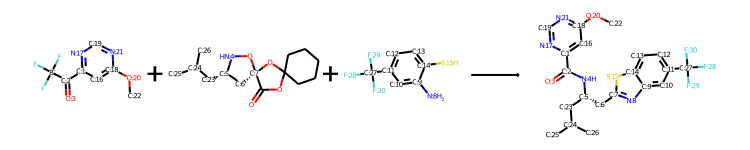

In [29]:
rxns[1]

In [31]:
reaction_smiles_atom_mapped = [rdChemReactions.ReactionToSmiles(r) for r in rxns]

In [32]:
display(SVG(draw_chemical_reaction(reaction_smiles_atom_mapped)))

NameError: name 'draw_chemical_reaction' is not defined

In [58]:
# assemble results
data = [(*i, j, k) for i, j, k in zip(res, reaction_smiles, reaction_smiles_atom_mapped)]

In [66]:
with con.con:
    con.con.executemany("INSERT INTO representations (experiment_id, I_long, M_long, T_long, product_A_smiles, I_smiles, M_smiles, T_smiles, reaction_smiles, reaction_smiles_atom_mapped) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);", data)